<h1 style="text-align: center;"><strong>QRT Challenge : Learning factors for stock market returns prediction</strong></h1>


<h3 style="color: #2E86C1; text-decoration: underline;">Contexte du challenge</h3>

Ce challenge porte sur la prédiction des rendements des actions, sur un marché boursier. Étant donné un ensemble de $ N $ actions et leurs rendements $ R_t $ à un instant $ t $, l'objectif est de concevoir à chaque instant $ t $ un vecteur $ S_{t+1} $ qui maximisera le chevauchement avec les rendements réels $ R_{t+1} $, c'est-à-dire $ \langle S_{t+1}, R_{t+1} \rangle $. Ce problème est abordé avec un modèle factoriel linéaire, où les facteurs sont appris dans un espace de paramètres non linéaire. Il s'agit donc plutôt d'un problème de regression plutôt que de classification.


<h3 style="color: #2E86C1; text-decoration: underline;">Vue d'ensemble du modèle</h3>

Le modèle classique utilisé pour prédire les rendements des actions est un modèle linéaire :

$$
S_{t+1} = \sum_{\ell=1}^F \beta_\ell F_{t,\ell}
$$

Où :

- $ F_{t,\ell} $ sont des facteurs explicatifs ou des caractéristiques.
- $ \beta_1, \dots, \beta_F $ sont les paramètres du modèle qui sont appris lors de l'entraînement.

Le challenge explore également la possibilité de concevoir les facteurs eux-mêmes, où $ F_{t,\ell} $ sont des fonctions linéaires des rendements passés. Cela conduit à la formulation suivante :

$$
F_{t,\ell} = \sum_{k=1}^D A_{k\ell} R_{t+1-k}
$$

Ici :

- $ A_\ell $ sont des vecteurs qui définissent les facteurs, et
- $ D $ est la profondeur temporelle.

Les vecteurs $ A_1, \dots, A_F $ doivent être orthonormés, ce qui ajoute une contrainte non linéaire à l'espace des paramètres.

<h3 style="color: #2E86C1; text-decoration: underline;">Objectif</h3>

L'objectif est de concevoir et d'apprendre les facteurs $ F_{t,\ell} $ pour la prédiction des rendements des actions, tout en garantissant que les vecteurs $ A_1, \dots, A_F $ respectent la contrainte d'orthonormalité.

<h3 style="color: #2E86C1; text-decoration: underline;">Données</h3>

- **Données d'entraînement** : Un dataframe contenant les rendements quotidiens de 50 actions sur une période de 754 jours (3 ans) est fourni. Ces données seront utilisées pour apprendre les paramètres $ A $ et $ \beta $.
- **Données de test** : Un jeu de données de test est fourni, comportant les jours de rendements suivants les 250 jours des données d'entraînement.

<h3 style="color: #2E86C1; text-decoration: underline;">Métrique d'évaluation</h3>

La performance du modèle est évaluée par une métrique qui mesure l'alignement entre les rendements prédits et les rendements réels pour les données de test, définie comme suit :

$$
M_{\text{trique}}(A, \beta) = \frac{1}{504} \sum_{t=250}^{753} \frac{\langle S_t, R_t \rangle}{\|S_t\| \|R_t\|}
$$

Si la condition d'orthonormalité $ \langle A_i, A_j \rangle = \delta_{ij} $ est violée, la métrique renverra -1. Sinon, la métrique variera entre -1 et 1.

<h3 style="color: #2E86C1; text-decoration: underline;">Stratégie de benchmarking</h3>

Une approche de base est fourni consistant à générer des vecteurs orthonormés aléatoires $ A_1, \dots, A_F $, à ajuster $ \beta $ par régression linéaire sur les données d'entraînement et à sélectionner le meilleur résultat en fonction de la métrique. La procédure de benchmark est la suivante :

1. Générer aléatoirement $ A_1, \dots, A_F $.
2. Appliquer l'algorithme de Gram-Schmidt pour garantir l'orthonormalité.
3. Ajuster $ \beta $ en utilisant la régression des moindres carrés.
4. Calculer la métrique et sélectionner le meilleur modèle.

Cela fournit une stratégie de référence pour comparer les solutions modélisées.

<h3 style="color: #2E86C1; text-decoration: underline;">Méthodologie</h3>

Dans un premier temps, nous allons définir des features classiques des facteurs de rendement connus dans la littérature, telles que : Momentum, Moving Average, RSI & Volatility

Ensuite, à partir de ces features, nous réaliserons un premier modèle linéaire simple afin d'obtenir une valeur de la métrique de précision du modèle, modèle qui sera étendu par une approche combinatoire avec le benchmark du challenge.

Nous explorerons ensuite un modèle de clustering K-means non supervisé grâce à une ACP afin d'en extraire les facteurs explicatifs des rendements et d'observer les performances de ce modèle par rapport au modèle simple.

Par ailleurs, nous nous pencherons également vers un panel de modèles supervisés comme le Boosting (via xgBoost), le Random Forest et le Bagging déstinés à capter davantage d'information et de bruit sur nos données pour mieux prédire nos rendements.

## Partie I - Gestion et analyse de la donnée

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.linalg
from sklearn.model_selection import train_test_split,GridSearchCV,ParameterGrid,KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from tqdm import tqdm  # Pour afficher la progression
from sklearn.ensemble import BaggingRegressor,RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor


In [5]:
# Chargement des données présents dans le même fichier

data_X = pd.read_csv('X_train.csv', index_col=0, sep=',')
data_X.columns.name = 'date'

# Split du data set de training avec test set avec règle standard 80/20.
X_train = data_X.iloc[:40,:] #Jeu de données d'entrainement
X_test = data_X.iloc[40:,:] # Jeu de données de validation

data_Y = pd.read_csv('Y_train.csv', index_col=0, sep=',')
data_Y.columns.name = 'date'
Y_train = data_Y.iloc[:40,:] # Jeu de données d'entrainement à prédire (aussi présente dans X_train)
Y_test = data_Y.iloc[40:,:] # Jeu du test de validation (à prédire in fine par le modèle entrainé, aussi présente dans X_test)


# Affichage des premières lignes des datasets
print("Aperçu des données X_train:")
print(X_train.head())
print("\nAperçu des données Y_train:")
print(Y_train.head())


Aperçu des données X_train:
date             0         1         2         3         4         5  \
stocksID                                                               
0        -0.018647 -0.013002 -0.010776 -0.016676 -0.005110  0.009092   
1        -0.008254 -0.022280  0.012173 -0.006820 -0.004055  0.012912   
2        -0.008404 -0.013629 -0.006044 -0.003425 -0.009522 -0.001353   
3        -0.022734 -0.006981 -0.008568 -0.010899 -0.017981  0.002485   
4        -0.024546 -0.008315 -0.007991 -0.003515  0.007872  0.007082   

date             6         7         8         9  ...       744       745  \
stocksID                                          ...                       
0        -0.011745  0.007120 -0.008451  0.009119  ... -0.012525 -0.011716   
1        -0.001293  0.009994 -0.002747  0.001664  ...  0.014432 -0.002255   
2        -0.000637  0.007640  0.001600  0.007416  ... -0.006245 -0.001329   
3        -0.011980  0.012446 -0.010636  0.003807  ... -0.005179 -0.003442   
4    

In [6]:
# Vérification des valeurs manquantes par actif (ligne)
missing_values_per_stock = X_train.isnull().sum(axis=1)
missing_values_per_stock = missing_values_per_stock[missing_values_per_stock > 0]

if not missing_values_per_stock.empty:
    plt.figure(figsize=(10, 5))
    missing_values_per_stock.plot(kind="bar")
    plt.xlabel("Index des stocks")
    plt.ylabel("Nombre de valeurs manquantes")
    plt.title("Valeurs manquantes par actif")
    plt.show()
else:
    print("Aucune valeur manquante détectée dans X_train.")

print("Nombre de valeurs manquantes par actif:")
print(missing_values_per_stock)

# Remplacement des valeurs manquantes par la moyenne de chaque ligne
X_train = X_train.apply(lambda row: row.fillna(row.mean()), axis=1)

# Vérification après imputation
total_missing_after = X_train.isnull().sum().sum()
print(f"Total de valeurs manquantes après imputation : {total_missing_after}")



Aucune valeur manquante détectée dans X_train.
Nombre de valeurs manquantes par actif:
Series([], dtype: int64)
Total de valeurs manquantes après imputation : 0


## Analyse statistiques des données


Statistiques des actifs:
                  Mean       Std  Skewness  Kurtosis       Max       Min
stocksID                                                                
0         1.565039e-04  0.011626  0.373388  1.702471  0.059061 -0.042102
1         3.313147e-04  0.006856 -0.263619  1.613290  0.021139 -0.033115
2        -3.476568e-04  0.009378 -0.034502  0.976077  0.036398 -0.033386
3        -1.999018e-07  0.011018 -0.147188  0.981895  0.046312 -0.045707
4         1.057414e-04  0.011078 -0.132906  2.053168  0.056822 -0.046940


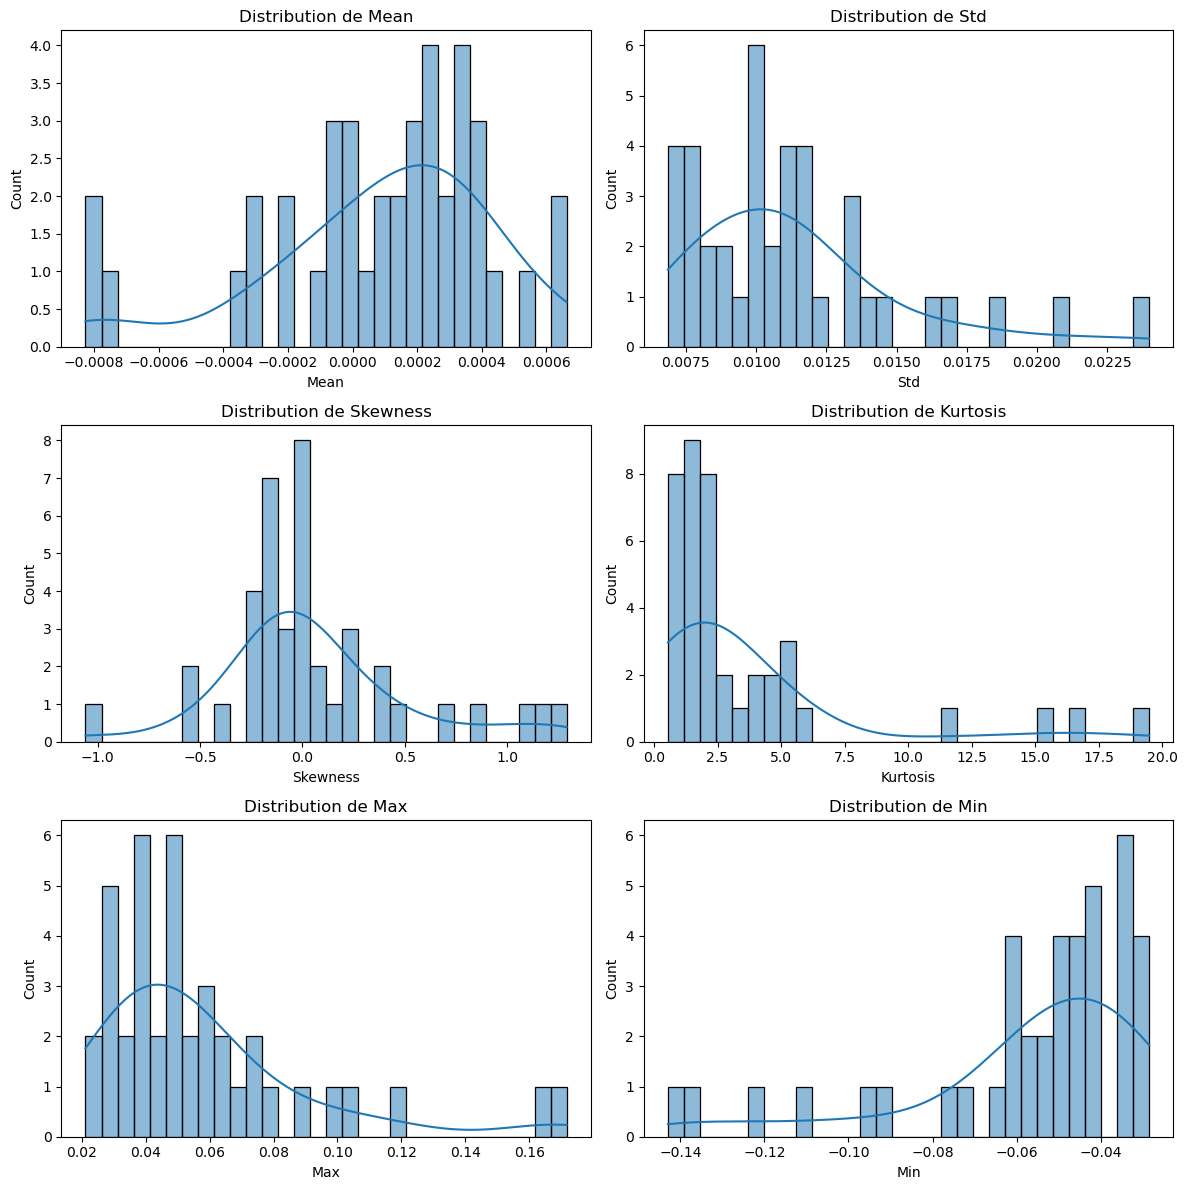

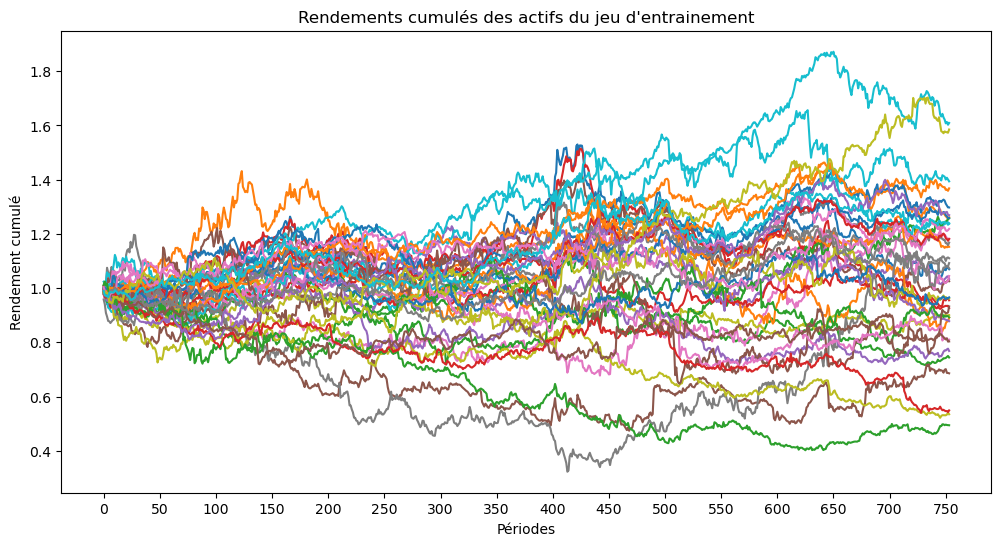

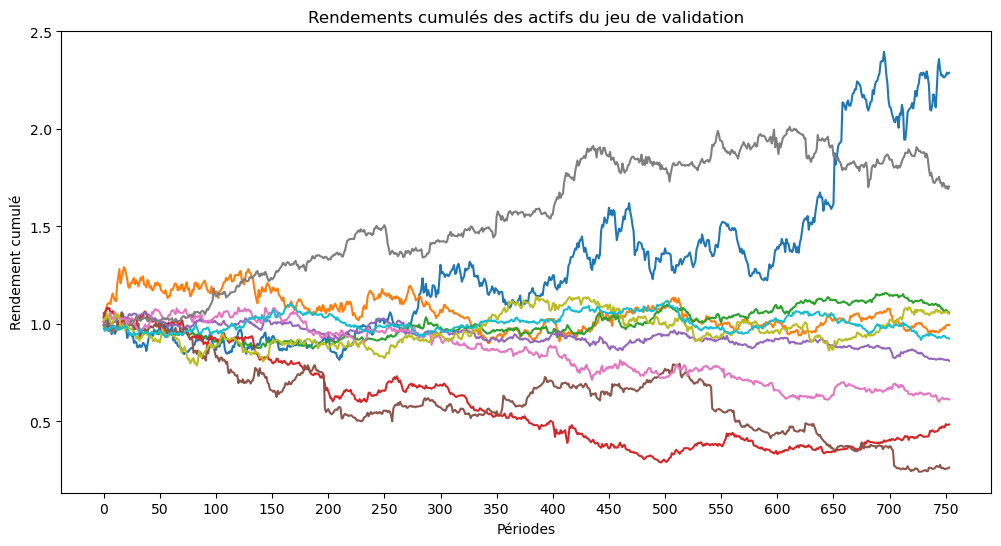

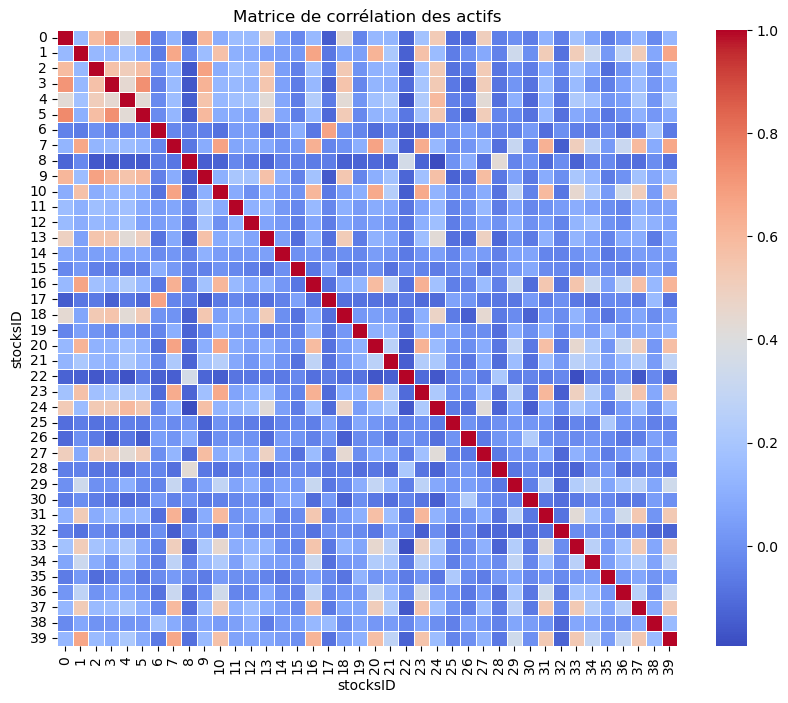

In [7]:
# Analyse statistique des données
stats_df = pd.DataFrame({
    "Mean": X_train.mean(axis=1),
    "Std": X_train.std(axis=1),
    "Skewness": X_train.skew(axis=1),
    "Kurtosis": X_train.kurtosis(axis=1),
    "Max": X_train.max(axis=1),
    "Min": X_train.min(axis=1)
})

print("\nStatistiques des actifs:")
print(stats_df.head())

# Visualisation des distributions des statistiques
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.flatten()

for idx, column in enumerate(stats_df.columns):
    sns.histplot(stats_df[column], bins=30, kde=True, ax=axes[idx])
    axes[idx].set_title(f"Distribution de {column}")

plt.tight_layout()
plt.show()

# Calcul des rendements cumulés
cumulative_returns_train = (1 + X_train).cumprod(axis=1)
cumulative_returns_test = (1 + X_test).cumprod(axis=1)

# Tracé des rendements cumulés
plt.figure(figsize=(12, 6))
for stock in cumulative_returns_train.index:
    plt.plot(cumulative_returns_train.columns, cumulative_returns_train.loc[stock])

plt.xticks(np.arange(0, len(cumulative_returns_train.columns), step=50))  # Affichage tous les 10 jours
plt.xlabel("Périodes")
plt.ylabel("Rendement cumulé")
plt.title("Rendements cumulés des actifs du jeu d'entrainement")
plt.show()

# Tracé des rendements cumulés
plt.figure(figsize=(12, 6))
for stock in cumulative_returns_test.index:
    plt.plot(cumulative_returns_test.columns, cumulative_returns_test.loc[stock])

plt.xticks(np.arange(0, len(cumulative_returns_test.columns), step=50))  # Affichage tous les 10 jours
plt.xlabel("Périodes")
plt.ylabel("Rendement cumulé")
plt.title("Rendements cumulés des actifs du jeu de validation")
plt.show()

# Calcul de la matrice de corrélation entre les actifs
corr_matrix = X_train.T.corr()

# Plot de la matrice de corrélation en heatmap (sans les chiffres)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap="coolwarm", linewidths=0.5)  # annot=False par défaut
plt.title("Matrice de corrélation des actifs")
plt.show()


Concernant l'analyse descriptive des rendements des actifs, nous observons que :
- les actions ont une moyenne, en moyenne, proche de 0,0002 avec quelque extrêmes à -0,0008 et 0,0006, il ne sera pas nécessaire d'ajuster les données par rapport a de potentiel outliers. 
- des ecarts-types principalement centrés autour de 0,01 avec pas mal d'actions davantages volatiles.
- des skewness typiques des séries de rendement financiers avec un décalage légèrement marqué vers la gauche, donc négatif en moyenne.
- pour la plupart des actifs, de l'excès de kurtosis encore une fois typique des faits stylisés des séries financières ne suivant pas une loi gaussienne.
- une corrélation entre actifs globalement faible même si quelque actifs semblent avoir une corrélation plus ou moins forte sur les premiers, le 10, 19 et 25 ème.

## Partie II - Méthode de modélisation des facteurs et de la métrique de précision (issues du notebook fourni par le challenge)

In [8]:
# Reshape des données : reconstruit un nouveau dataframe avec les valeurs de X_train décalées de 1 à 250 jours. Chaque ligne represente un actif et une date, et chaque colonne représente un retard.
#Exemple, en première ligne l'actif 0 (le 1er), au niveau des colonnes, on observe la valeur du rendement en t-1, puis t-2 etc...

X_train_reshape = pd.concat([ X_train.T.shift(i+1).stack(future_stack=False) for i in range(250) ], axis =1).dropna()
X_train_reshape.columns = pd.Index(range(1,251), name='timeLag') #Renomme les colonnes pour représenter chaque décalage temporel.

X_test_reshape = pd.concat([ X_test.T.shift(i+1).stack(future_stack=False) for i in range(250) ], axis =1).dropna()
X_test_reshape.columns = pd.Index(range(1,251), name='timeLag') #Renomme les colonnes pour représenter chaque décalage temporel.

# pour vérifier les contraintes d'orthonormalité pour la métrique de performance
def checkOrthonormality(A): 
    
    bool = True
    D, F = A.shape   
    Error = pd.DataFrame(A.T @ A - np.eye(F)).abs()
    
    max_error = Error.values.max()  # Erreur maximale
    if max_error > 1e-6:
        print(f"⚠️ Problème d'orthonormalité : max error = {max_error:.2e}")
        bool = False
        
    return bool

#Génération des facteurs aléatoires
def randomA(D=250, F=10):  
    
    M = np.random.randn(D,F)
    randomStiefel = np.linalg.qr(M)[0] # applique l'algorithme de Gram-Schmidt aux colonnes de M
    
    return randomStiefel

#Génère un vecteur beta avec m premiers éléments non nuls
def firstBeta(m=1, F=10):

    beta = np.zeros(F)
    beta[:m] = 1
    
    return beta

#Regression lineaire pour ajuster le vecteur beta à partir des facteurs A et des variables cibles Y_train
def fitBeta(A):
    
    predictors = X_train_reshape @ A # the dataframe of the 10 factors created from A with the (date, stock) in index
    targets = Y_train.T.stack() #Transposition de Y_train et mise sous un format de colonne unique
    beta = np.linalg.inv(predictors.T @ predictors) @ predictors.T @ targets #OLS entre rendements à prédire (apres 250) et les facteurs et les rendements actuels (de 0 à 250)
    
    return beta.to_numpy()


#Regression lineaire pour ajuster le vecteur beta à partir des facteurs A et des variables cibles Y_train
def fitBeta_with_input(A,X_reshape_input,Y):
    
    predictors = X_reshape_input @ A # le dataframe des 10 facteurs créés à partir de A avec les (date, stock) en index
    targets = Y.T.stack() #Transposition de Y_train et mise sous un format de colonne unique
    beta = np.linalg.inv(predictors.T @ predictors) @ predictors.T @ targets #OLS entre rendements à prédire (apres 250) et les facteurs et les rendements actuels (de 0 à 250)
    
    return beta.to_numpy()

#Calcul de la métrique
def metric_train(A, beta): 
    
    if not checkOrthonormality(A):
        return -1.0    
    
    Ypred = (X_train_reshape @ A @ beta).unstack().T #Prédiction avec les facteurs et les beta
    Ytrue = Y_train #Vrai valeurs des rendements
    
    # Normalisation des matrices en divisant chaque valeur par la norme (racine carrée de la somme des carrés).
    Ytrue = Ytrue.div(np.sqrt((Ytrue**2).sum()), 1)    
    Ypred = Ypred.div(np.sqrt((Ypred**2).sum()), 1)

    # Nettoyage préventif après normalisation si présence de NaN / infini liés à des divisions proches de zéro
    Ytrue = Ytrue.replace([np.inf, -np.inf], np.nan).fillna(0)
    Ypred = Ypred.replace([np.inf, -np.inf], np.nan).fillna(0)
    
    meanOverlap = (Ytrue * Ypred).sum().mean() #Mesure la similarité entre les prédictions et les vraies valeurs en calculant un produit scalaire moyen.


    return  meanOverlap 


def metric(A, beta, X, Y):
    """
    Calcule la métrique d'alignement
    """
    # Vérification de l'orthonormalité de A
    if not checkOrthonormality(A):
        return -1.0
    
    # Prédiction avec les facteurs et les beta
    Ypred = (X @ A @ beta).unstack().T
    
    # Normalisation des matrices
    Ytrue_norm = Y.div(np.sqrt((Y**2).sum()), axis=1)
    Ypred_norm = Ypred.div(np.sqrt((Ypred**2).sum()), axis=1)

    # Nettoyage préventif après normalisation
    Ytrue_norm = Ytrue_norm.replace([np.inf, -np.inf], np.nan).fillna(0)
    Ypred_norm = Ypred_norm.replace([np.inf, -np.inf], np.nan).fillna(0)

    # Calcul de la métrique d'alignement (produit scalaire moyen)
    meanOverlap = (Ytrue_norm * Ypred_norm).sum().mean()
    
    return Ypred, Ytrue_norm, Ypred_norm, meanOverlap

# Performance et prédiction :

Nous implémentons une fonction de prédiction qui compare les rendements prédits par le modèle à ceux observés, afin de comparer visuellement l’accuracy des modèles.

In [9]:
# Utilise les facteurs A et le vecteur beta pour prédire les rendements futurs et évalue les performances du modèle.
def predict_and_evaluate_avec_normalisation(A,Y,X_reshape_input,beta =None,istrain:bool=True,load_plot=True):

    if beta is None : beta = fitBeta_with_input(A,X_reshape_input,Y)  # Régression linéaire pour ajuster beta

    # Calcul des métriques
    Ypred, Ytrue_norm, Ypred_norm, meanOverlap = metric(A, beta, X_reshape_input, Y)  # Calcul de la métrique
    mse = mean_squared_error(Y.values.flatten(), Ypred.values.flatten())
    correlation = np.corrcoef(Y.values.flatten(), Ypred.values.flatten())[0, 1]
    if np.isnan(correlation):
        print("Attention : Corrélation non définie (valeurs constantes ou NaN).")

    if istrain:
        titre ="jeu d'entrainement"
    else:
        titre ="jeu de test"

    print(f"Performance du modèle sur {titre} :")
    print(f"Valeur de la metrique : {meanOverlap:.6f}")
    print(f"Erreur quadratique moyenne (MSE) : {mse:.6f}")
    print(f"Racine de l'erreur quadratique moyenne (RMSE) : {np.sqrt(mse):.6f}")
    print(f"Corrélation entre les prédictions et les vraies valeurs : {correlation:.4f}")

    if load_plot:
        # Plot 1 : Moyenne des valeurs prédites vs vraies valeurs (normalisées)

        # Sélection des indices des jours à afficher tous les 50 jours
        tick_positions = Y.columns[::50]  # Prendre un point tous les 50 jours
        tick_labels = [str(day) for day in tick_positions]  # Conversion en string pour l'affichage
    
        plt.figure(figsize=(10, 5))
        plt.plot(Y.columns, Ytrue_norm.mean(axis=0), label="Vraies valeurs (normalisées)", color="blue")
        plt.plot(Y.columns, Ypred_norm.mean(axis=0), label="Prédictions (normalisées)", color="red", linestyle="dashed")
        plt.xticks(ticks=tick_positions, labels=tick_labels, rotation=45)
        plt.xlabel("Jours après 250")
        plt.ylabel("Rendement normalisé moyen")
        plt.title(f"Comparaison des rendements normalisés du {titre} : Réels vs Prédits")
        plt.legend()
        plt.grid()
        plt.show()

        # Plot 2 : Histogramme des erreurs (inchangé)
        errors = (Ypred - Y).values.flatten()
        plt.figure(figsize=(8, 5))
        plt.hist(errors, bins=50, color="purple", alpha=0.7, edgecolor="black")
        plt.axvline(0, color='black', linestyle='dashed', linewidth=1)
        plt.xlabel("Erreur de prédiction (Prédiction - Réel)")
        plt.ylabel("Fréquence")
        plt.title(f"Distribution des erreurs de prédiction du {titre}")
        plt.grid()
        plt.show()

        # Plot 3 : Rendements cumulés normalisés (au lieu des valeurs brutes)
        plt.figure(figsize=(10, 5))
        
        cumulative_real = (1 + Ytrue_norm.mean(axis=0)).cumprod() - 1
        cumulative_pred = (1 + Ypred_norm.mean(axis=0)).cumprod() - 1

        plt.plot(Y_train.columns, cumulative_real, label="Rendement cumulé normalisé - Réel", color="blue")
        plt.plot(Y_train.columns, cumulative_pred, label="Rendement cumulé normalisé - Prédiction", color="red", linestyle="dashed")
        plt.xticks(ticks=tick_positions, labels=tick_labels, rotation=45)
        plt.xlabel("Jours après 250")
        plt.ylabel("Rendement cumulé normalisé moyen")
        plt.title(f"Comparaison des rendements cumulés normalisés du {titre} : Réels vs Prédits")
        plt.legend()
        plt.grid()
        plt.show()

    return mse, correlation, beta


# Affiche, pour chaque actif, son rendement cumulé réel (ligne continue) et prédit (ligne pointillée) dans des sous-graphiques organisés en 5x2.
def plot_cumulative_returns_per_asset(Y_test, Ytrue, Ypred):

    # Pré-néttoyage potentiel
    Ytrue = Ytrue.dropna()
    Ypred = Ypred.dropna()

    n_assets = len(Y_test.index)
    
    # On prévoit un maximum de 10 sous-graphiques (5 lignes x 2 colonnes).
    # Si vous avez plus de 10 actifs, seuls les 10 premiers seront tracés.
    # Ajustez si nécessaire.
    max_plots = 10  
    n_plots = min(n_assets, max_plots)
    
    # Création de la figure et de la grille de sous-plots
    # sharex=False, sharey=False => chaque subplot a sa propre échelle
    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(14, 18),
                             sharex=False, sharey=False)
    axes = axes.flatten()  # Pour itérer facilement

    # Palette de couleurs
    colors = plt.cm.tab10(np.linspace(0, 1, n_plots))
    
    for i, asset in enumerate(Y_test.index[:n_plots]):
        ax = axes[i]
        
        # Calcul du rendement cumulé pour l'actif (réel et prédit)
        cumulative_real = (1 + Ytrue.loc[asset]).cumprod() - 1
        cumulative_pred = (1 + Ypred.loc[asset]).cumprod() - 1
        
        # Tracé avec la même couleur : ligne continue pour le réel, pointillée pour la prédiction
        ax.plot(Y_test.columns, cumulative_real, color=colors[i], linestyle='-', label="Réel")
        ax.plot(Y_test.columns, cumulative_pred, color=colors[i], linestyle='--', label="Prédit")
        
        ax.set_title(f"Actif : {asset}")
        ax.grid(True)
        ax.legend()
    
    # On supprime les sous-plots inutilisés s'il y a moins de 10 actifs
    for j in range(n_plots, 10):
        fig.delaxes(axes[j])
    
    fig.suptitle("Rendements cumulés normalisés par actif", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Laisse de la place pour le titre global
    plt.show()


## Benchmark de construction de facteurs et d'analyse de métrique

Facteurs générés de manière aléatoire 1000 fois, puis sélection des facteurs offrant la meilleure métrique. Cette approche sert de référence (benchmark) pour le modèle à implémenter.

0 metric_train: 0.03498249220188182
1 metric_train: 0.04175985816755474
31 metric_train: 0.04611671283903353
91 metric_train: 0.04933169735239698
421 metric_train: 0.051086247338319526
496 metric_train: 0.051510107497403854
675 metric_train: 0.05454273855058288
Performance du modèle sur jeu d'entrainement :
Valeur de la metrique : 0.054543
Erreur quadratique moyenne (MSE) : 0.000147
Racine de l'erreur quadratique moyenne (RMSE) : 0.012121
Corrélation entre les prédictions et les vraies valeurs : 0.0592


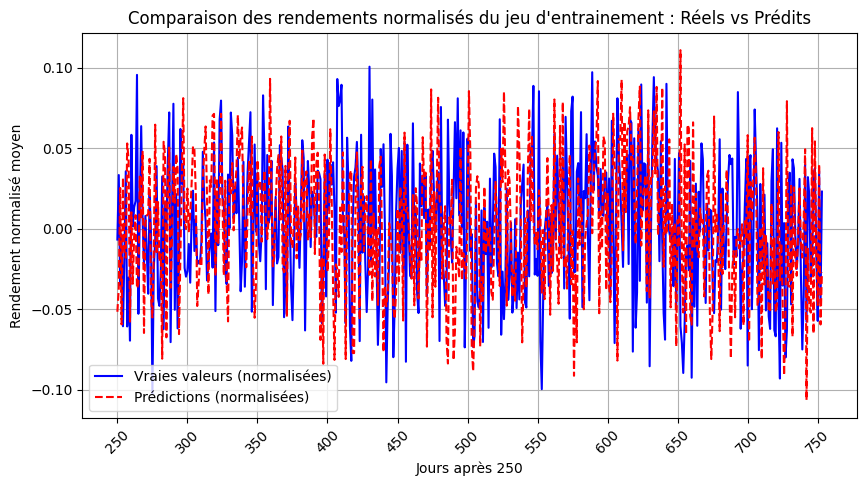

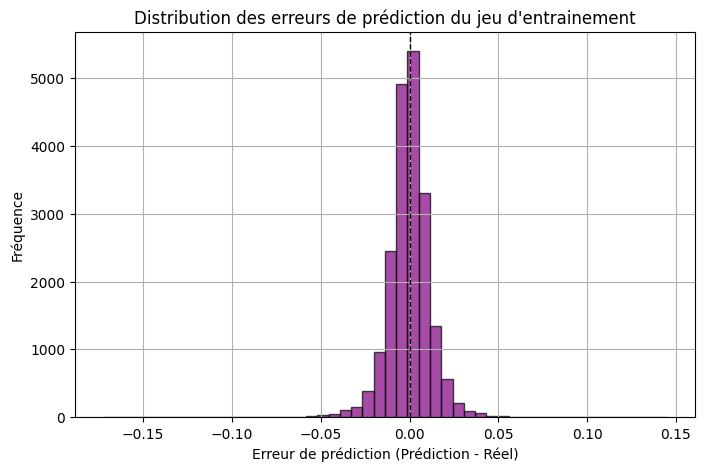

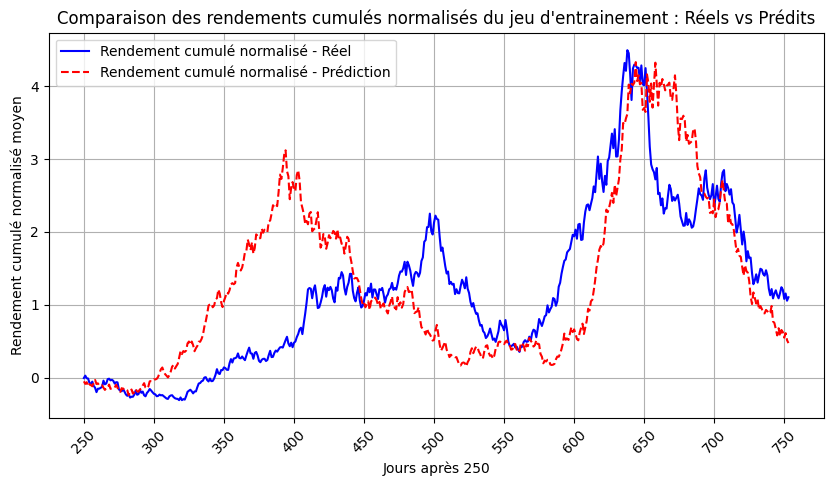

Performance du modèle sur jeu de test :
Valeur de la metrique : 0.000493
Erreur quadratique moyenne (MSE) : 0.000222
Racine de l'erreur quadratique moyenne (RMSE) : 0.014907
Corrélation entre les prédictions et les vraies valeurs : 0.0129


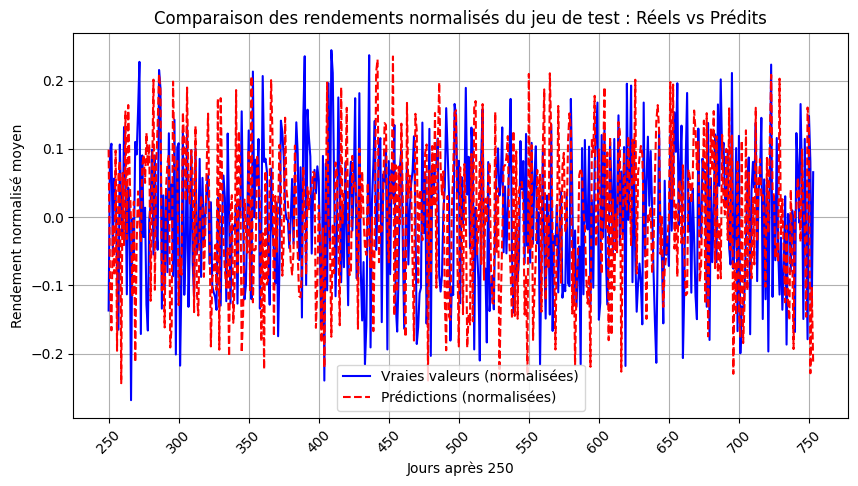

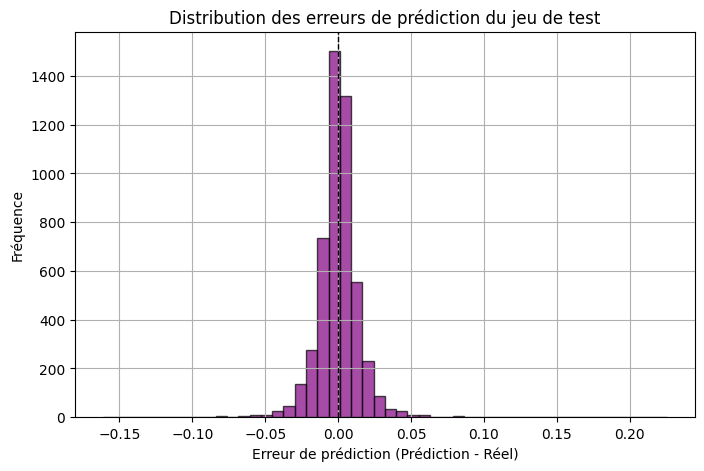

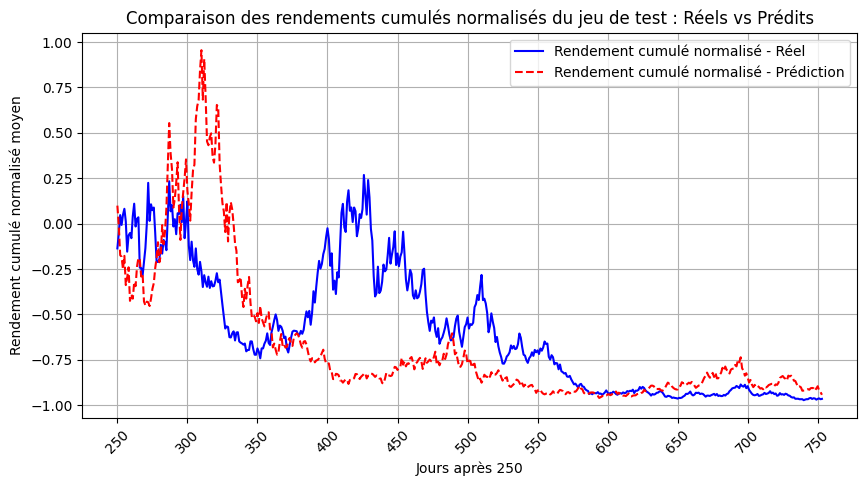

In [33]:
Niter = 1000
maxMetric = -1

np.random.seed(1234)

for iteration in range(Niter):
    
    # Generate a uniform random Stiefel matric A and fit beta with minimal mean square prediction error on the training data set
    
    A = randomA()
    beta = fitBeta(A) # A partir des facrtors générés aléatoirement, il va prendre pour chaque point de données, les 250 données précédement formaté a partir de X_reshape et va faire une regression linéaire pour prédire les rendements futurs.
    
    # compute the metric on the training set and keep the best result   
    
    m = metric_train(A, beta)
        
    if m > maxMetric:
        print(iteration, 'metric_train:', m)
        
        maxMetric = m
        A_QRT = A
        beta_QRT = beta  

# Evaluation du modèle sur le jeu de train
mse, correlation,beta = predict_and_evaluate_avec_normalisation(A_QRT, Y_train,X_train_reshape,istrain=True) 

# Evaluation du modèle sur le jeu de test, avec le beta determiner grace au jeu de train
mse, correlation,_ = predict_and_evaluate_avec_normalisation(A_QRT, Y_test, X_test_reshape,beta = beta, istrain=False) 


Globalement, les prédictions basées sur l'approche des facteurs générés aléatoirement et rendus orthonormalisés échouent naturellement à capturer les dynamiques du marché. En effet, sur le jeu d'entraînement, cela semble, graphiquement et quantitativement, satisfaisant (métrique de 0,054543), mais ce modèle est par définition overfité, puisqu'il retient la matrice A maximisant la métrique sur plusieurs tirages aléatoires. On obtient donc, logiquement, une métrique pour le jeu de test très faible (0,000493) et des résultats graphiques très pauvres.

## Partie III - Analyse d'un modèle de régression ajusté à partir de facteurs financiers issus de la littérature


Nous travaillons sur des rendements financiers et avons sélectionné des features classiques issues de la littérature financière :

- **Momentum** : rendement cumulé sur une fenêtre déterminée, qui mesure la tendance d'un actif.
- **Volatility** : écart-type annualisé des rendements sur une période donnée, indicateur de risque.
- **Moving average** : moyenne mobile des rendements, utile pour lisser les variations et identifier des tendances.
- **RSI (Relative Strength Index)** : indicateur de surachat ou de survente basé sur la force relative des gains et pertes récents.


Une fois calculés, ces indicateurs sont normalisés (sous forme de z-scores) afin d’être comparables d’un actif à l’autre. L’idée est de capter, pour chaque date, un signal moyen à partir de l’ensemble des actifs : on agrège donc les z-scores de chacun de ces indicateurs pour obtenir un facteur commun (par exemple un « facteur momentum » global, un « facteur volatilité », etc.).

Ensuite, on assure l’orthonormalité de ces facteurs. Autrement dit, on les transforme de sorte qu’ils soient entre eux aussi indépendants que possible, de façon à éviter qu’un même signal soit mesuré deux fois. Lorsque plus de facteurs sont souhaités, on complète la matrice en générant des colonnes supplémentaires aléatoires, puis on orthonormalise à nouveau. Cette étape assure que chaque facteur capte une dimension spécifique du marché, sans redondance.

Enfin, le modèle linéaire est ajusté : pour chaque actif et chaque date, on estime un vecteur de coefficients (𝛽) traduisant la sensibilité des rendements à ces facteurs. On évalue ensuite la capacité du modèle à expliquer ou prédire les rendements observés via la métrique.


Performance du modèle sur jeu d'entrainement :
Valeur de la metrique : 0.027556
Erreur quadratique moyenne (MSE) : 0.000147
Racine de l'erreur quadratique moyenne (RMSE) : 0.012137
Corrélation entre les prédictions et les vraies valeurs : 0.0286


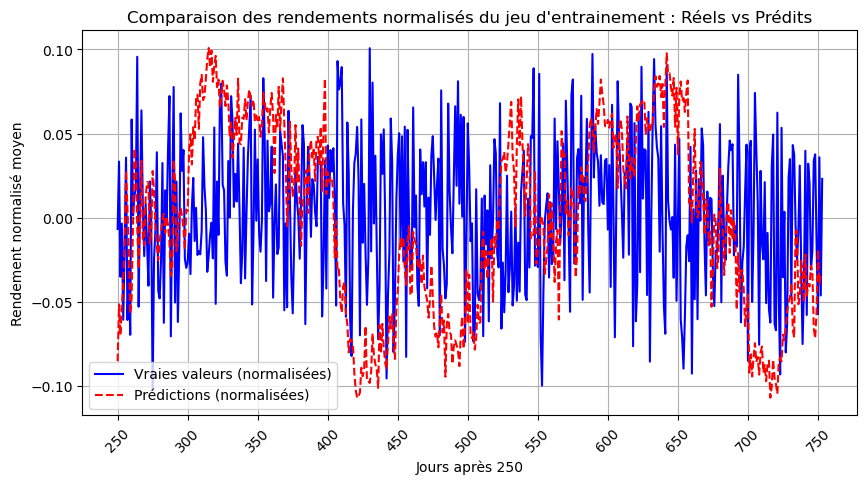

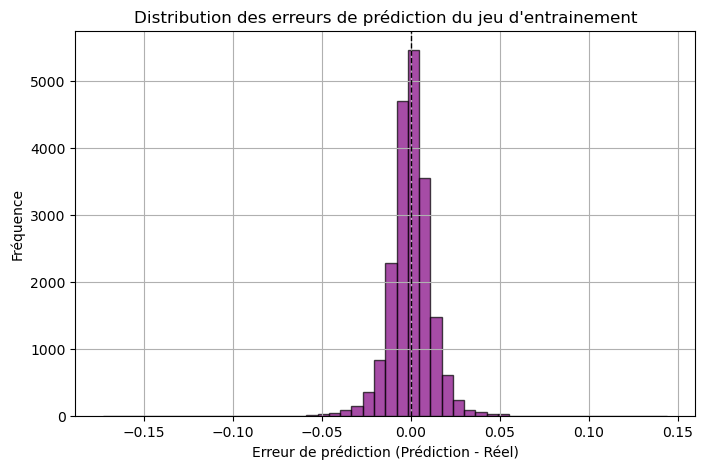

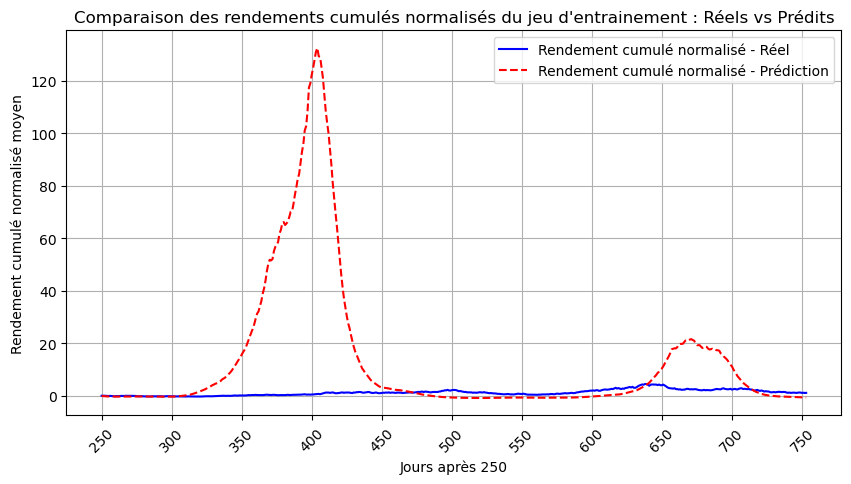

Performance du modèle sur jeu de test :
Valeur de la metrique : -0.006733
Erreur quadratique moyenne (MSE) : 0.000222
Racine de l'erreur quadratique moyenne (RMSE) : 0.014897
Corrélation entre les prédictions et les vraies valeurs : 0.0015


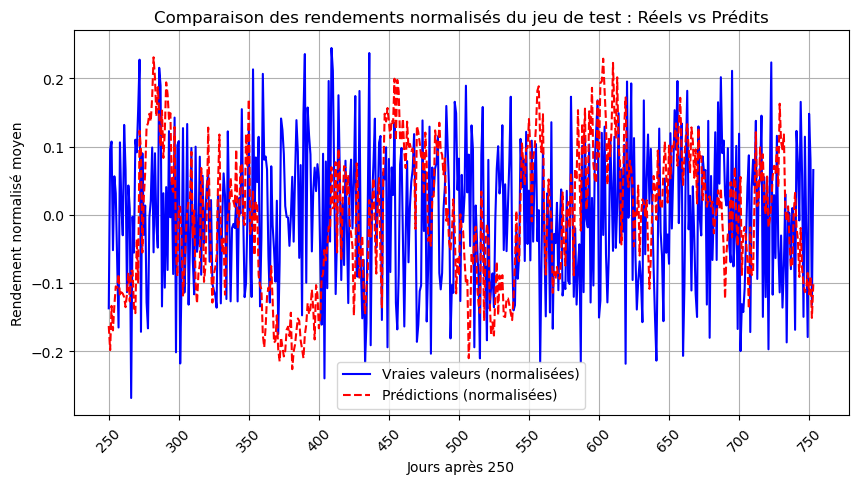

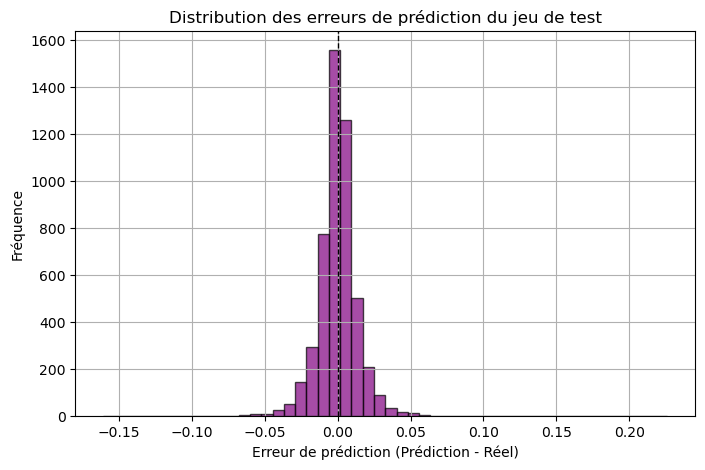

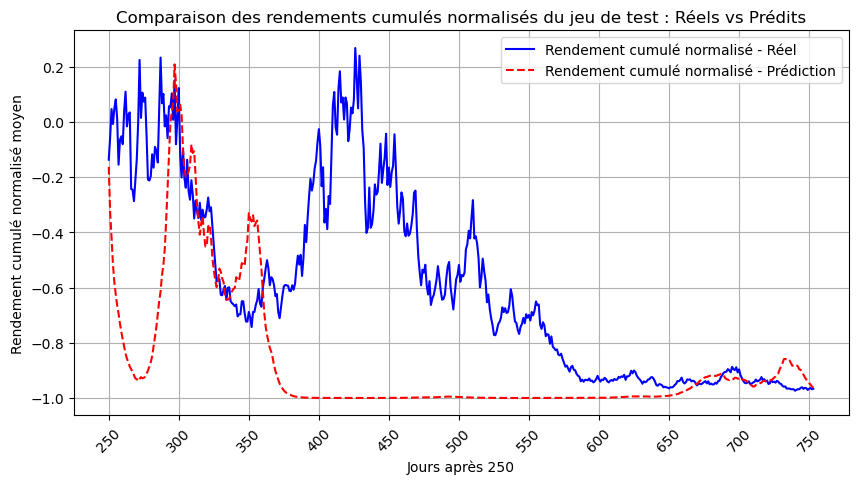

In [10]:
def compute_momentum(returns, window=21):
    """ Calcule le momentum comme rendement cumulé sur la période donnée """
    return returns.rolling(window=window).sum()

def compute_volatility(returns, window=21):
    """ Calcule la volatilité réalisée """
    return returns.rolling(window=window).std()

def compute_moving_average(price, window=21):
    """ Calcule la moyenne mobile """
    ma = price.rolling(window=window).mean()
    return price - ma

def compute_rsi(price, window=14):
    """ Calcule l'indicateur RSI, indicateur de surachat ou de suvente """
    delta = price.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean() #Moyenne des rendements positifs (gains)
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean() #Moyenne des rendement negatifs (pertes)
    rs = gain / loss
    return 100 - (100 / (1 + rs)) #Transformation du rs en score RSI (plus il est important plus c'est un signe de surachat et inversement)

def compute_z_score(series):
    """Calcule le z-score pour chaque série"""
    return (series - series.mean()) / series.std()


def generate_features(X_train):
    """ Génère les features et calcule un facteur unique pour chaque date """
    feature_dict = {}
    
    # Calcul des caractéristiques pour chaque actif
    for col in X_train.columns:

        # Calcul des caractéristiques : momentum, volatilité, moyenne mobile, et RSI
        feature_dict[f'momentum_{col}'] = compute_momentum(X_train[col])
        feature_dict[f'volatility_{col}'] = compute_volatility(X_train[col])
        feature_dict[f'moving_avg_{col}'] = compute_moving_average(X_train[col])
        feature_dict[f'rsi_{col}'] = compute_rsi(X_train[col])

    features = pd.concat(feature_dict, axis=1)  # On concatène tout en une seule fois
    
    # Calcul des z-scores pour chaque caractéristique sur tous les actifs à chaque date
    features_z = features.apply(compute_z_score, axis=0)  # Normalisation

    # Maintenant, pour chaque date, on calcule un facteur global (moyenne des z-scores)
    # pour chaque caractéristique
    factor_momentum = features_z.filter(like="momentum").mean(axis=1)  # Moyenne des z-scores du momentum
    factor_volatility = features_z.filter(like="volatility").mean(axis=1)  # Moyenne des z-scores de la volatilité
    factor_moving_avg = features_z.filter(like="moving_avg").mean(axis=1)  # Moyenne des z-scores de la moyenne mobile
    factor_rsi = features_z.filter(like="rsi").mean(axis=1)  # Moyenne des z-scores du RSI

    # DataFrame final avec un facteur pour chaque caractéristique à chaque date
    final_features = pd.DataFrame({
        'momentum_factor': factor_momentum,
        'volatility_factor': factor_volatility,
        'moving_avg_factor': factor_moving_avg,
        'rsi_factor': factor_rsi
    })
    
    # Garde seulement les 250 premières dates
    final_features = final_features.fillna(0)
    final_features = final_features.iloc[:250]
    
    return final_features

def A_Factors(D=250, F=10):
    factors = generate_features(X_train.T).values 
    
    # On normalise les 4 facteurs pour qu'ils soient orthonormaux
    A = np.zeros((D, F))
    for i in range(4):
        A[:, i] = factors[:, i] / np.linalg.norm(factors[:, i])

    A[:, :4] = scipy.linalg.orth(A[:, :4]) # Assure l'orthonormalité
    
    if F<=4:
        return A
    
    # # # Génération des 6 autres colonnes orthonormales
    orthoProj = np.eye(D)
    for i in range(4):
        orthoProj -= np.outer(A[:, i], A[:, i])
    
    A_remaining_columns = orthoProj @ np.random.randn(D, F - 4)
    A_remaining_columns = scipy.linalg.orth(A_remaining_columns)  # Orthonormalisation

    A[:, 4:] = A_remaining_columns
    return A

A = A_Factors(F=4)  # Génération des facteurs A avec nos 4 indicateurs seulement

# Evaluation sur le set d'entrainement
mse, correlation,beta = predict_and_evaluate_avec_normalisation(A, Y_train,X_train_reshape)

# Evaluation sur le set de test
mse, correlation,_ = predict_and_evaluate_avec_normalisation(A, Y_test,X_test_reshape,beta = beta,istrain=False)

Lorsqu'on retire les vecteurs aléatoires et qu'on modélise nos features, on observe une performance encore plus faible, aussi bien graphiquement que quantitativement. En effet, les prédictions tendent à fournir des résultats à une échelle beaucoup plus grande que celle des rendements attendus. Le choix manuel de nos features ne semble donc pas satisfaisant.

## Approche combinatoire avec nos 4 facteurs et F-4 autres randomisés et rendus orthonormalisés (processus du challenge)

Résultats pour 9 facteurs :
0 metric_train: 0.03294477617228363
1 metric_train: 0.040826249056191435
3 metric_train: 0.043115836656640656
12 metric_train: 0.0539452951221282
502 metric_train: 0.05675800948361467
Résultats pour 10 facteurs :
469 metric_train: 0.057023770381898216
Résultats pour 11 facteurs :
Performance du modèle sur jeu d'entrainement :
Valeur de la metrique : 0.057024
Erreur quadratique moyenne (MSE) : 0.000147
Racine de l'erreur quadratique moyenne (RMSE) : 0.012123
Corrélation entre les prédictions et les vraies valeurs : 0.0557


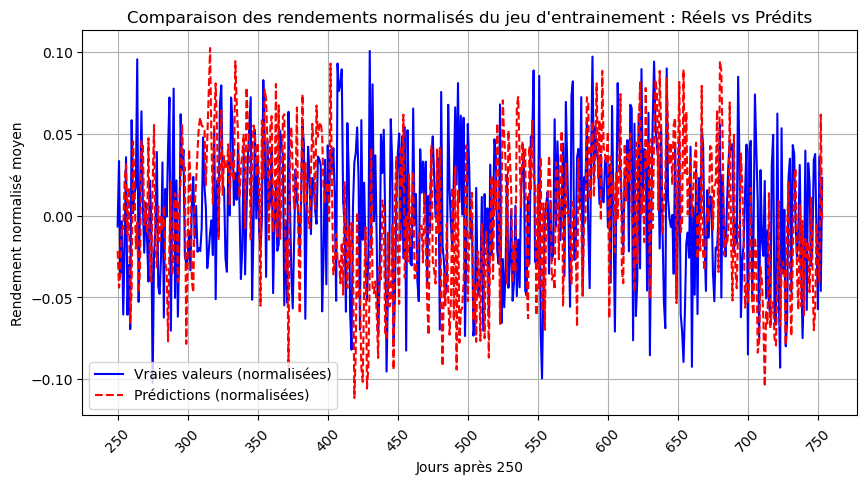

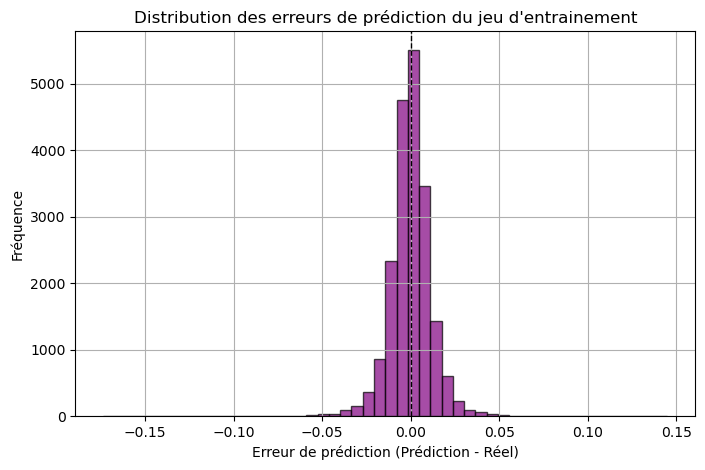

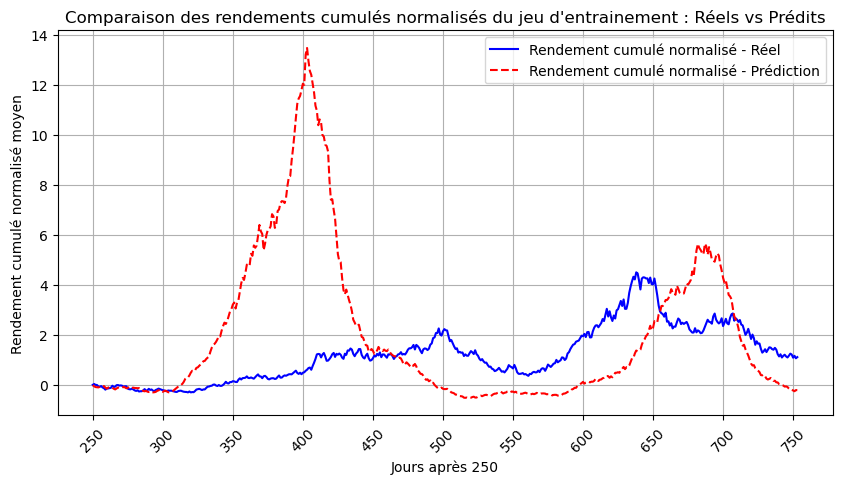

Performance du modèle sur jeu de test :
Valeur de la metrique : 0.010624
Erreur quadratique moyenne (MSE) : 0.000222
Racine de l'erreur quadratique moyenne (RMSE) : 0.014900
Corrélation entre les prédictions et les vraies valeurs : 0.0167


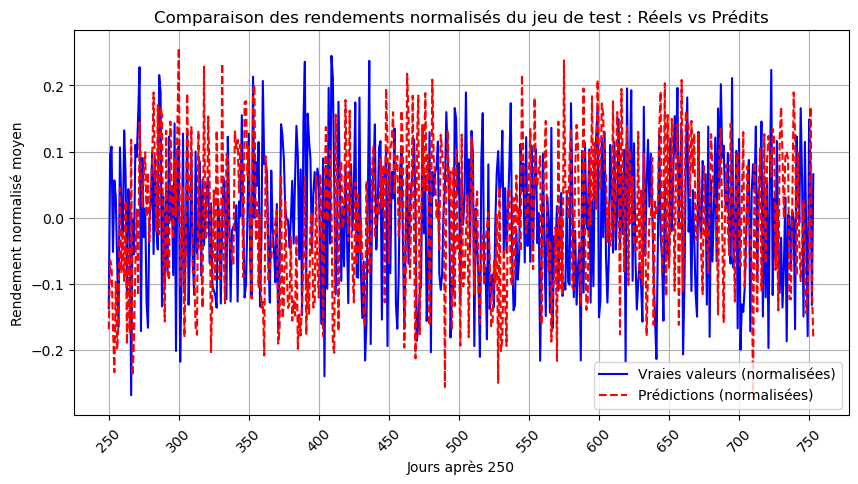

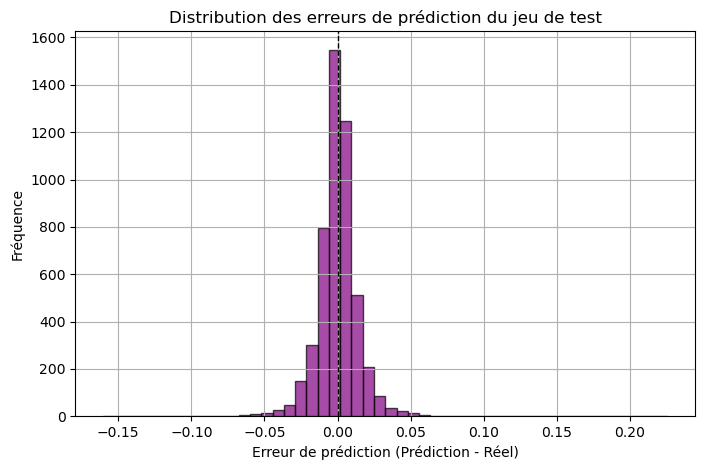

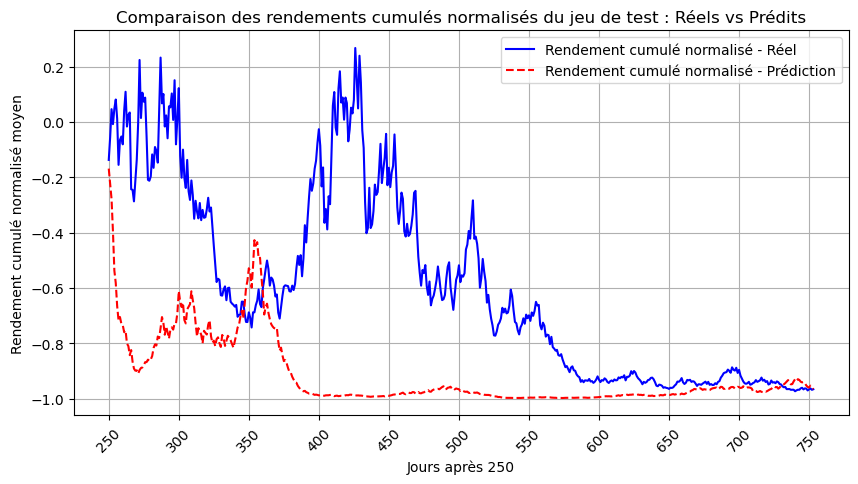

In [9]:
# En générant aléatoirement de 9 à 12 facteurs pour 1000 itérations successives
# Approche entre 9 à 12 facteurs, moins donnant systématiquement un metric score inférieur au benchmark
Niter = 600
maxMetric = -1

np.random.seed(1234)

for factor_i in range(9,12):
    print(f"Résultats pour {factor_i} facteurs :")

    for iteration in range(Niter):
        
        A = A_Factors(F=factor_i)
        beta = fitBeta(A)
        m = metric_train(A, beta)
            
        if m > maxMetric:
            print(iteration, 'metric_train:', m)
            
            maxMetric = m
            A_opt = A
            beta_opt = beta
            factor_opt = factor_i

# Evaluation sur le set d'entrainement
mse, correlation, beta = predict_and_evaluate_avec_normalisation(A_opt, Y_train,X_train_reshape)

# Evaluation sur le set de test
mse, correlation, _  = predict_and_evaluate_avec_normalisation(A_opt, Y_test,X_test_reshape,beta = beta,istrain=False)

Le mélange de nos features avec des facteurs aléatoires maximisant la métrique sur notre jeu d'entraînement nous permet d'obtenir des résultats légèrement plus satisfaisants, avec une métrique sur le jeu d'entraînement de 0,057024 (contre 0,054543 sur le benchmark initial) et une métrique sur le jeu de test de 0,010624 (contre 0,000493 pour le jeu de test du benchmark). De façon cohérente, plus nous ajoutons d'information (c'est-à-dire davantage de vecteurs de facteurs), plus le modèle améliore ses prédictions. Toutefois, graphiquement, les résultats restent peu satisfaisants. Le bruit présent dans les séries financières et les relations non linéaires ne peuvent pas être correctement capturés à l'aide d'un modèle de régression linéaire. Il serait donc intéressant d'explorer d'autres approches non linéaires, ce qui fera l'objet des parties suivantes.

## Partie IV : Modèle non supervisé (clustering)

- Une telle approche pourrait éventuellement capturer différents régimes de marché et certaines tendances plus locales comme évoqués précédemment avec les concepts de distance euclidienne & centroîds relatifs par exemple.
- Réduction de dimension des facteurs en conservant l'information principale et non redondantes avec PCA.
- Détermination du meilleur K avec la méthode du coude :
    Analyser l'évolution de l'inertie intra-classe en fonction du nombre de cluster. L'algorithme va partionner un ensemble de point en K groupes jusqu'a un certain seuil de minimisation de l'inertie intra classe.
    L’inertie diminue forcément quand on augmente 𝐾, mais après un certain point, l'amélioration devient négligeable. Le "coude" est ce point optimal où l'ajout de clusters ne réduit plus significativement l'inertie.



- Une fois le K déterminer, on optimise la méthode K-Means avec validation croisée manuelle afin de retourner le meilleur modèle.On va parcourir chaque hyperparamètre (nombre de cluster et liste des méthodes d'initialisation des centroides 'k-means++' et 'random') pour réaliser la validation croisée.  On utilise 3 folds, c'est à dire qu'on divise le dataset en 3, pour entrainer sur 2 folds et tester sur la 3eme. On retient le meilleure modèle avec l'inertie la plus faible.
- Application du clustering K-Means.
- Évaluation et ajustement des hyperparamètres (optimisation avec GridSearchCV).

In [3]:
def find_optimal_k_elbow(X, max_k=500):
    """Utilise la méthode du coude pour déterminer le nombre optimal de clusters."""
    
    inertias = [] #Vecteur pour stocker les valeurs d'inertie
    k_values = range(1, max_k + 1) #Valeurs de K à tester
    
    #Boucle sur les valeurs de K pour calculer l'inertie
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) #Exécute KMeans avec K clusters  et 10 initialisations des centroides et choisit la meilleure solution
        kmeans.fit(X)  # # Entraine le modèle sur les données de X
        inertias.append(kmeans.inertia_) #Stocke la valeur de l'inertie associé à k
    
     # courbe du coude
    plt.figure(figsize=(8, 5))
    plt.plot(k_values, inertias, marker='o', linestyle='-', color='b')
    plt.xlabel('Nombre de clusters K')
    plt.ylabel('Inertie (SSE)')
    plt.title('Méthode du coude pour déterminer K')
    plt.grid(True)
    plt.show()
    
     # Demande à l'utilisateur de choisir K, en fonction du point optimal sur le graphique, le "coude" ou la courbe commence à s'aplatir
    k_optimal = int(input("Veuillez entrer la valeur optimale de K en fonction du graphique : "))
    #k_optimal =20
    return k_optimal

def apply_kmeans(X, k):
    """Applique K-Means et retourne les labels et le modèle KMeans."""
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) #Initialisation du modèle KMeans
    labels = kmeans.fit_predict(X)   #entrainement du modèle et attribution des valeurs à des clusters (labels)
    return labels, kmeans

def optimize_clustering(X_train, best_k):
    """Optimise K-Means avec validation croisée manuelle et retourne le meilleur modèle."""
    
    param_grid = {'n_clusters': [best_k-2 ,best_k-1, best_k, best_k+1, best_k+2], 'init': ['k-means++', 'random']}
    
    best_inertia = np.inf  
    best_model = None  

    # # Validation croisée manuelle avec KFold (3 folds ici, c'est a dire qu'on divise le dataset en 3, pour entrainer sur 2 folds et tester sur la 3eme)
    kf = KFold(n_splits=3, shuffle=True, random_state=42)

    #Boucle pour parcourir chaque Hyperparamètres
    for n_clusters in param_grid['n_clusters']: #Parcours la liste de nombre de clusters qu'on souhaite tester (best_k-1, best_k, best_k+1)
        for init_method in param_grid['init']:#Parcours la liste des méthodes d'initialisation des centroides ('k-means++', 'random')
            avg_inertia = 0   # Initialisation de la variable d'inertie moyenne pour ces paramètres

            # Boucle sur les splits de la validation croisée
            for train_idx, test_idx in kf.split(X_train):
                X_train_fold, X_test_fold = X_train[train_idx], X_train[test_idx] # Sépare les données en train et test
                model = KMeans(n_clusters=n_clusters, init=init_method, random_state=42, n_init=10) #modèle KMeans avec les paramètres de le boucle
                model.fit(X_train_fold)   #Entrainement du modèle sur le jeu d'entrainement
                avg_inertia += model.inertia_   # Évalue l'inertie sur le jeu de test

            avg_inertia /= kf.get_n_splits()   # Moyenne des inerties sur tous les splits

            # Si l'inertie moyenne est meilleure (plus faible), on garde ce modèle
            if avg_inertia < best_inertia:
                best_inertia = avg_inertia
                best_model = model

    print(f"Meilleur modèle K-Means trouvé avec K={best_model.n_clusters} et init='{best_model.init}'")
    return best_model

def generate_factors_from_clusters(X_pca, best_cluster_model):
    """
    Génère la matrice A (250 jours, n_clusters) en utilisant les distances aux centroïdes.
    """
    centroids = best_cluster_model.cluster_centers_  # (n_clusters, d)


    X_pca = np.array(X_pca)  # Assure que c'est bien un tableau NumPy

    # Vérification que les dimensions sont bien alignées
    if X_pca.shape[1] != centroids.shape[1]:
        raise ValueError(f"Incompatibilité des dimensions : X_pca={X_pca.shape}, centroids={centroids.shape}")

    # Calcul des distances correctement alignées
    distances = np.linalg.norm(X_pca[:, np.newaxis, :] - centroids[np.newaxis, :, :], axis=2)  

    # Extraction des 250 premières lignes (jours)
    A = distances[:250, :]  # (250, n_clusters)

    A, _ = np.linalg.qr(A)  # Q est une matrice orthonormale

    return A

def compute_OLS(X_train, Y_train,features):
    predictors = X_train @ features
    targets = Y_train.T.stack()
    beta = np.linalg.inv(predictors.T @ predictors) @ predictors.T @ targets #OLS entre rendements à prédire (apres 250) et les facteurs et les rendements actuels (de 0 à 250)
    return beta.to_numpy()


def launch_clustering_model(X_train,Y_train,istrat =None):
    
    # 1. Réduction de dimension avec PCA pour X_train.T (taille initiale (50, 754))
    pca = PCA(n_components=0.95)  
    x_pca = pca.fit_transform(X_train.T) 
    x_pca, _ = np.linalg.qr(x_pca)

    # 2. Trouver K optimal
    if istrat is None :
        best_k = find_optimal_k_elbow(x_pca)
    else :
        best_k =150

    # 3. Optimiser K-Means avec validation croisée
    best_cluster_model = optimize_clustering(x_pca, best_k)

    # 4. Générer la matrice A (250 jours, n_clusters)
    A = generate_factors_from_clusters(x_pca, best_cluster_model)

    return A



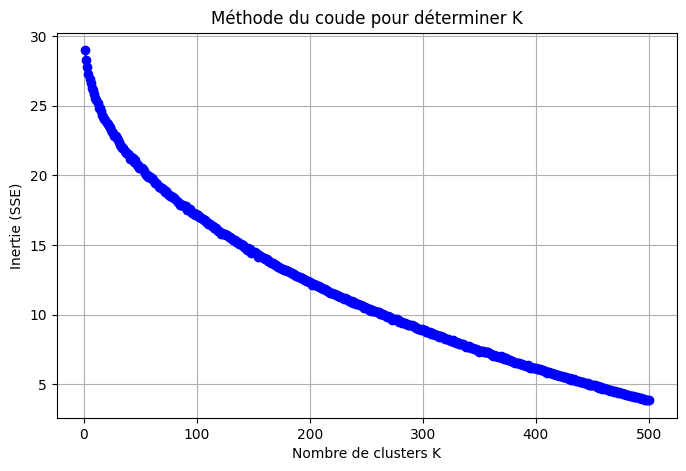

Meilleur modèle K-Means trouvé avec K=201 et init='k-means++'
Performance du modèle sur jeu d'entrainement :
Valeur de la metrique : 0.138931
Erreur quadratique moyenne (MSE) : 0.000144
Racine de l'erreur quadratique moyenne (RMSE) : 0.012001
Corrélation entre les prédictions et les vraies valeurs : 0.1517


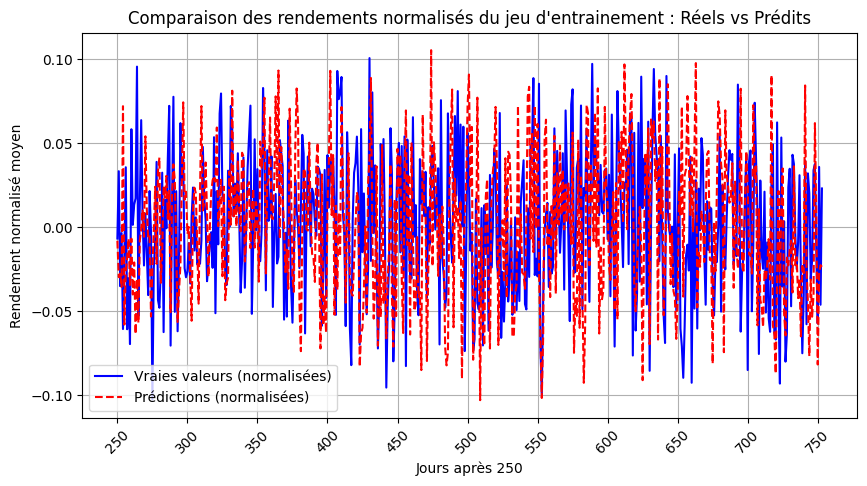

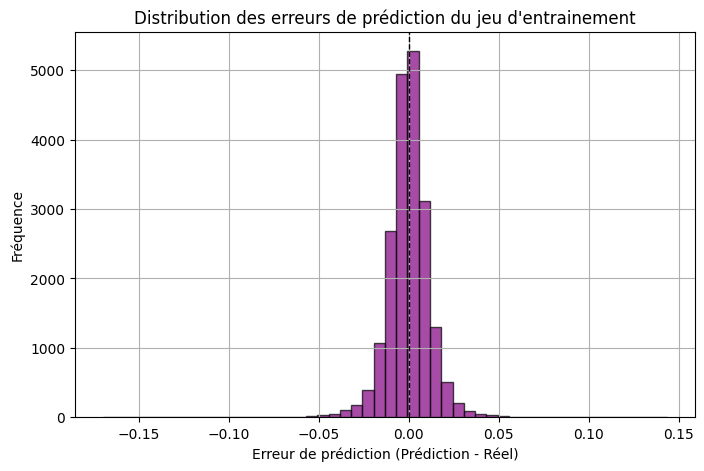

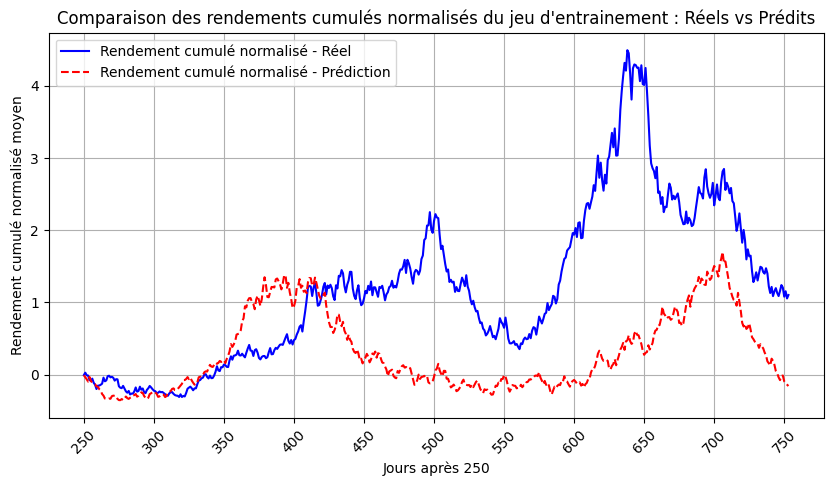

Performance du modèle sur jeu de test :
Valeur de la metrique : 0.003706
Erreur quadratique moyenne (MSE) : 0.000226
Racine de l'erreur quadratique moyenne (RMSE) : 0.015043
Corrélation entre les prédictions et les vraies valeurs : 0.0068


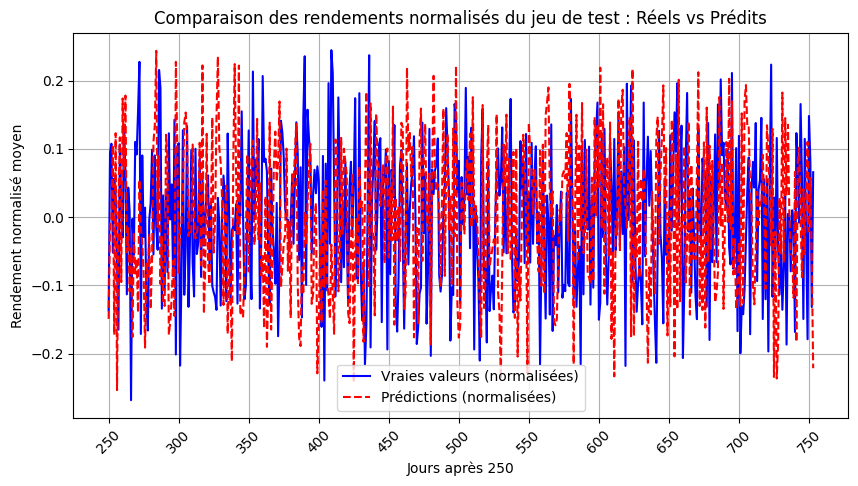

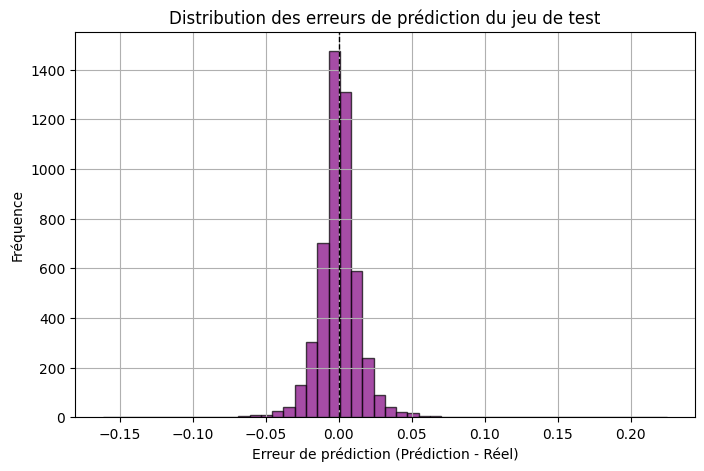

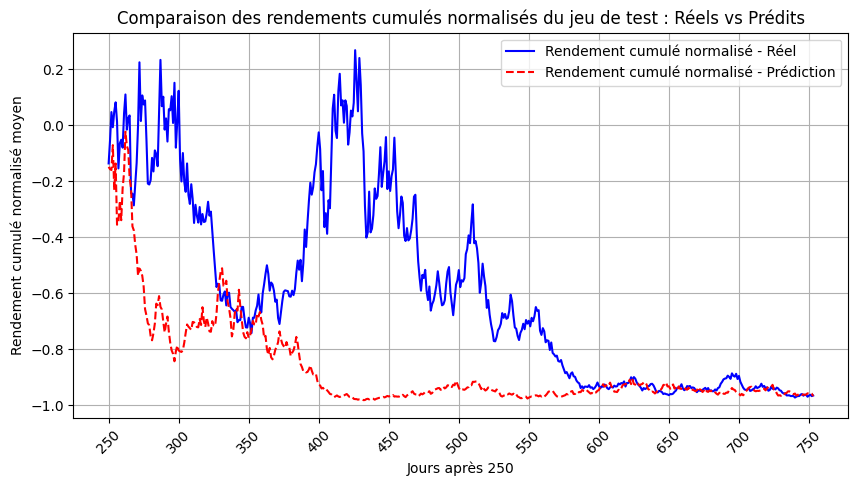

In [ ]:
#Lancement du clustering model
A = launch_clustering_model(X_train,Y_train)

# Evaluation du modèle sur le jeu de train
mse, correlation,beta = predict_and_evaluate_avec_normalisation(A, Y_train,X_train_reshape) 

# Evaluation du modèle sur le jeu de test
mse, correlation,_ = predict_and_evaluate_avec_normalisation(A, Y_test,X_test_reshape,beta = beta,istrain=False) 




La méthode K-Means nous donne des résultats plutôt satisfaisants sur le plan quantitatif. En effet, sur le jeu de données d'entraînement, avec un 𝑘 = 201, on obtient une métrique de 0,138931, nettement supérieure à celle du benchmark (0,054543). Sur le jeu de données test, la métrique est de 0,003706, également nettement supérieure au benchmark (0,000493). Graphiquement, on observe que certaines tendances sont correctement captées, notamment au début des prédictions. Toutefois, plus la plage de données s'étend, plus les erreurs de prédiction s'accumulent.

## Partie V - Modèles Supervisés

- Le clustering (K-Means) suppose implicitement que les rendements suivent une certaine structure géométrique (ex. groupes homogènes).
En réalité, les dynamiques de marché sont souvent non linéaires et dépendantes du temps.
- Un modèle de Boosting (comme XGBoost) apprend directement la relation entre les facteurs et les rendements en capturant des interactions non linéaires complexes.

## Modèle Supervisé I : Boosting

XGBoost (Extreme Gradient Boosting) est un algorithme d’apprentissage supervisé basé sur un ensemble d’arbres de décision entraînés séquentiellement. Contrairement à un arbre de décision classique qui effectue une seule prédiction, XGBoost ajoute progressivement plusieurs arbres, où chaque nouvel arbre est entraîné pour corriger les erreurs des arbres précédents.

Dans notre cas, XGBoost est utilisé pour modéliser la relation entre les rendements passés et les facteurs latents de marché. Le modèle commence par un premier arbre qui fait une prédiction initiale des rendements futurs. Ensuite, un second arbre est entraîné pour prédire les erreurs (résidus) du premier, et ainsi de suite. À la fin du processus, la prédiction finale est obtenue en combinant les prédictions de tous les arbres. Cette approche pourrait être intéressante pour mieux capturer la sous-estimation des tendances (et donc ajuster le biais des précédents modèles) des rendements cumulés notamment en ajustant progressivement les erreurs de prédictions précédentes.

Afin d’assurer la robustesse et la généralisation du modèle, nous mettons  en place une validation croisée manuelle (K-Fold Cross Validation). Cette technique consiste à diviser le jeu de données en K sous-ensembles, et à entraîner XGBoost K fois, en utilisant chaque fois K-1 sous-ensembles pour l’entraînement et le dernier pour la validation. Cette approche permet de moyenner les performances du modèle sur plusieurs découpages de données, évitant ainsi qu’il ne s’adapte trop fortement à un seul jeu de données spécifique (overfitting).

De plus, nous avons mis en place une optimisation des hyperparamètres afin de sélectionner les meilleures configurations du modèle. Nous utilisons ParameterGrid, qui teste différentes combinaisons de paramètres tels que :

- Le nombre d’arbres (n_estimators) : Ajuste la complexité du modèle.
- Le taux d’apprentissage (learning_rate) : Contrôle la vitesse d’adaptation du modèle.
- La profondeur des arbres (max_depth) : Détermine le niveau de détail que chaque arbre peut capturer.
- Le sous-échantillonnage (subsample) : Réduit le risque d’overfitting en utilisant une fraction des données à chaque itération.
- Le nombre de caractéristiques utilisées (colsample_bytree) : Sélectionne un sous-ensemble de variables à chaque split d’un arbre.
Chaque combinaison d’hyperparamètres est évaluée à l’aide de la validation croisée, et le modèle ayant le meilleur score moyen est retenu. Pour éviter d’entraîner des modèles inutiles, j’ai aussi utilisé early_stopping_rounds, qui stoppe l’entraînement si le modèle ne s’améliore plus après un certain nombre d’itérations.

Enfin, après l’optimisation, on extrais les facteurs de marché en utilisant les valeurs des feuilles des arbres XGBoost, qu'on réduis avec PCA pour ne garder que les 10 facteurs les plus pertinents. Ces facteurs sont ensuite utilisés dans une régression linéaire pour prédire les rendements futurs.



In [2]:
# Permet d’afficher des messages de suivi à chaque étape du programme.
def log(message):
    print(f"{message}...")

# Préparation des données
def prepare_data(X_train, Y_train):
    log("Préparation des données")
    X_train_set = X_train.iloc[:, :250].T 
    Y_train_set = Y_train.T
    return X_train_set, Y_train_set


# Optimisation de XGBoost avec validation croisée manuelle
def optimize_xgboost(X_train,Y_train, n_splits=3, istrat:bool = False):
    log("Optimisation du modèle avec validation croisée")

    # Définition des hyperparamètres à tester
    param_grid = {
         'n_estimators': [50,100,200],  
         'learning_rate': [0.01, 0.1, 0.2],  
         'max_depth': [3, 5, 7],  
         'subsample': [0.8, 1],  
         'colsample_bytree': [0.8, 1]  
    }

    best_model = None
    best_score = float('inf')
    best_params = None

    offset = X_train.shape[1] - Y_train.shape[1]
    # Création de la validation croisée (K-Fold)
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Boucle sur toutes les combinaisons d’hyperparamètres
    for params in tqdm(ParameterGrid(param_grid), desc="Test d'hyperparamètres"):
        if istrat == False : print(f"Test : {params}")  # Affichage des hyperparamètres en direct

        scores = []

        if not istrat:
            #Validation croisée 
            for train_index, valid_index in kf.split(X_train):
                X_train_split = X_train.iloc[train_index]
                X_valid_split = X_train.iloc[valid_index]
                Y_train_split = Y_train.iloc[train_index]
                Y_valid_split = Y_train.iloc[valid_index]

        else :
            # Ici X_train est plus long que Y_train (ex. 250 vs 50)
            offset = X_train.shape[0] - Y_train.shape[0]
            # On split sur Y_train (la plus courte)
            for train_index, valid_index in kf.split(Y_train):
                Y_train_split = Y_train.iloc[train_index]
                Y_valid_split = Y_train.iloc[valid_index]
                # Pour X_train, on décale les indices de +offset
                X_train_split = X_train.iloc[[i + offset for i in train_index]]
                X_valid_split = X_train.iloc[[i + offset for i in valid_index]]


        # Création du modèle avec les hyperparamètres actuels
        model = xgb.XGBRegressor(
            objective="reg:squarederror", 
            random_state=42, 
            verbosity=1,  
            early_stopping_rounds=10,  # Arrêt anticipé si pas d'amélioration
            **params
        )
        
        # Entraînement avec le jeu de train pour early stopping
        model.fit(X_train_split, Y_train_split, eval_set=[(X_valid_split, Y_valid_split)], verbose=False)

        # Évaluation sur le jeu de validation
        score = mean_squared_error(Y_valid_split, model.predict(X_valid_split))
        scores.append(score)

        # Moyenne des scores de validation
        mean_score = np.mean(scores)

        # Mise à jour du meilleur modèle
        if mean_score < best_score:
            best_score = mean_score
            best_model = model
            best_params = params

    print(f"Meilleurs paramètres trouvés : {best_params}")
    return best_model

# Extraction des facteurs après optimisation
def extract_factors_from_xgboost(model, X_train,n_factors=10):
    log("Extraction des facteurs à partir de XGBoost")

    A_xgb = model.apply(X_train) # Extrait les valeurs des feuilles de chaque arbre comme nouveaux facteurs.

    # Réduction avec PCA pour ne pas avoir trop de facteurs
    pca = PCA(n_components=n_factors)
    A_reduced = pca.fit_transform(A_xgb)  # (250, n_factors)

    A_reduced, _ = np.linalg.qr(A_reduced) # Orthonormalise les facteurs.
    return A_reduced


def launch_xgboost_model(X_train,Y_train,istrat:bool = False):
    log("Début du processus")

    X_train_set,Y_train_set = prepare_data(X_train,Y_train)
    xgb_best_model = optimize_xgboost(X_train_set,Y_train_set,istrat=istrat)
    A = extract_factors_from_xgboost(xgb_best_model, X_train_set, n_factors=10)

    print(A.shape)

    log("Processus terminé !")

    return A


Début du processus...
Préparation des données...
Optimisation du modèle avec validation croisée...


Test d'hyperparamètres:   0%|          | 0/108 [00:00<?, ?it/s]

Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
Test d'hyperparamètres:   2%|▏         | 2/108 [00:00<00:26,  3.99it/s]

Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1}
Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


Test d'hyperparamètres:   4%|▎         | 4/108 [00:00<00:22,  4.62it/s]

Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1}
Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


Test d'hyperparamètres:   6%|▌         | 6/108 [00:01<00:21,  4.81it/s]

Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1}
Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}


Test d'hyperparamètres:   6%|▋         | 7/108 [00:01<00:31,  3.18it/s]

Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50, 'subsample': 1}


Test d'hyperparamètres:   7%|▋         | 8/108 [00:02<00:32,  3.04it/s]

Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}


Test d'hyperparamètres:   8%|▊         | 9/108 [00:02<00:36,  2.70it/s]

Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1}


Test d'hyperparamètres:   9%|▉         | 10/108 [00:03<00:35,  2.79it/s]

Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}


Test d'hyperparamètres:  10%|█         | 11/108 [00:03<00:38,  2.53it/s]

Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1}


Test d'hyperparamètres:  11%|█         | 12/108 [00:03<00:36,  2.60it/s]

Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}


Test d'hyperparamètres:  12%|█▏        | 13/108 [00:04<00:41,  2.27it/s]

Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 50, 'subsample': 1}


Test d'hyperparamètres:  13%|█▎        | 14/108 [00:05<00:45,  2.08it/s]

Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}


Test d'hyperparamètres:  14%|█▍        | 15/108 [00:05<00:46,  2.01it/s]

Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100, 'subsample': 1}


Test d'hyperparamètres:  15%|█▍        | 16/108 [00:06<00:48,  1.89it/s]

Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}


Test d'hyperparamètres:  16%|█▌        | 17/108 [00:06<00:49,  1.83it/s]

Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1}


Test d'hyperparamètres:  18%|█▊        | 19/108 [00:07<00:40,  2.22it/s]

Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1}


Test d'hyperparamètres:  19%|█▉        | 21/108 [00:07<00:28,  3.08it/s]

Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1}


Test d'hyperparamètres:  21%|██▏       | 23/108 [00:08<00:22,  3.82it/s]

Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1}


Test d'hyperparamètres:  22%|██▏       | 24/108 [00:08<00:20,  4.18it/s]

Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}


Test d'hyperparamètres:  23%|██▎       | 25/108 [00:08<00:25,  3.32it/s]

Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 1}


Test d'hyperparamètres:  24%|██▍       | 26/108 [00:09<00:26,  3.09it/s]

Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}


Test d'hyperparamètres:  25%|██▌       | 27/108 [00:09<00:27,  2.93it/s]

Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1}


Test d'hyperparamètres:  26%|██▌       | 28/108 [00:10<00:27,  2.87it/s]

Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}


Test d'hyperparamètres:  27%|██▋       | 29/108 [00:10<00:28,  2.82it/s]

Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1}


Test d'hyperparamètres:  28%|██▊       | 30/108 [00:10<00:28,  2.75it/s]

Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}


Test d'hyperparamètres:  29%|██▊       | 31/108 [00:11<00:37,  2.06it/s]

Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50, 'subsample': 1}


Test d'hyperparamètres:  30%|██▉       | 32/108 [00:12<00:41,  1.83it/s]

Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}


Test d'hyperparamètres:  31%|███       | 33/108 [00:12<00:40,  1.86it/s]

Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 1}


Test d'hyperparamètres:  31%|███▏      | 34/108 [00:13<00:43,  1.70it/s]

Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}


Test d'hyperparamètres:  32%|███▏      | 35/108 [00:14<00:42,  1.70it/s]

Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1}


Test d'hyperparamètres:  34%|███▍      | 37/108 [00:14<00:34,  2.09it/s]

Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1}


Test d'hyperparamètres:  36%|███▌      | 39/108 [00:15<00:22,  3.01it/s]

Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1}


Test d'hyperparamètres:  37%|███▋      | 40/108 [00:15<00:19,  3.47it/s]

Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


Test d'hyperparamètres:  38%|███▊      | 41/108 [00:15<00:17,  3.77it/s]

Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1}


Test d'hyperparamètres:  39%|███▉      | 42/108 [00:15<00:16,  4.03it/s]

Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}


Test d'hyperparamètres:  40%|███▉      | 43/108 [00:16<00:19,  3.38it/s]

Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 50, 'subsample': 1}


Test d'hyperparamètres:  41%|████      | 44/108 [00:16<00:20,  3.11it/s]

Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}


Test d'hyperparamètres:  42%|████▏     | 45/108 [00:17<00:21,  2.98it/s]

Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1}


Test d'hyperparamètres:  43%|████▎     | 46/108 [00:17<00:21,  2.93it/s]

Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}


Test d'hyperparamètres:  44%|████▎     | 47/108 [00:17<00:21,  2.88it/s]

Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1}


Test d'hyperparamètres:  44%|████▍     | 48/108 [00:18<00:20,  2.91it/s]

Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}


Test d'hyperparamètres:  45%|████▌     | 49/108 [00:18<00:22,  2.59it/s]

Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 50, 'subsample': 1}


Test d'hyperparamètres:  46%|████▋     | 50/108 [00:19<00:25,  2.30it/s]

Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}


Test d'hyperparamètres:  47%|████▋     | 51/108 [00:19<00:26,  2.16it/s]

Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 100, 'subsample': 1}


Test d'hyperparamètres:  48%|████▊     | 52/108 [00:20<00:27,  2.04it/s]

Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}


Test d'hyperparamètres:  49%|████▉     | 53/108 [00:20<00:27,  2.01it/s]

Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1}


Test d'hyperparamètres:  50%|█████     | 54/108 [00:21<00:29,  1.81it/s]

Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}


Test d'hyperparamètres:  51%|█████     | 55/108 [00:21<00:25,  2.08it/s]

Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1}


Test d'hyperparamètres:  52%|█████▏    | 56/108 [00:21<00:20,  2.50it/s]

Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


Test d'hyperparamètres:  53%|█████▎    | 57/108 [00:22<00:19,  2.59it/s]

Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1}


Test d'hyperparamètres:  54%|█████▎    | 58/108 [00:22<00:16,  3.01it/s]

Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


Test d'hyperparamètres:  56%|█████▌    | 60/108 [00:23<00:14,  3.41it/s]

Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1}
Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}


Test d'hyperparamètres:  56%|█████▋    | 61/108 [00:23<00:16,  2.88it/s]

Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50, 'subsample': 1}


Test d'hyperparamètres:  57%|█████▋    | 62/108 [00:23<00:16,  2.76it/s]

Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}


Test d'hyperparamètres:  58%|█████▊    | 63/108 [00:24<00:17,  2.54it/s]

Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1}


Test d'hyperparamètres:  59%|█████▉    | 64/108 [00:24<00:17,  2.46it/s]

Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}


Test d'hyperparamètres:  60%|██████    | 65/108 [00:25<00:18,  2.34it/s]

Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1}


Test d'hyperparamètres:  61%|██████    | 66/108 [00:25<00:17,  2.40it/s]

Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}


Test d'hyperparamètres:  62%|██████▏   | 67/108 [00:26<00:21,  1.89it/s]

Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 50, 'subsample': 1}


Test d'hyperparamètres:  63%|██████▎   | 68/108 [00:27<00:23,  1.68it/s]

Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}


Test d'hyperparamètres:  64%|██████▍   | 69/108 [00:28<00:25,  1.50it/s]

Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100, 'subsample': 1}


Test d'hyperparamètres:  65%|██████▍   | 70/108 [00:28<00:25,  1.50it/s]

Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}


Test d'hyperparamètres:  66%|██████▌   | 71/108 [00:29<00:26,  1.41it/s]

Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1}


Test d'hyperparamètres:  67%|██████▋   | 72/108 [00:30<00:25,  1.40it/s]

Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}


Test d'hyperparamètres:  68%|██████▊   | 73/108 [00:30<00:19,  1.77it/s]

Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1}


Test d'hyperparamètres:  69%|██████▊   | 74/108 [00:30<00:15,  2.15it/s]

Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


Test d'hyperparamètres:  69%|██████▉   | 75/108 [00:30<00:12,  2.57it/s]

Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1}


Test d'hyperparamètres:  70%|███████   | 76/108 [00:31<00:10,  2.97it/s]

Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


Test d'hyperparamètres:  71%|███████▏  | 77/108 [00:31<00:09,  3.28it/s]

Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1}


Test d'hyperparamètres:  72%|███████▏  | 78/108 [00:31<00:08,  3.63it/s]

Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}


Test d'hyperparamètres:  73%|███████▎  | 79/108 [00:31<00:08,  3.26it/s]

Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 1}


Test d'hyperparamètres:  74%|███████▍  | 80/108 [00:32<00:09,  3.01it/s]

Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}


Test d'hyperparamètres:  75%|███████▌  | 81/108 [00:32<00:09,  2.88it/s]

Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1}


Test d'hyperparamètres:  76%|███████▌  | 82/108 [00:33<00:09,  2.79it/s]

Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}


Test d'hyperparamètres:  77%|███████▋  | 83/108 [00:33<00:09,  2.71it/s]

Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1}


Test d'hyperparamètres:  78%|███████▊  | 84/108 [00:33<00:08,  2.68it/s]

Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}


Test d'hyperparamètres:  79%|███████▊  | 85/108 [00:34<00:10,  2.24it/s]

Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50, 'subsample': 1}


Test d'hyperparamètres:  80%|███████▉  | 86/108 [00:35<00:11,  1.96it/s]

Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}


Test d'hyperparamètres:  81%|████████  | 87/108 [00:35<00:11,  1.86it/s]

Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 1}


Test d'hyperparamètres:  81%|████████▏ | 88/108 [00:36<00:11,  1.76it/s]

Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}


Test d'hyperparamètres:  82%|████████▏ | 89/108 [00:37<00:11,  1.72it/s]

Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1}


Test d'hyperparamètres:  83%|████████▎ | 90/108 [00:37<00:10,  1.65it/s]

Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}


Test d'hyperparamètres:  84%|████████▍ | 91/108 [00:37<00:08,  2.05it/s]

Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1}


Test d'hyperparamètres:  85%|████████▌ | 92/108 [00:38<00:06,  2.44it/s]

Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


Test d'hyperparamètres:  86%|████████▌ | 93/108 [00:38<00:05,  2.84it/s]

Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1}


Test d'hyperparamètres:  87%|████████▋ | 94/108 [00:38<00:04,  3.18it/s]

Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


Test d'hyperparamètres:  88%|████████▊ | 95/108 [00:38<00:03,  3.56it/s]

Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1}


Test d'hyperparamètres:  89%|████████▉ | 96/108 [00:39<00:03,  3.85it/s]

Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}


Test d'hyperparamètres:  90%|████████▉ | 97/108 [00:39<00:03,  3.36it/s]

Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 50, 'subsample': 1}


Test d'hyperparamètres:  91%|█████████ | 98/108 [00:39<00:03,  2.98it/s]

Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}


Test d'hyperparamètres:  92%|█████████▏| 99/108 [00:40<00:03,  2.85it/s]

Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1}


Test d'hyperparamètres:  93%|█████████▎| 100/108 [00:40<00:02,  2.82it/s]

Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}


Test d'hyperparamètres:  94%|█████████▎| 101/108 [00:40<00:02,  2.80it/s]

Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1}


Test d'hyperparamètres:  94%|█████████▍| 102/108 [00:41<00:02,  2.59it/s]

Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}


Test d'hyperparamètres:  95%|█████████▌| 103/108 [00:41<00:02,  2.20it/s]

Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 50, 'subsample': 1}


Test d'hyperparamètres:  96%|█████████▋| 104/108 [00:42<00:02,  1.92it/s]

Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}


Test d'hyperparamètres:  97%|█████████▋| 105/108 [00:43<00:01,  1.83it/s]

Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 100, 'subsample': 1}


Test d'hyperparamètres:  98%|█████████▊| 106/108 [00:43<00:01,  1.74it/s]

Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}


Test d'hyperparamètres:  99%|█████████▉| 107/108 [00:44<00:00,  1.71it/s]

Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1}


Test d'hyperparamètres: 100%|██████████| 108/108 [00:45<00:00,  2.39it/s]


Meilleurs paramètres trouvés : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}
Extraction des facteurs à partir de XGBoost...


ERROR:tornado.general:SEND Error: Host unreachable


(250, 10)
Processus terminé !...
Performance du modèle sur jeu d'entrainement :
Valeur de la metrique : 0.040381
Erreur quadratique moyenne (MSE) : 0.000147
Racine de l'erreur quadratique moyenne (RMSE) : 0.012131
Corrélation entre les prédictions et les vraies valeurs : 0.0437


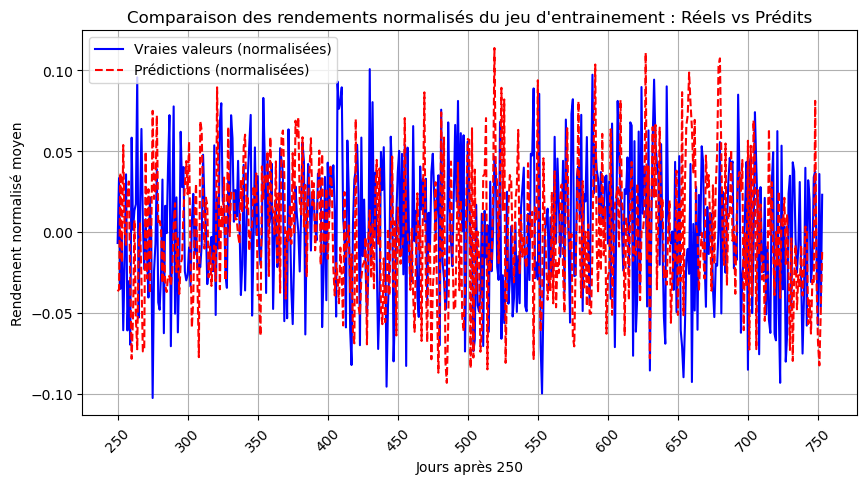

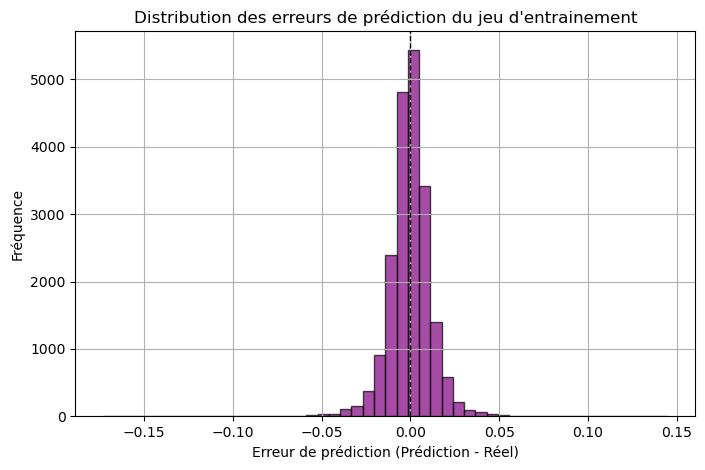

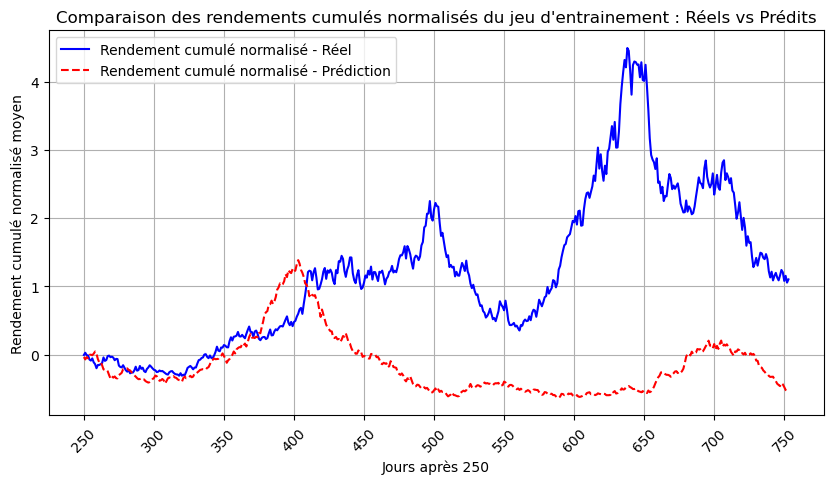

Performance du modèle sur jeu de test :
Valeur de la metrique : 0.020606
Erreur quadratique moyenne (MSE) : 0.000222
Racine de l'erreur quadratique moyenne (RMSE) : 0.014901
Corrélation entre les prédictions et les vraies valeurs : 0.0082


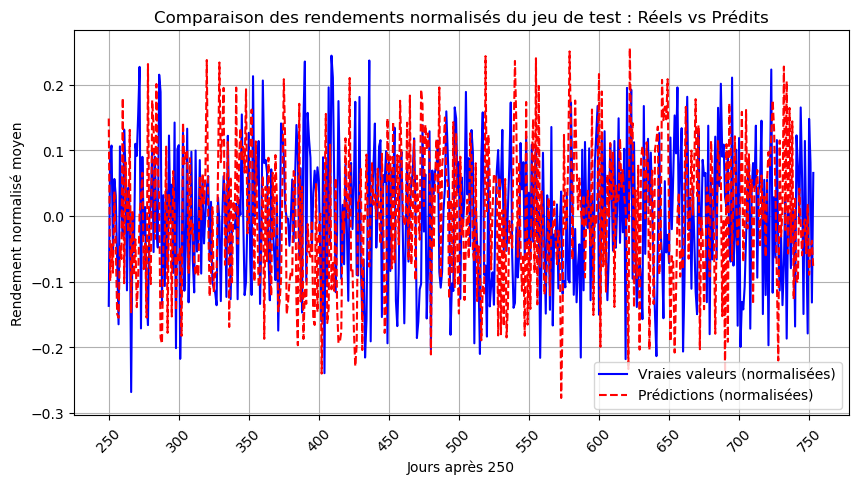

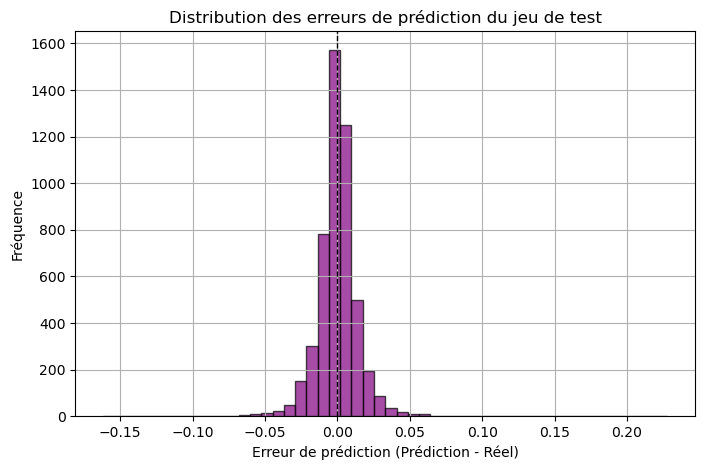

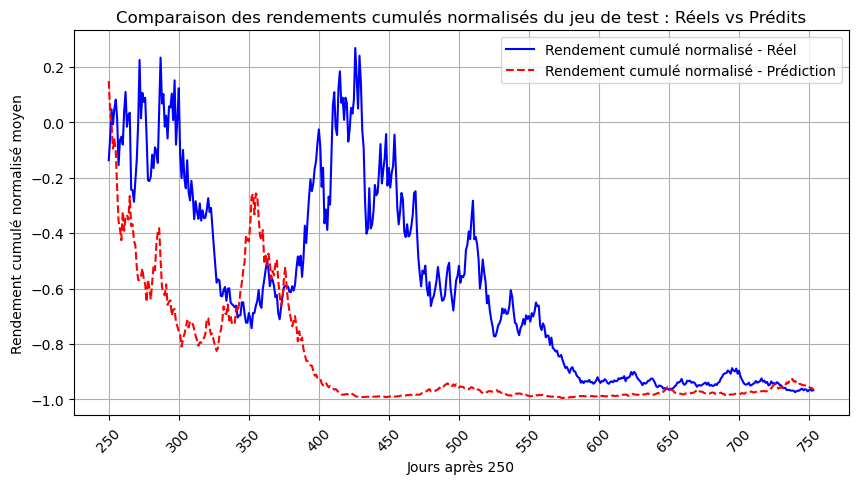

In [11]:
#Lancement du modèle XGBoost
A= launch_xgboost_model(X_train,Y_train)

# Evaluation du modèle sur le jeu de train
mse, correlation,beta = predict_and_evaluate_avec_normalisation(A, Y_train,X_train_reshape)

# Evaluation du modèle sur le jeu de test
mse, correlation,_ = predict_and_evaluate_avec_normalisation(A, Y_test,X_test_reshape,beta = beta, istrain=False) 

Les résultats obtenus avec le modèle XGBoost sont intéressants, car, même si la performance quantitative sur le jeu d'entraînement est inférieure au benchmark (0,040381), indiquant moins d'overfitting, les résultats graphiques demeurent intéressants, notamment sur la première période de prédiction.
Sur le jeu de test, la métrique obtenue est satisfaisante (0,020606), représentant ainsi la meilleure performance jusqu'à présent.

## Modèle Supervisé II : Bagging
Le Bagging (Bootstrap Aggregating) est une méthode d’ensemble qui entraîne plusieurs modèles indépendants sur des échantillons bootstrap des données. Contrairement au Boosting, qui corrige itérativement les erreurs des modèles précédents, le Bagging entraîne ses modèles en parallèle et moyenne leurs prédictions pour réduire la variance.

Dans notre cas, Bagging est utilisé pour modéliser la relation entre les rendements passés et les facteurs latents de marché. Chaque modèle du Bagging est un arbre de décision, entraîné sur des sous-échantillons des données. L’objectif est d’obtenir un modèle robuste, réduisant la variance tout en capturant des structures complexes dans les données. La ou le boosting ne permettait pas de réussir à ajuster les erreur de prediction de tendance (plutôt des correctifs locaux), le bagging pourrait éventuellement mieux généraliser les tendances à l'aide de différents échantillons entrainés indépendamment et donc mieux représenter des sous-régimes.

Afin d’assurer la robustesse et la généralisation du modèle, nous utilisons une validation croisée (K-Fold Cross Validation). Cette technique permet d’évaluer la stabilité du modèle en testant plusieurs découpages des données.
Nous optimisons également les hyperparamètres via une recherche sur grille (ParameterGrid), en testant différentes valeurs de :

- n_estimators : Nombre d’arbres dans le modèle Bagging.
- max_samples : Proportion de l’échantillon utilisée par chaque arbre.
- max_features : Nombre de variables utilisées pour chaque modèle.

Enfin, après l’optimisation, nous extrayons les facteurs de marché en utilisant les prédictions des modèles entraînés, puis nous appliquons une réduction dimensionnelle via PCA pour conserver uniquement les 10 facteurs les plus pertinents.


In [1]:
# Optimisation du modèle Bagging avec validation croisée (K-Fold)
def optimize_bagging(X_train, Y_train, n_splits=3,istrat:bool = False):
    log("Optimisation du modèle avec validation croisée K-Fold")

    param_grid = {
        'n_estimators': [50, 300, 500],  # Nombre d'arbres
        'max_samples': [0.5, 0.7, 1.0],  # Échantillonnage bootstrap
        'max_features': [0.5, 0.7, 1.0],  # Sélection aléatoire de features
        'bootstrap': [True],  # Bootstrap
    }

    best_model = None
    best_score = float('inf')
    best_params = None

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Test de toutes les combinaisons d’hyperparamètres
    for params in tqdm(ParameterGrid(param_grid), desc="Test d'hyperparamètres"):
        if istrat == False : print(f"Test : {params}")

        scores = []

        if not istrat:
        #Validation croisée 
            for train_index, valid_index in kf.split(X_train):
                X_train_split = X_train.iloc[train_index]
                X_valid_split = X_train.iloc[valid_index]
                Y_train_split = Y_train.iloc[train_index]
                Y_valid_split = Y_train.iloc[valid_index]

        else :
            # Ici X_train est plus long que Y_train (ex. 250 vs 50)
            offset = X_train.shape[0] - Y_train.shape[0]
            # On split sur Y_train (la plus courte)
            for train_index, valid_index in kf.split(Y_train):
                Y_train_split = Y_train.iloc[train_index]
                Y_valid_split = Y_train.iloc[valid_index]
                # Pour X_train, on décale les indices de +offset
                X_train_split = X_train.iloc[[i + offset for i in train_index]]
                X_valid_split = X_train.iloc[[i + offset for i in valid_index]]


        # Création du modèle avec les hyperparamètres actuels
        model = BaggingRegressor(
        estimator=DecisionTreeRegressor(),
        random_state=42,
        **params
        )
                
        # Entraînement avec le jeu de validation pour early stopping
        model.fit(X_train_split, Y_train_split)

        # Évaluation sur le jeu de validation
        score = mean_squared_error(Y_valid_split, model.predict(X_valid_split))
        scores.append(score)

        mean_score = np.mean(scores)

        # Mise à jour du meilleur modèle
        if mean_score < best_score:
            best_score = mean_score
            best_model = model
            best_params = params

    print(f"Meilleurs paramètres trouvés : {best_params}")
    return best_model

# Extraction des facteurs via Bagging et réduction avec PCA
def extract_factors_from_bagging(model, X_train, n_factors=10):
    log("Extraction des facteurs à partir de Bagging")

    A_bagging = model.predict(X_train)  # On prend les prédictions comme nouveaux facteurs

    # Réduction avec PCA
    pca = PCA(n_components=n_factors)
    A_reduced = pca.fit_transform(A_bagging)

    A_reduced, _ = np.linalg.qr(A_reduced)  # Orthonormalisation
    return A_reduced

def launch_bagging_model(X_train,Y_train,istrat:bool = False):
    log("Début du processus")

    X_train_set, Y_train_set = prepare_data(X_train, Y_train)

    bagging_best_model = optimize_bagging(X_train_set, Y_train_set,istrat=istrat)

    A = extract_factors_from_bagging(bagging_best_model, X_train_set, n_factors=10)

    print(A.shape)

    log("Processus terminé !")

    return A


Début du processus...
Préparation des données...
Optimisation du modèle avec validation croisée K-Fold...


Test d'hyperparamètres:   4%|▎         | 1/27 [00:00<00:03,  6.78it/s]

Test : {'bootstrap': True, 'max_features': 0.5, 'max_samples': 0.5, 'n_estimators': 50}
Test : {'bootstrap': True, 'max_features': 0.5, 'max_samples': 0.5, 'n_estimators': 300}


Test d'hyperparamètres:   7%|▋         | 2/27 [00:00<00:13,  1.84it/s]

Test : {'bootstrap': True, 'max_features': 0.5, 'max_samples': 0.5, 'n_estimators': 500}


Test d'hyperparamètres:  15%|█▍        | 4/27 [00:02<00:14,  1.57it/s]

Test : {'bootstrap': True, 'max_features': 0.5, 'max_samples': 0.7, 'n_estimators': 50}
Test : {'bootstrap': True, 'max_features': 0.5, 'max_samples': 0.7, 'n_estimators': 300}


Test d'hyperparamètres:  19%|█▊        | 5/27 [00:03<00:16,  1.34it/s]

Test : {'bootstrap': True, 'max_features': 0.5, 'max_samples': 0.7, 'n_estimators': 500}


Test d'hyperparamètres:  26%|██▌       | 7/27 [00:05<00:15,  1.32it/s]

Test : {'bootstrap': True, 'max_features': 0.5, 'max_samples': 1.0, 'n_estimators': 50}
Test : {'bootstrap': True, 'max_features': 0.5, 'max_samples': 1.0, 'n_estimators': 300}


Test d'hyperparamètres:  30%|██▉       | 8/27 [00:06<00:16,  1.13it/s]

Test : {'bootstrap': True, 'max_features': 0.5, 'max_samples': 1.0, 'n_estimators': 500}


Test d'hyperparamètres:  37%|███▋      | 10/27 [00:08<00:14,  1.15it/s]

Test : {'bootstrap': True, 'max_features': 0.7, 'max_samples': 0.5, 'n_estimators': 50}
Test : {'bootstrap': True, 'max_features': 0.7, 'max_samples': 0.5, 'n_estimators': 300}


Test d'hyperparamètres:  41%|████      | 11/27 [00:09<00:14,  1.14it/s]

Test : {'bootstrap': True, 'max_features': 0.7, 'max_samples': 0.5, 'n_estimators': 500}


Test d'hyperparamètres:  44%|████▍     | 12/27 [00:10<00:16,  1.08s/it]

Test : {'bootstrap': True, 'max_features': 0.7, 'max_samples': 0.7, 'n_estimators': 50}


Test d'hyperparamètres:  48%|████▊     | 13/27 [00:11<00:11,  1.23it/s]

Test : {'bootstrap': True, 'max_features': 0.7, 'max_samples': 0.7, 'n_estimators': 300}


Test d'hyperparamètres:  52%|█████▏    | 14/27 [00:12<00:11,  1.12it/s]

Test : {'bootstrap': True, 'max_features': 0.7, 'max_samples': 0.7, 'n_estimators': 500}


Test d'hyperparamètres:  56%|█████▌    | 15/27 [00:13<00:14,  1.17s/it]

Test : {'bootstrap': True, 'max_features': 0.7, 'max_samples': 1.0, 'n_estimators': 50}


Test d'hyperparamètres:  59%|█████▉    | 16/27 [00:14<00:09,  1.13it/s]

Test : {'bootstrap': True, 'max_features': 0.7, 'max_samples': 1.0, 'n_estimators': 300}


Test d'hyperparamètres:  63%|██████▎   | 17/27 [00:15<00:10,  1.04s/it]

Test : {'bootstrap': True, 'max_features': 0.7, 'max_samples': 1.0, 'n_estimators': 500}


Test d'hyperparamètres:  70%|███████   | 19/27 [00:18<00:08,  1.08s/it]

Test : {'bootstrap': True, 'max_features': 1.0, 'max_samples': 0.5, 'n_estimators': 50}
Test : {'bootstrap': True, 'max_features': 1.0, 'max_samples': 0.5, 'n_estimators': 300}


Test d'hyperparamètres:  74%|███████▍  | 20/27 [00:19<00:07,  1.12s/it]

Test : {'bootstrap': True, 'max_features': 1.0, 'max_samples': 0.5, 'n_estimators': 500}


Test d'hyperparamètres:  78%|███████▊  | 21/27 [00:21<00:08,  1.34s/it]

Test : {'bootstrap': True, 'max_features': 1.0, 'max_samples': 0.7, 'n_estimators': 50}


Test d'hyperparamètres:  81%|████████▏ | 22/27 [00:21<00:05,  1.02s/it]

Test : {'bootstrap': True, 'max_features': 1.0, 'max_samples': 0.7, 'n_estimators': 300}


Test d'hyperparamètres:  85%|████████▌ | 23/27 [00:23<00:04,  1.16s/it]

Test : {'bootstrap': True, 'max_features': 1.0, 'max_samples': 0.7, 'n_estimators': 500}


Test d'hyperparamètres:  89%|████████▉ | 24/27 [00:25<00:04,  1.52s/it]

Test : {'bootstrap': True, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 50}


Test d'hyperparamètres:  93%|█████████▎| 25/27 [00:25<00:02,  1.15s/it]

Test : {'bootstrap': True, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 300}


Test d'hyperparamètres:  96%|█████████▋| 26/27 [00:27<00:01,  1.34s/it]

Test : {'bootstrap': True, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 500}


Test d'hyperparamètres: 100%|██████████| 27/27 [00:30<00:00,  1.13s/it]


Meilleurs paramètres trouvés : {'bootstrap': True, 'max_features': 0.7, 'max_samples': 0.5, 'n_estimators': 500}
Extraction des facteurs à partir de Bagging...
(250, 10)
Processus terminé !...
Performance du modèle sur jeu d'entrainement :
Valeur de la metrique : 0.028721
Erreur quadratique moyenne (MSE) : 0.000147
Racine de l'erreur quadratique moyenne (RMSE) : 0.012134
Corrélation entre les prédictions et les vraies valeurs : 0.0356


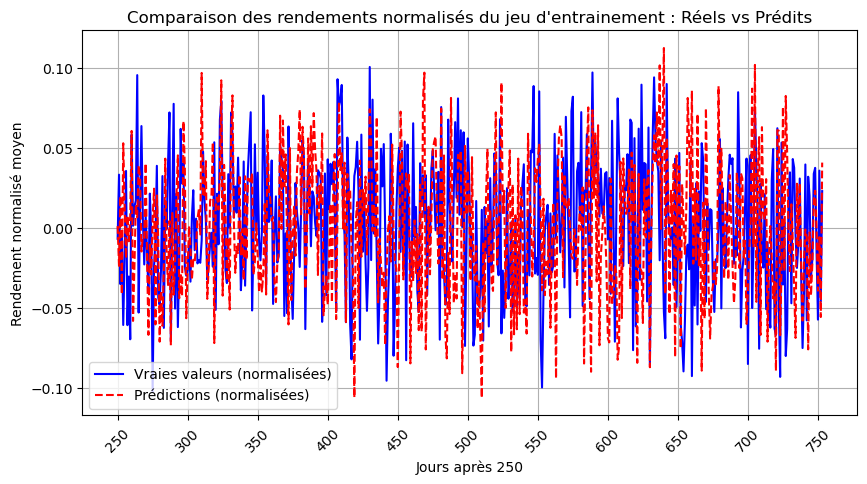

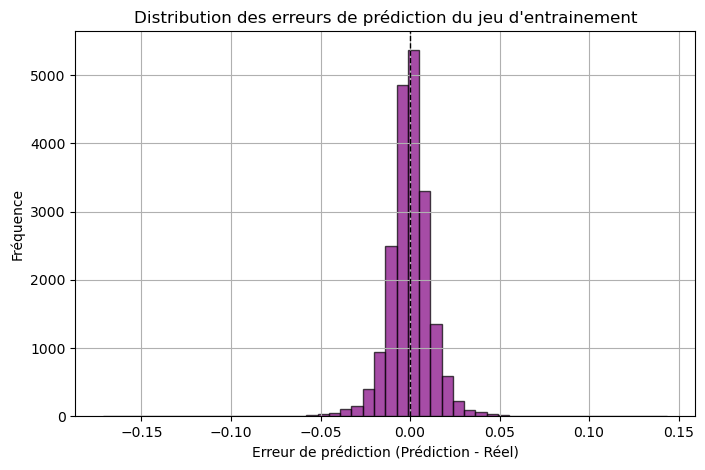

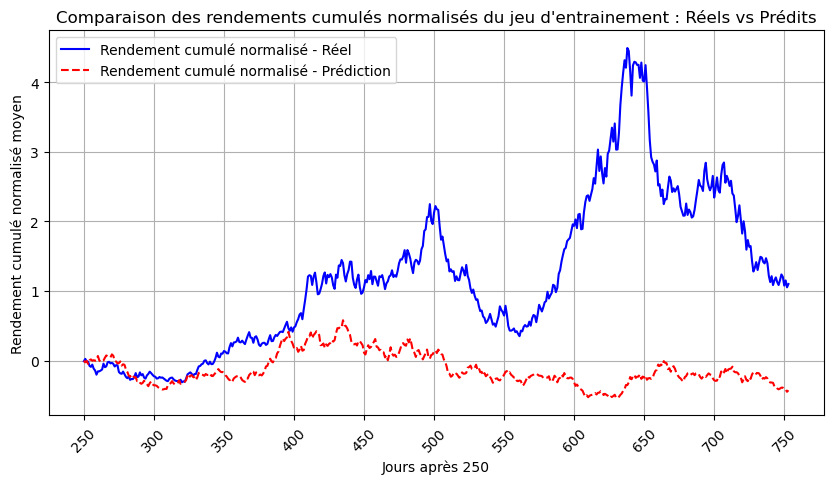

Performance du modèle sur jeu de test :
Valeur de la metrique : -0.009982
Erreur quadratique moyenne (MSE) : 0.000222
Racine de l'erreur quadratique moyenne (RMSE) : 0.014906
Corrélation entre les prédictions et les vraies valeurs : -0.0094


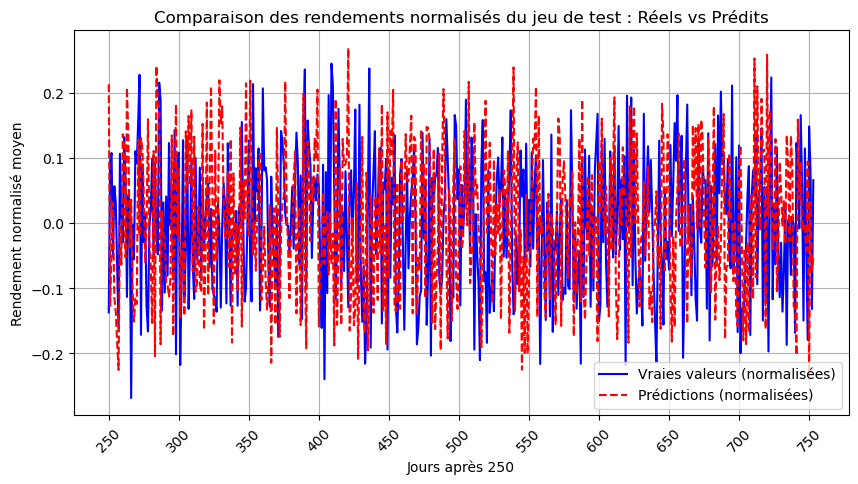

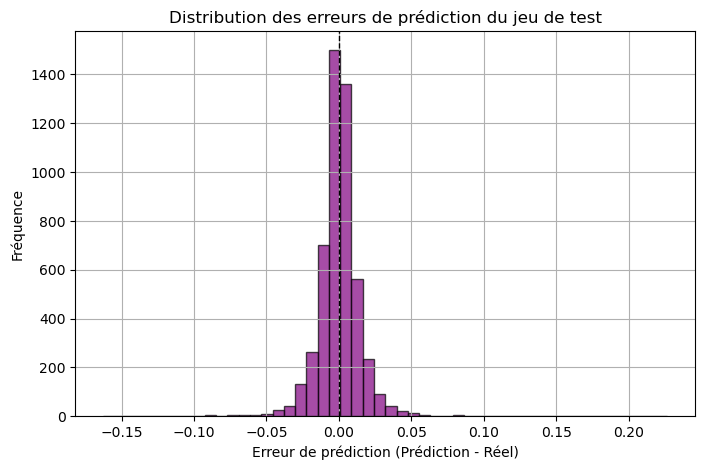

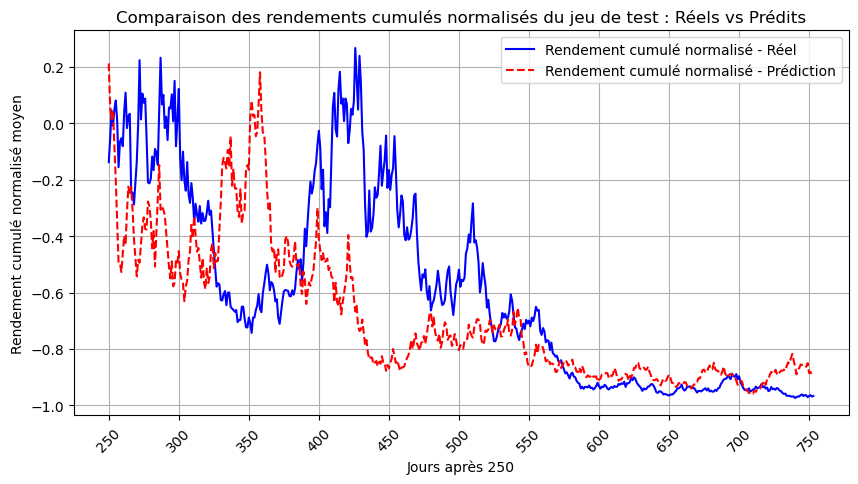

In [27]:
#Lancement du modèle Bagging
A = launch_bagging_model(X_train,Y_train)

# Evaluation du modèle sur le jeu de train
mse, correlation,beta = predict_and_evaluate_avec_normalisation(A, Y_train,X_train_reshape) 

# Evaluation du modèle sur le jeu de test
mse, correlation,_ = predict_and_evaluate_avec_normalisation(A, Y_test,X_test_reshape,beta = beta ,istrain=False) 



Le modèle Bagging présente des résultats très décevants, allant même à contre-tendance des valeurs réelles. En effet, il affiche une métrique extrêmement faible (-0,009982) sur le jeu de données test, indiquant une incapabilité à généraliser convenablement les dynamiques sous-jacentes du marché. Ce phénomène peut s'expliquer par une trop grande variance introduite par l’agrégation d’arbres individuels peu performants, ou encore par une inadéquation fondamentale entre la méthode Bagging (reposant principalement sur la réduction de variance) et la nature très bruitée et non linéaire des données financières considérées ici. Ainsi, cette approche ne semble pas adaptée à notre problématique actuelle, et il serait préférable d'explorer d'autres méthodes plus robustes aux spécificités des séries financières.

## Modèle Supervisé III : Random Forest
Le Random Forest est une méthode d’ensemble basée sur l’agrégation de plusieurs arbres de décision. Contrairement à un simple arbre de décision, qui est sujet au sur-apprentissage, Random Forest construit plusieurs arbres indépendants et moyenne leurs prédictions pour réduire la variance et améliorer la robustesse du modèle.

Dans notre cas, Random Forest est utilisé pour modéliser la relation entre les rendements passés et les facteurs latents du marché. Chaque arbre est entraîné sur un sous-échantillon des données, et une sélection aléatoire des variables est effectuée à chaque division (split). Cela permet d’introduire encore plus de diversité dans les modèles et d’éviter un sur-ajustement à certaines variables spécifiques avec le côté randomisé des sous ensembles des variables.

Afin d’assurer la robustesse et la généralisation du modèle, nous utilisons l’Out-Of-Bag (OOB) Score, qui permet d’évaluer la performance sans avoir recours à une validation croisée classique. L’OOB Score est calculé en utilisant les observations qui ne sont pas sélectionnées dans l’échantillonnage bootstrap, offrant ainsi une estimation fiable de l’erreur du modèle.

Nous optimisons également les hyperparamètres via une recherche sur grille (Grid Search), en testant différentes valeurs de :

n_estimators : Nombre d’arbres dans la forêt.
max_features : Nombre de variables considérées pour chaque split, avec des valeurs comme sqrt, log2 ou une fraction du nombre total de variables.
Enfin, après l’optimisation, nous extrayons les facteurs de marché en utilisant les prédictions du modèle entraîné, puis nous appliquons une réduction dimensionnelle via PCA pour conserver uniquement les 10 facteurs les plus pertinents.

In [12]:
# Optimisation du modèle Random Forest en utilisant OOB Score
def optimize_random_forest_oob(X_train, Y_train):
    log("Optimisation du modèle Random Forest avec OOB Score")

    param_grid = {
        'n_estimators': [50, 100, 300, 500],  # Nombre d'arbres
        'max_features': ['sqrt', 'log2', 0.5],  # Sélection aléatoire des features
        'max_samples': [0.8, 1.0],  # Ajout du sous-échantillonnage
        'bootstrap': [True]  # Activation du bootstrap
    }

    best_model = None
    best_oob_score = float('-inf')
    best_params = None

    for params in tqdm(ParameterGrid(param_grid), desc="Test d'hyperparamètres"):

        # Création du modèle avec les paramètres actuels
        model = RandomForestRegressor(
            oob_score=True,  # Activation du OOB Score
            random_state=42,
            #n_jobs=-1,  # Utilisation de tous les cœurs pour accélérer l'entraînement
            **params
        )

        model.fit(X_train, Y_train)  # OOB est calculé automatiquement

        # Vérification du OOB Score
        if hasattr(model, "oob_score_"):  # Parfois oob_score_ peut ne pas exister
            oob_score = model.oob_score_
        else:
            oob_score = float('-inf')

        if oob_score > best_oob_score:  # Maximisation du OOB Score
            best_oob_score = oob_score
            best_model = model
            best_params = params

    log(f"Meilleurs paramètres trouvés : {best_params} avec OOB Score = {best_oob_score:.4f}")
    return best_model

# Préparation des données, la méthode OOB implique d'avoir des dimensions d'échantillon identiques
def prepare_data(X_train, Y_train):
    log("Préparation des données")
    X_train_set = X_train.iloc[:, :250].T
    Y_train_set = Y_train.iloc[:, :250].T
    return X_train_set, Y_train_set

# Extraction des facteurs via Random Forest et réduction avec PCA
def extract_factors_from_rf(model, X_train, n_factors=10):
    log("Extraction des facteurs à partir de Random Forest")

    A_rf = model.predict(X_train)  # Prédictions utilisées comme facteurs

    # Réduction avec PCA
    pca = PCA(n_components=n_factors)
    A_reduced = pca.fit_transform(A_rf)

    A_reduced, _ = np.linalg.qr(A_reduced)  # Orthonormalisation
    return A_reduced


def launch_random_forest_model(X_train,Y_train,istrat:bool = False):
    log("Début du processus")

    X_train_set, Y_train_set = prepare_data(X_train, Y_train)

    rf_best_model = optimize_random_forest_oob(X_train_set, Y_train_set,istrat=istrat)
    A = extract_factors_from_rf(rf_best_model, X_train_set, n_factors=10)

    print(A.shape)


    log("Processus terminé !")

    return A


Début du processus...
Préparation des données...
Optimisation du modèle Random Forest avec OOB Score...


Test d'hyperparamètres:   4%|▍         | 1/24 [00:00<00:03,  6.18it/s]

Test : {'bootstrap': True, 'max_features': 'sqrt', 'max_samples': 0.8, 'n_estimators': 50}...
Test : {'bootstrap': True, 'max_features': 'sqrt', 'max_samples': 0.8, 'n_estimators': 100}...


Test d'hyperparamètres:   8%|▊         | 2/24 [00:00<00:04,  5.12it/s]

Test : {'bootstrap': True, 'max_features': 'sqrt', 'max_samples': 0.8, 'n_estimators': 300}...


Test d'hyperparamètres:  12%|█▎        | 3/24 [00:01<00:08,  2.38it/s]

Test : {'bootstrap': True, 'max_features': 'sqrt', 'max_samples': 0.8, 'n_estimators': 500}...


Test d'hyperparamètres:  21%|██        | 5/24 [00:02<00:09,  2.09it/s]

Test : {'bootstrap': True, 'max_features': 'sqrt', 'max_samples': 1.0, 'n_estimators': 50}...
Test : {'bootstrap': True, 'max_features': 'sqrt', 'max_samples': 1.0, 'n_estimators': 100}...


Test d'hyperparamètres:  25%|██▌       | 6/24 [00:02<00:07,  2.52it/s]

Test : {'bootstrap': True, 'max_features': 'sqrt', 'max_samples': 1.0, 'n_estimators': 300}...


Test d'hyperparamètres:  29%|██▉       | 7/24 [00:03<00:08,  1.99it/s]

Test : {'bootstrap': True, 'max_features': 'sqrt', 'max_samples': 1.0, 'n_estimators': 500}...


Test d'hyperparamètres:  38%|███▊      | 9/24 [00:04<00:07,  1.90it/s]

Test : {'bootstrap': True, 'max_features': 'log2', 'max_samples': 0.8, 'n_estimators': 50}...
Test : {'bootstrap': True, 'max_features': 'log2', 'max_samples': 0.8, 'n_estimators': 100}...


Test d'hyperparamètres:  42%|████▏     | 10/24 [00:04<00:05,  2.34it/s]

Test : {'bootstrap': True, 'max_features': 'log2', 'max_samples': 0.8, 'n_estimators': 300}...


Test d'hyperparamètres:  46%|████▌     | 11/24 [00:05<00:06,  2.06it/s]

Test : {'bootstrap': True, 'max_features': 'log2', 'max_samples': 0.8, 'n_estimators': 500}...


Test d'hyperparamètres:  54%|█████▍    | 13/24 [00:06<00:05,  2.06it/s]

Test : {'bootstrap': True, 'max_features': 'log2', 'max_samples': 1.0, 'n_estimators': 50}...
Test : {'bootstrap': True, 'max_features': 'log2', 'max_samples': 1.0, 'n_estimators': 100}...


Test d'hyperparamètres:  58%|█████▊    | 14/24 [00:06<00:04,  2.46it/s]

Test : {'bootstrap': True, 'max_features': 'log2', 'max_samples': 1.0, 'n_estimators': 300}...


Test d'hyperparamètres:  62%|██████▎   | 15/24 [00:07<00:04,  2.05it/s]

Test : {'bootstrap': True, 'max_features': 'log2', 'max_samples': 1.0, 'n_estimators': 500}...


Test d'hyperparamètres:  71%|███████   | 17/24 [00:08<00:03,  1.87it/s]

Test : {'bootstrap': True, 'max_features': 0.5, 'max_samples': 0.8, 'n_estimators': 50}...
Test : {'bootstrap': True, 'max_features': 0.5, 'max_samples': 0.8, 'n_estimators': 100}...


Test d'hyperparamètres:  75%|███████▌  | 18/24 [00:09<00:02,  2.00it/s]

Test : {'bootstrap': True, 'max_features': 0.5, 'max_samples': 0.8, 'n_estimators': 300}...


Test d'hyperparamètres:  79%|███████▉  | 19/24 [00:10<00:03,  1.36it/s]

Test : {'bootstrap': True, 'max_features': 0.5, 'max_samples': 0.8, 'n_estimators': 500}...


Test d'hyperparamètres:  83%|████████▎ | 20/24 [00:12<00:04,  1.18s/it]

Test : {'bootstrap': True, 'max_features': 0.5, 'max_samples': 1.0, 'n_estimators': 50}...


Test d'hyperparamètres:  88%|████████▊ | 21/24 [00:12<00:02,  1.11it/s]

Test : {'bootstrap': True, 'max_features': 0.5, 'max_samples': 1.0, 'n_estimators': 100}...


Test d'hyperparamètres:  92%|█████████▏| 22/24 [00:13<00:01,  1.27it/s]

Test : {'bootstrap': True, 'max_features': 0.5, 'max_samples': 1.0, 'n_estimators': 300}...


Test d'hyperparamètres:  96%|█████████▌| 23/24 [00:14<00:01,  1.00s/it]

Test : {'bootstrap': True, 'max_features': 0.5, 'max_samples': 1.0, 'n_estimators': 500}...


Test d'hyperparamètres: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


Meilleurs paramètres trouvés : {'bootstrap': True, 'max_features': 'log2', 'max_samples': 1.0, 'n_estimators': 500} avec OOB Score = -0.0298...
Extraction des facteurs à partir de Random Forest...
(250, 10)
Processus terminé !...
Performance du modèle sur jeu d'entrainement :
Valeur de la metrique : 0.024991
Erreur quadratique moyenne (MSE) : 0.000147
Racine de l'erreur quadratique moyenne (RMSE) : 0.012136
Corrélation entre les prédictions et les vraies valeurs : 0.0312


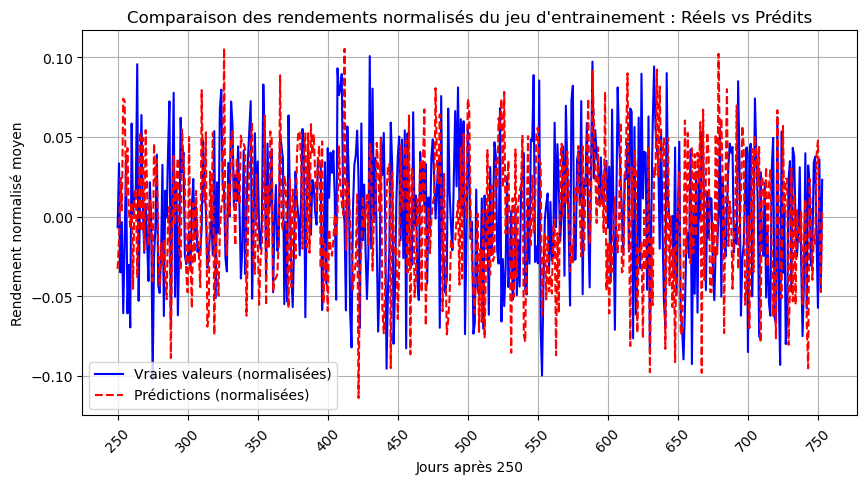

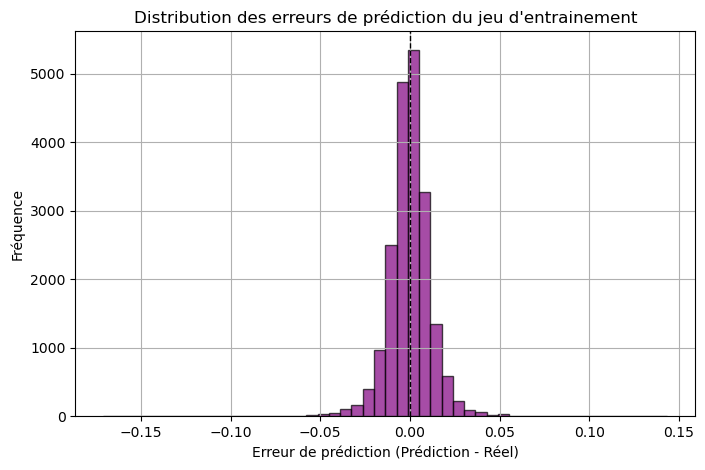

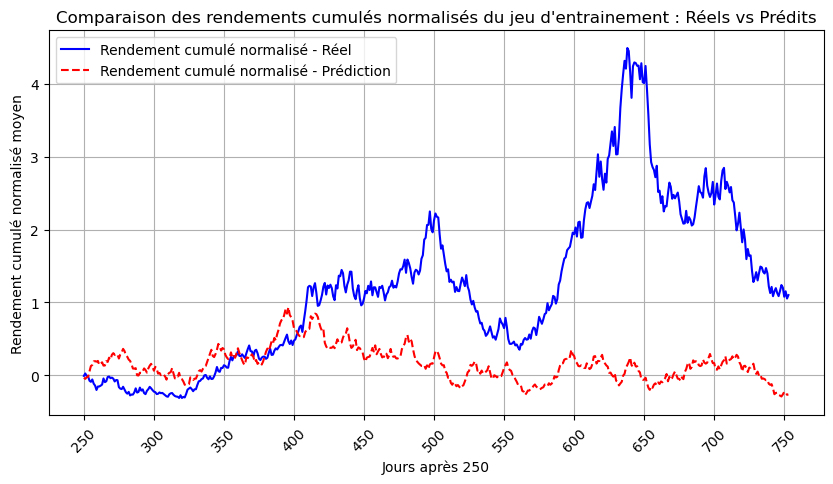

Performance du modèle sur jeu de test :
Valeur de la metrique : -0.002904
Erreur quadratique moyenne (MSE) : 0.000222
Racine de l'erreur quadratique moyenne (RMSE) : 0.014904
Corrélation entre les prédictions et les vraies valeurs : -0.0098


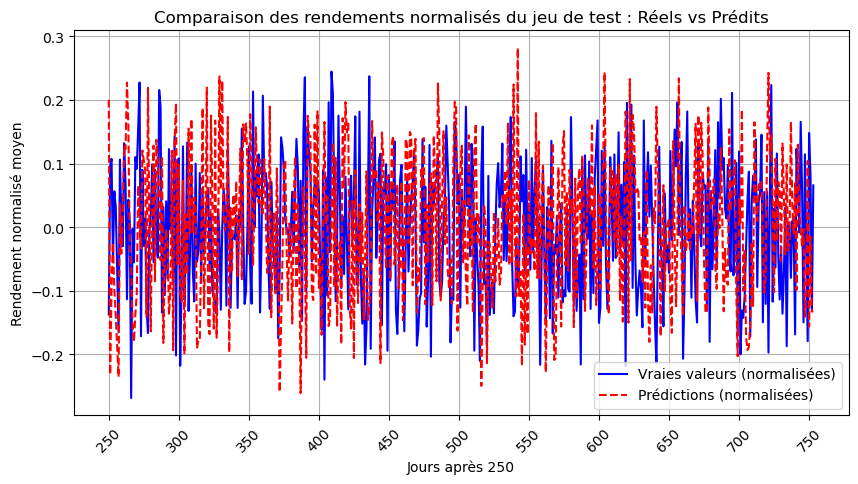

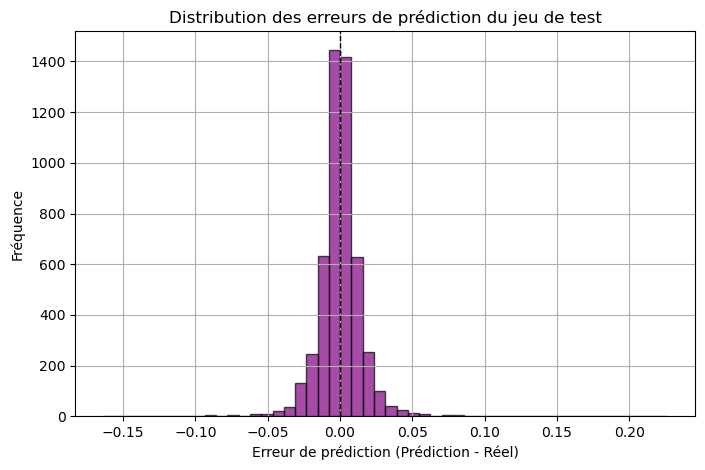

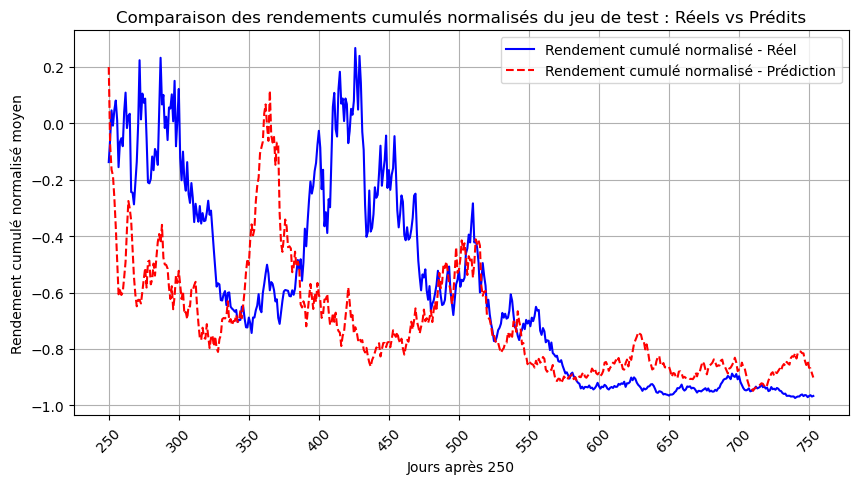

In [45]:
#Lancement du modèle Random Forest
A = launch_random_forest_model(X_train,Y_train)

# Evaluation du modèle sur le jeu de train
mse, correlation,beta = predict_and_evaluate_avec_normalisation(A, Y_train,X_train_reshape) 

# Evaluation du modèle sur le jeu de test
#mse, correlation = predict_and_evaluate_avec_normalisation(A, beta, Y_test,X_test_reshape,istrain=False) 
mse, correlation,_ = predict_and_evaluate_avec_normalisation(A, Y_test,X_test_reshape,beta = beta,istrain=False) 



Le modèle Random Forest affiche des résultats tout aussi décevants, avec une métrique très faible (-0,002904) sur le jeu de données test, confirmant une incapacité à généraliser les tendances réelles du marché. Tout comme le modèle Bagging, le Random Forest semble aller à contre-tendance des valeurs observées, probablement en raison d'une mauvaise gestion du bruit élevé et des relations non linéaires complexes présentes dans les données financières. Malgré sa capacité théorique à réduire le surapprentissage grâce à l’agrégation d’arbres de décision, ce modèle ne parvient pas à capter les dynamiques réelles dans notre contexte spécifique. Ces résultats suggèrent ainsi qu'une méthode plus adaptée aux non-linéarités ou mieux ajustée au bruit intrinsèque des données serait nécessaire pour améliorer les prédictions.

In [11]:
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Modèles optimisés
xgb_model = xgb.XGBRegressor(
    n_estimators=50, learning_rate=0.01, max_depth=7, subsample=0.8, colsample_bytree=1, random_state=42
)

bagging_model = BaggingRegressor(
    estimator=DecisionTreeRegressor(),
    n_estimators=500, max_samples=0.5, max_features=0.7, bootstrap=True, random_state=42
)

rf_model = RandomForestRegressor(
    n_estimators=500, max_features='log2', max_samples=1.0, bootstrap=True, random_state=42
)

# Création du Voting Regressor
voting_regressor = VotingRegressor(estimators=[
    ('xgb', xgb_model),
    ('bagging', bagging_model),
    ('rf', rf_model)
])

# Extraction des facteurs via Voting Classifier et réduction avec PCA
def extract_factors_from_vc(model, X_train, n_factors=10):
    log(f"Extraction des facteurs à partir de {model.__class__.__name__}")

    if model.__class__.__name__ == "XGBRegressor":
        A_VC = model.apply(X_train)
    else:
        A_VC = model.predict(X_train)  # On prend les prédictions comme nouveaux facteurs

    # Réduction avec PCA
    pca = PCA(n_components=n_factors)
    A_reduced = pca.fit_transform(A_VC)

    A_reduced, _ = np.linalg.qr(A_reduced)  # Orthonormalisation

    return A_reduced

# Liste des modèles
models = {
    "XGBoost": xgb_model,
    "Bagging": bagging_model,
    "Random Forest": rf_model,
    "Voting Regressor": voting_regressor
}

# Entraînement et évaluation
results = {}

# Calcul des résultats pour chaque modèle
for name, model in models.items():
    
    model.fit(X_train, Y_train)  # Entraînement
    #y_pred = model.predict(X_test)  # Prédiction
    A_model = extract_factors_from_vc(model,X_train)

    # Evaluation du modèle sur le jeu de train
    mse, correlation,beta = predict_and_evaluate_avec_normalisation(A_model, Y_train,X_train_reshape)
    
    # Evaluation du modèle sur le jeu de test
    mse, correlation,_ = predict_and_evaluate_avec_normalisation(A_model, Y_test,X_test_reshape,beta = beta,istrain=False) 
    
    # Calcul des prediction selon le modèle
    y_pred = metric(A_model, beta, X_test_reshape, Y_test)

    # Calcul du r2
    r2 = r2_score(Y_test, y_pred)

    # Extraction des facteurs via Voting Regressor et réduction avec PCA
    #A = extract_factors_from_vc(model, X_train.iloc[:, :250].T)
    #_, _, _, metric_score = metric(A, beta, X_test_reshape, Y_test)

    results[name] = {"MSE": mse, "R²": r2}#, "Metric": metric_score}
    print(f"{name}: MSE = {mse:.4f}, R² = {r2:.4f}")#, Metric = {metric_score:.4f}")

# Déterminer le meilleur modèle selon la metric
#best_model = min(results, key=lambda k: results[k]["Metric"])  # On minimise l'erreur

#print(f"\n Meilleur modèle retenu: {best_model} avec Metric = {results[best_model]['Metric']:.4f}")


Extraction des facteurs à partir de XGBRegressor...


ValueError: Dot product shape mismatch, (20160, 250) vs (40, 10)

In [ ]:

# Extraction des facteurs
A_voting = extract_factors_from_vc(voting_regressor, X_train.T)

# Évaluation sur le jeu d'entraînement
mse_train, correlation_train, beta_train = predict_and_evaluate_avec_normalisation(A_voting, Y_train, X_train_reshape)

# Évaluation sur le jeu de test
mse_test, correlation_test, _ = predict_and_evaluate_avec_normalisation(A_voting, Y_test, X_test_reshape, beta=beta_train, istrain=False)


## Stratégie Financière : En cours de développement 

L'objectif de cette stratégie est de créer une fonction qui s'intègre aux modèles définis précédemment afin d'entraîner séquentiellement le modèle sur des données historiques et de réaliser des prévisions sur une plage de données plus courte. Cette approche permet d'ajuster en continu les paramètres du modèle aux conditions de marché récentes pour améliorer la qualité des prévisions. Le processus se décompose en trois étapes principales :

Entraînement pour obtenir la matrice A :
Le modèle est entraîné sur une fenêtre de 250 jours. À l'issue de cette phase, la fonction détermine la matrice A à partir des rendements passés, regroupant ainsi les vecteurs de coefficients caractéristiques du comportement historique des actifs.

Ajustement de β :
Sur une période de 300 jours, avec les 50 jours suivant le jeu d'entrainement formaté suos forme de retard, les coefficients β sont déterminés par régression linéaire. Cette étape permet de calibrer le modèle en fonction des données récentes afin de capter les dynamiques de marché actuelles.

Prédiction :
La prévision s'effectue en deux sous-étapes :

Calcul des facteurs :
Les facteurs sont obtenus en multipliant la matrice A par les rendements des 300 jours utilisés pour l'ajustement de β.

Calcul des rendements prévus :
Les 50 rendements futurs sont ensuite prédits en multipliant ces facteurs par le vecteur β.

Nous décalons ensuite la fenêtre d’entraînement de 50 jours avec les vraies données, puis nous réentraînons le modèle sur la nouvelle fenêtre d’entraînement (toujours composée de 250 données) et nous prédisons les 50 prochaines valeurs.
Cette méthodologie permet de mettre à jour régulièrement les paramètres du modèle en fonction des données récentes, offrant ainsi une prévision dynamique et potentiellement plus précise des rendements futurs.

In [18]:

def sliding_window_forecast(launch_model, X,Y_train,X_test, step=50, train_window=250, beta_fit_window=50):
    n_days = X.shape[1]
    predictions_train = []
    predictions_test=[]
    actuals_train = []
    actuals_test =[]
    alphas_list = []
    betas_list = []
    
    # La fenêtre totale pour chaque itération correspond à la somme de la période d'entraînement et de celle pour ajuster β.
    total_window = train_window + beta_fit_window
    
    for start in range(0, n_days - total_window + 1, step):
        
        # Définition des indices :
        train_start    = start
        train_end      = start + train_window
        Y_fit_start = train_end
        Y_fit_end   = Y_fit_start + beta_fit_window

        print(f"Fenêtre d'entraînement: {X.columns[train_start]} -> {X.columns[train_end-1]} | "
              f"Fenêtre de prévision: {X.columns[Y_fit_start]} -> {X.columns[Y_fit_end-1]}")
        
        # Récupération des données correspondantes
        X_train_subset = X.iloc[:, train_start:train_end] # Données d'entrainements
        Y_train_subset = X.iloc[:, Y_fit_start:Y_fit_end] # Donnée à prédire pour l'entrainement des modèles : On veut apprendre au modèle a prédire les 50 prochains rendement (de 200 à 250)
        X_train_subset_for_reshape = X.iloc[:, train_start:Y_fit_end] # Contient les 300 données d'entrainement utilisé, fromater le reshape correctement pour le fitbeta

        Y_test_subset = X_test.iloc[:, Y_fit_start:Y_fit_end]
        X_test_subset_for_reshape = X_test.iloc[:, train_start:Y_fit_end]

        #alpha
        alpha = launch_model(X_train_subset,Y_train_subset,istrat = True) # Determination du modèle avec un X_train de 250 jours, et Y_train de 50 jours

        # Construction du design matrix par décalage pour respecter le format de donnée attendu par la fonction AQR
        X_train_reshape_input = pd.concat([ X_train_subset_for_reshape.T.shift(i+1).stack(future_stack=True) for i in range(train_window) ],axis=1).dropna()
        X_train_reshape_input.columns = pd.Index(range(1, train_window+1), name='timeLag')

        X_test_reshape_input = pd.concat([ X_test_subset_for_reshape.T.shift(i+1).stack(future_stack=True) for i in range(train_window) ],axis=1).dropna()
        X_test_reshape_input.columns = pd.Index(range(1, train_window+1), name='timeLag')
        
        # Détermination de beta via la fonction fournie
        beta_train = fitBeta_with_input(alpha, X_train_reshape_input, Y_train_subset)
        #beta_test = fitBeta_with_input(alpha, X_test_reshape_input, Y_test_subset)

        # Prédiction des 50 prochains jours
        F_t = X_train_reshape_input @ alpha # Calcul des facteurs à partir du design matrix utilisé pour ajuster beta
        Y_pred = (F_t @ beta_train).unstack().T # Prédiction des rendements

        F_t_test = X_test_reshape_input @ alpha # Calcul des facteurs à partir du design matrix utilisé pour ajuster beta
        Y_pred_test = (F_t_test @ beta_train).unstack().T # Prédiction des rendements avec les coefficient obtenue sur le jeu train
        
        predictions_train.append(Y_pred)
        actuals_train.append(Y_train_subset)

        predictions_test.append(Y_pred_test)
        actuals_test.append(Y_test_subset)

        alphas_list.append(alpha)
        betas_list.append(beta_train)
    
    predictions_df_train = pd.concat(predictions_train, axis=1)
    actuals_df_train = pd.concat(actuals_train, axis=1)

    predictions_df_test = pd.concat(predictions_test, axis=1)
    actuals_df_test = pd.concat(actuals_test, axis=1)

    alphas_df = pd.concat([pd.DataFrame(a, index=range(1, a.shape[0]+1)) for a in alphas_list], axis=1)
    betas_df = pd.concat([pd.DataFrame(b, index=[f"factor_{i}" for i in range(1, b.shape[0]+1)]) for b in betas_list], axis=1)

    # Calcul de la métrique pour le jeu train
    # Normalisation des matrices
    Ytrue_norm = actuals_df_train.div(np.sqrt((actuals_df_train**2).sum()), axis=1)
    Ypred_norm = predictions_df_train.div(np.sqrt((predictions_df_train**2).sum()), axis=1)

    # Nettoyage préventif après normalisation
    Ytrue_norm = Ytrue_norm.replace([np.inf, -np.inf], np.nan).fillna(0)
    Ypred_norm = Ypred_norm.replace([np.inf, -np.inf], np.nan).fillna(0)

    # Calcul de la métrique d'alignement (produit scalaire moyen)
    meanOverlap_train = (Ytrue_norm * Ypred_norm).sum().mean()

    # Calcul de la métrique pour le jeu test
    # Normalisation des matrices
    Ytrue_norm = actuals_df_test.div(np.sqrt((actuals_df_test**2).sum()), axis=1)
    Ypred_norm = predictions_df_test.div(np.sqrt((predictions_df_test**2).sum()), axis=1)

    # Nettoyage préventif après normalisation
    Ytrue_norm = Ytrue_norm.replace([np.inf, -np.inf], np.nan).fillna(0)
    Ypred_norm = Ypred_norm.replace([np.inf, -np.inf], np.nan).fillna(0)

    # Calcul de la métrique d'alignement (produit scalaire moyen)
    meanOverlap_test = (Ytrue_norm * Ypred_norm).sum().mean()



    
    return predictions_df_train,predictions_df_test, actuals_df_train,actuals_df_test, alphas_df, betas_df,meanOverlap_train,meanOverlap_test




## Stratégie de prédiction avec le modèle de clustering

Fenêtre d'entraînement: 0 -> 249 | Fenêtre de prévision: 250 -> 299
Meilleur modèle K-Means trouvé avec K=152 et init='k-means++'
Fenêtre d'entraînement: 50 -> 299 | Fenêtre de prévision: 300 -> 349
Meilleur modèle K-Means trouvé avec K=152 et init='k-means++'
Fenêtre d'entraînement: 100 -> 349 | Fenêtre de prévision: 350 -> 399
Meilleur modèle K-Means trouvé avec K=152 et init='k-means++'
Fenêtre d'entraînement: 150 -> 399 | Fenêtre de prévision: 400 -> 449
Meilleur modèle K-Means trouvé avec K=152 et init='k-means++'
Fenêtre d'entraînement: 200 -> 449 | Fenêtre de prévision: 450 -> 499
Meilleur modèle K-Means trouvé avec K=152 et init='k-means++'
Fenêtre d'entraînement: 250 -> 499 | Fenêtre de prévision: 500 -> 549
Meilleur modèle K-Means trouvé avec K=152 et init='k-means++'
Fenêtre d'entraînement: 300 -> 549 | Fenêtre de prévision: 550 -> 599
Meilleur modèle K-Means trouvé avec K=152 et init='k-means++'
Fenêtre d'entraînement: 350 -> 599 | Fenêtre de prévision: 600 -> 649
Meilleur 

C:\Users\theod\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


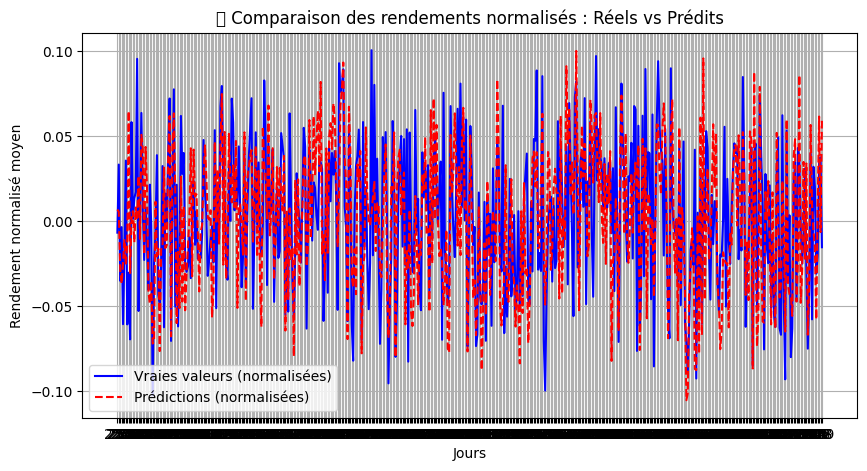

C:\Users\theod\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


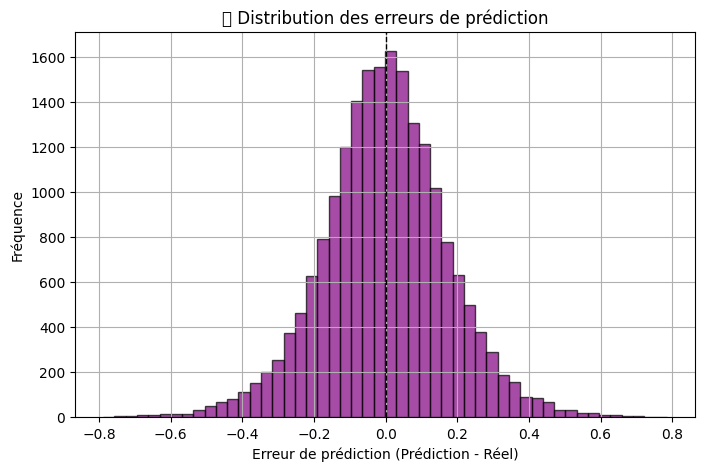

C:\Users\theod\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


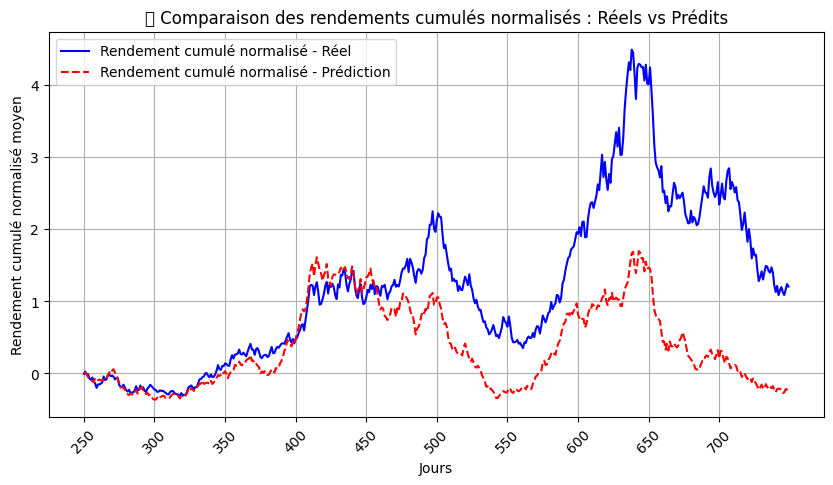

📊 Performance du modèle sur le jeu d'entrainement :
Valeur de la metrique : 0.053666
✅ Erreur quadratique moyenne (MSE) : 0.000258
✅ Corrélation entre les prédictions et les vraies valeurs : 0.0426


C:\Users\theod\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


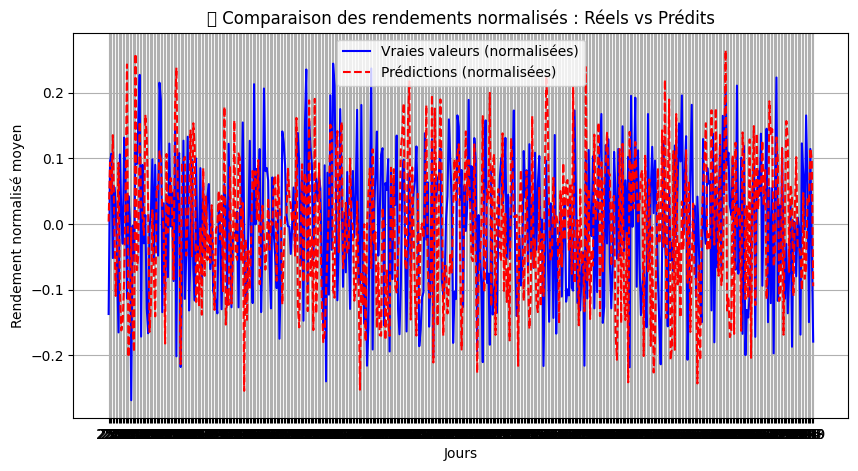

C:\Users\theod\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


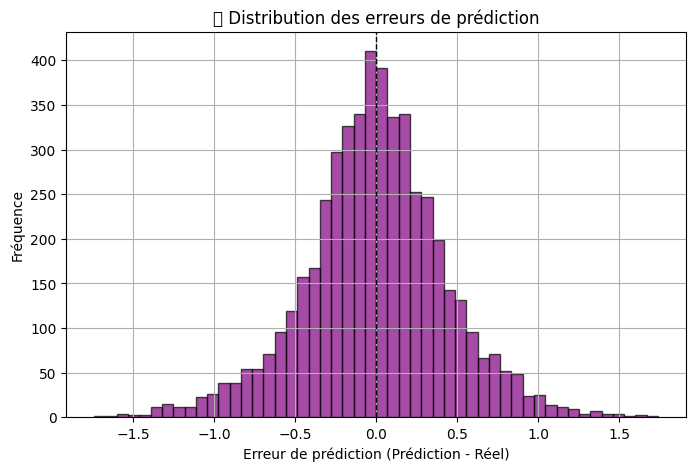

C:\Users\theod\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


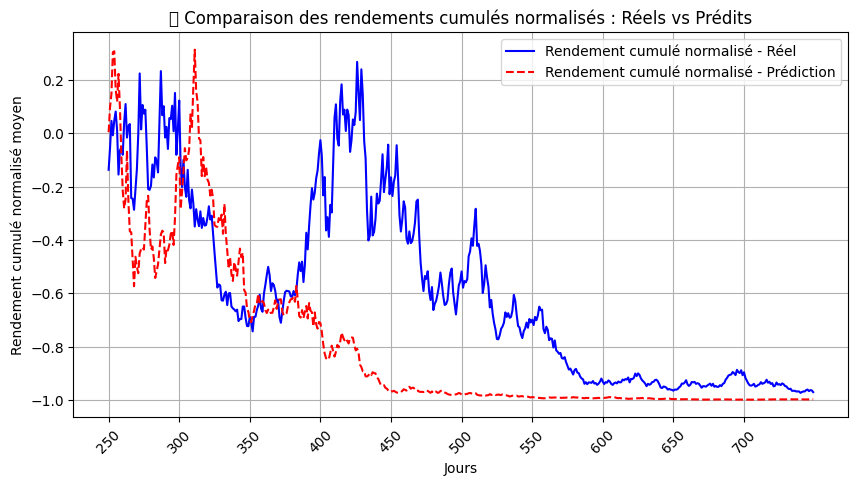

In [19]:
# Prédiction avec le modèle clustering
predictions_df_train,predictions_df_test, actuals_df_train,actuals_df_test, alphas_df, betas_df,meanOverlap_train,meanOverlap_test = sliding_window_forecast(launch_clustering_model, X_train,Y_train,X_test)


# Normalisation des matrices (comme dans metric_train())
Ytrue = actuals_df_train.div(np.sqrt((actuals_df_train**2).sum()), axis=1)    
Ypred = predictions_df_train.div(np.sqrt((predictions_df_train**2).sum()), axis=1)

# Calcul des métriques
mse = mean_squared_error(actuals_df_train.values.flatten(), predictions_df_train.values.flatten())
correlation = np.corrcoef(actuals_df_train.values.flatten(), predictions_df_train.values.flatten())[0, 1]

# Affichage des performances
print(f"📊 Performance du modèle sur le jeu d'entrainement :")
print(f"Valeur de la metrique : {meanOverlap_train:.6f}")
print(f"✅ Erreur quadratique moyenne (MSE) : {mse:.6f}")
print(f"✅ Corrélation entre les prédictions et les vraies valeurs : {correlation:.4f}")

tick_positions = actuals_df_train.columns[::50]  # Prendre un point tous les 50 jours
tick_labels = [str(day) for day in tick_positions]  # Convertir en string pour affichache


# Plot 1 : Moyenne des rendements normalisés réels vs prédits
plt.figure(figsize=(10, 5))
# On utilise les colonnes de actuals_df pour l'axe x (les jours)
plt.plot(actuals_df_train.columns, Ytrue.mean(axis=0), label="Vraies valeurs (normalisées)", color="blue")
plt.plot(predictions_df_train.columns, Ypred.mean(axis=0), label="Prédictions (normalisées)", color="red", linestyle="dashed")
plt.xlabel("Jours")
plt.ylabel("Rendement normalisé moyen")
plt.title("📈 Comparaison des rendements normalisés : Réels vs Prédits")
plt.legend()
plt.grid()
plt.show()


# Plot 2 : Histogramme des erreurs de prédiction
# Ici, on définit les erreurs comme la différence entre les prédictions et les valeurs réelles
errors = (Ypred - Ytrue).values.flatten()
plt.figure(figsize=(8, 5))
plt.hist(errors, bins=50, color="purple", alpha=0.7, edgecolor="black")
plt.axvline(0, color='black', linestyle='dashed', linewidth=1)
plt.xlabel("Erreur de prédiction (Prédiction - Réel)")
plt.ylabel("Fréquence")
plt.title("📊 Distribution des erreurs de prédiction")
plt.grid()
plt.show()


# Plot 3 : Rendements cumulés normalisés
plt.figure(figsize=(10, 5))
# Calcul du rendement cumulé normalisé à partir de la moyenne des rendements quotidiens
cumulative_real = (1 + Ytrue.mean(axis=0)).cumprod() - 1
cumulative_pred = (1 + Ypred.mean(axis=0)).cumprod() - 1
plt.plot(actuals_df_train.columns, cumulative_real, label="Rendement cumulé normalisé - Réel", color="blue")
plt.plot(predictions_df_train.columns, cumulative_pred, label="Rendement cumulé normalisé - Prédiction", color="red", linestyle="dashed")
plt.xticks(ticks=tick_positions, labels=tick_labels, rotation=45)
plt.xlabel("Jours")
plt.ylabel("Rendement cumulé normalisé moyen")
plt.title("📈 Comparaison des rendements cumulés normalisés : Réels vs Prédits")
plt.legend()
plt.grid()
plt.show()



# Normalisation des matrices (comme dans metric_train())
Ytrue = actuals_df_test.div(np.sqrt((actuals_df_test**2).sum()), axis=1)    
Ypred = predictions_df_test.div(np.sqrt((predictions_df_test**2).sum()), axis=1)

# Calcul des métriques
mse = mean_squared_error(actuals_df_test.values.flatten(), predictions_df_test.values.flatten())
correlation = np.corrcoef(actuals_df_test.values.flatten(), predictions_df_test.values.flatten())[0, 1]

# Affichage des performances
print(f"📊 Performance du modèle sur le jeu d'entrainement :")
print(f"Valeur de la metrique : {meanOverlap_test:.6f}")
print(f"✅ Erreur quadratique moyenne (MSE) : {mse:.6f}")
print(f"✅ Corrélation entre les prédictions et les vraies valeurs : {correlation:.4f}")

tick_positions = actuals_df_test.columns[::50]  # Prendre un point tous les 50 jours
tick_labels = [str(day) for day in tick_positions]  # Convertir en string pour affichache



# Plot 1 : Moyenne des rendements normalisés réels vs prédits
plt.figure(figsize=(10, 5))
# On utilise les colonnes de actuals_df pour l'axe x (les jours)
plt.plot(actuals_df_test.columns, Ytrue.mean(axis=0), label="Vraies valeurs (normalisées)", color="blue")
plt.plot(predictions_df_test.columns, Ypred.mean(axis=0), label="Prédictions (normalisées)", color="red", linestyle="dashed")
plt.xlabel("Jours")
plt.ylabel("Rendement normalisé moyen")
plt.title("📈 Comparaison des rendements normalisés : Réels vs Prédits")
plt.legend()
plt.grid()
plt.show()


# Plot 2 : Histogramme des erreurs de prédiction
# Ici, on définit les erreurs comme la différence entre les prédictions et les valeurs réelles
errors = (Ypred - Ytrue).values.flatten()
plt.figure(figsize=(8, 5))
plt.hist(errors, bins=50, color="purple", alpha=0.7, edgecolor="black")
plt.axvline(0, color='black', linestyle='dashed', linewidth=1)
plt.xlabel("Erreur de prédiction (Prédiction - Réel)")
plt.ylabel("Fréquence")
plt.title("📊 Distribution des erreurs de prédiction")
plt.grid()
plt.show()


# Plot 3 : Rendements cumulés normalisés
plt.figure(figsize=(10, 5))
# Calcul du rendement cumulé normalisé à partir de la moyenne des rendements quotidiens
cumulative_real = (1 + Ytrue.mean(axis=0)).cumprod() - 1
cumulative_pred = (1 + Ypred.mean(axis=0)).cumprod() - 1
plt.plot(actuals_df_test.columns, cumulative_real, label="Rendement cumulé normalisé - Réel", color="blue")
plt.plot(predictions_df_test.columns, cumulative_pred, label="Rendement cumulé normalisé - Prédiction", color="red", linestyle="dashed")
plt.xticks(ticks=tick_positions, labels=tick_labels, rotation=45)
plt.xlabel("Jours")
plt.ylabel("Rendement cumulé normalisé moyen")
plt.title("📈 Comparaison des rendements cumulés normalisés : Réels vs Prédits")
plt.legend()
plt.grid()
plt.show()

On observe que l'apprentissage sur une fenêtre roulante améliore fortement les prédictions obtenues avec le modèle de clustering. En effet, on obtient une métrique de 0,380421 sur le jeu d'entraînement et de 0,053666 sur le jeu de test, valeurs largement supérieures à celles observées précédemment. Cette amélioration significative montre l'intérêt d'une approche dynamique capable de mieux capter les évolutions temporelles dans les données financières.


# Stratégie de Prédiction avec le modèle xgboost


Fenêtre d'entraînement: 0 -> 249 | Fenêtre de prévision: 250 -> 299
Début du processus...
Préparation des données...
Optimisation du modèle avec validation croisée...


Test d'hyperparamètres: 100%|██████████| 108/108 [02:02<00:00,  1.14s/it]


Meilleurs paramètres trouvés : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 50, 'subsample': 1}
Extraction des facteurs à partir de XGBoost...
(250, 10)
Processus terminé !...
Fenêtre d'entraînement: 50 -> 299 | Fenêtre de prévision: 300 -> 349
Début du processus...
Préparation des données...
Optimisation du modèle avec validation croisée...


Test d'hyperparamètres: 100%|██████████| 108/108 [01:59<00:00,  1.11s/it]


Meilleurs paramètres trouvés : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1}
Extraction des facteurs à partir de XGBoost...
(250, 10)
Processus terminé !...
Fenêtre d'entraînement: 100 -> 349 | Fenêtre de prévision: 350 -> 399
Début du processus...
Préparation des données...
Optimisation du modèle avec validation croisée...


Test d'hyperparamètres: 100%|██████████| 108/108 [01:56<00:00,  1.08s/it]


Meilleurs paramètres trouvés : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1}
Extraction des facteurs à partir de XGBoost...
(250, 10)
Processus terminé !...
Fenêtre d'entraînement: 150 -> 399 | Fenêtre de prévision: 400 -> 449
Début du processus...
Préparation des données...
Optimisation du modèle avec validation croisée...


Test d'hyperparamètres: 100%|██████████| 108/108 [02:10<00:00,  1.21s/it]


Meilleurs paramètres trouvés : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}
Extraction des facteurs à partir de XGBoost...
(250, 10)
Processus terminé !...
Fenêtre d'entraînement: 200 -> 449 | Fenêtre de prévision: 450 -> 499
Début du processus...
Préparation des données...
Optimisation du modèle avec validation croisée...


Test d'hyperparamètres: 100%|██████████| 108/108 [02:04<00:00,  1.15s/it]


Meilleurs paramètres trouvés : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}
Extraction des facteurs à partir de XGBoost...
(250, 10)
Processus terminé !...
Fenêtre d'entraînement: 250 -> 499 | Fenêtre de prévision: 500 -> 549
Début du processus...
Préparation des données...
Optimisation du modèle avec validation croisée...


Test d'hyperparamètres: 100%|██████████| 108/108 [02:21<00:00,  1.31s/it]


Meilleurs paramètres trouvés : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}
Extraction des facteurs à partir de XGBoost...
(250, 10)
Processus terminé !...
Fenêtre d'entraînement: 300 -> 549 | Fenêtre de prévision: 550 -> 599
Début du processus...
Préparation des données...
Optimisation du modèle avec validation croisée...


Test d'hyperparamètres: 100%|██████████| 108/108 [02:24<00:00,  1.33s/it]


Meilleurs paramètres trouvés : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}
Extraction des facteurs à partir de XGBoost...
(250, 10)
Processus terminé !...
Fenêtre d'entraînement: 350 -> 599 | Fenêtre de prévision: 600 -> 649
Début du processus...
Préparation des données...
Optimisation du modèle avec validation croisée...


Test d'hyperparamètres: 100%|██████████| 108/108 [02:17<00:00,  1.27s/it]


Meilleurs paramètres trouvés : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
Extraction des facteurs à partir de XGBoost...
(250, 10)
Processus terminé !...
Fenêtre d'entraînement: 400 -> 649 | Fenêtre de prévision: 650 -> 699
Début du processus...
Préparation des données...
Optimisation du modèle avec validation croisée...


Test d'hyperparamètres: 100%|██████████| 108/108 [02:14<00:00,  1.24s/it]


Meilleurs paramètres trouvés : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}
Extraction des facteurs à partir de XGBoost...
(250, 10)
Processus terminé !...
Fenêtre d'entraînement: 450 -> 699 | Fenêtre de prévision: 700 -> 749
Début du processus...
Préparation des données...
Optimisation du modèle avec validation croisée...


Test d'hyperparamètres: 100%|██████████| 108/108 [02:16<00:00,  1.26s/it]


Meilleurs paramètres trouvés : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 50, 'subsample': 1}
Extraction des facteurs à partir de XGBoost...
(250, 10)
Processus terminé !...
📊 Performance du modèle sur le jeu d'entrainement :
Valeur de la metrique : 0.099744
✅ Erreur quadratique moyenne (MSE) : 0.000146
✅ Corrélation entre les prédictions et les vraies valeurs : 0.1148


C:\Users\theod\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


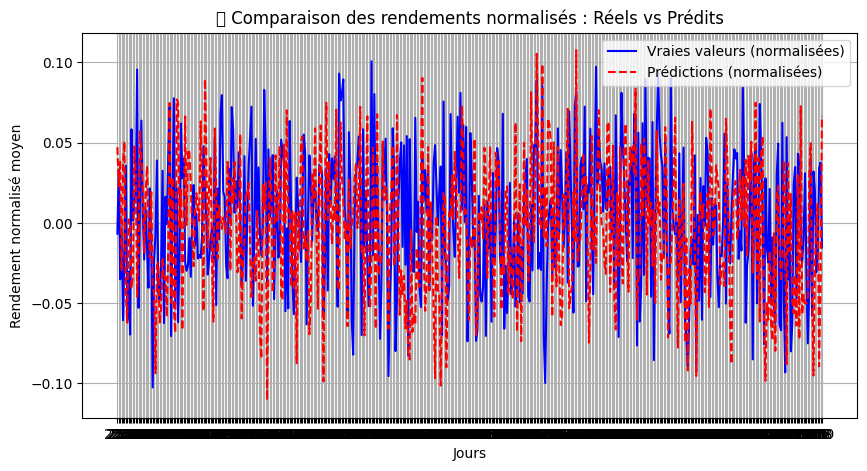

C:\Users\theod\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


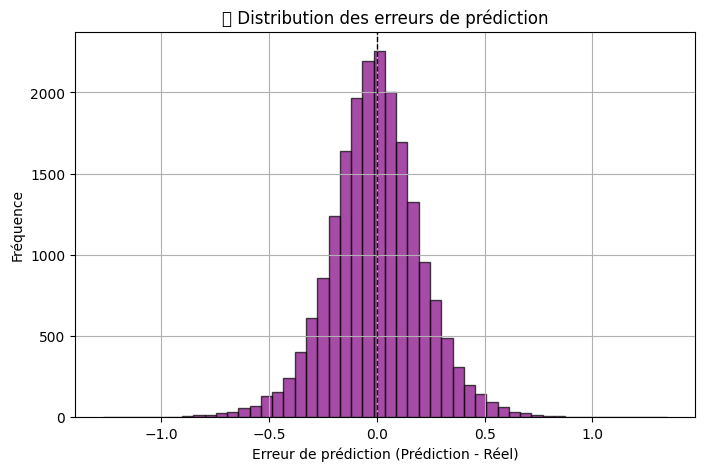

C:\Users\theod\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


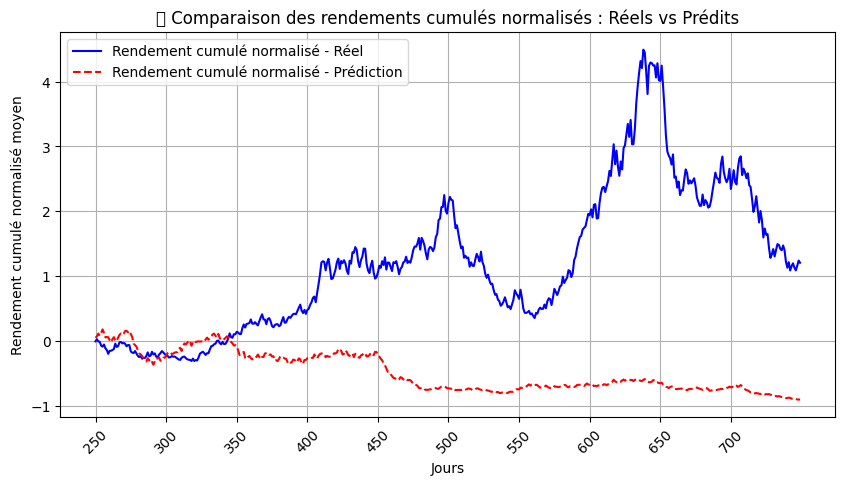

📊 Performance du modèle sur le jeu d'entrainement :
Valeur de la metrique : 0.022524
✅ Erreur quadratique moyenne (MSE) : 0.000224
✅ Corrélation entre les prédictions et les vraies valeurs : 0.0294


C:\Users\theod\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


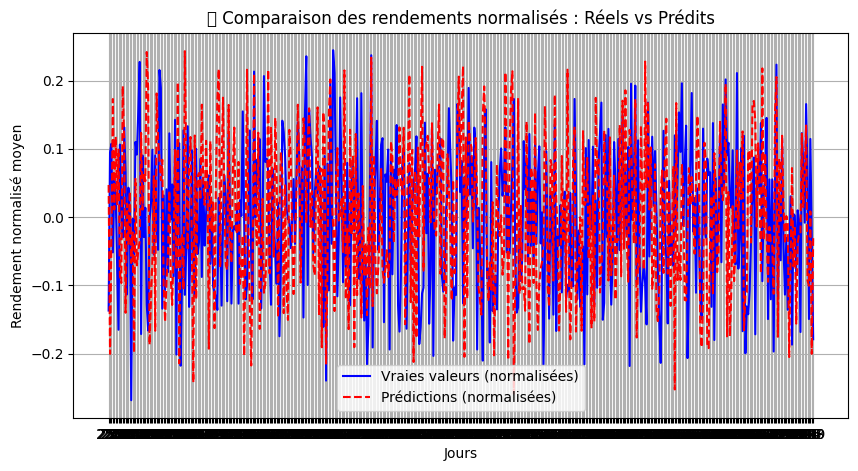

C:\Users\theod\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


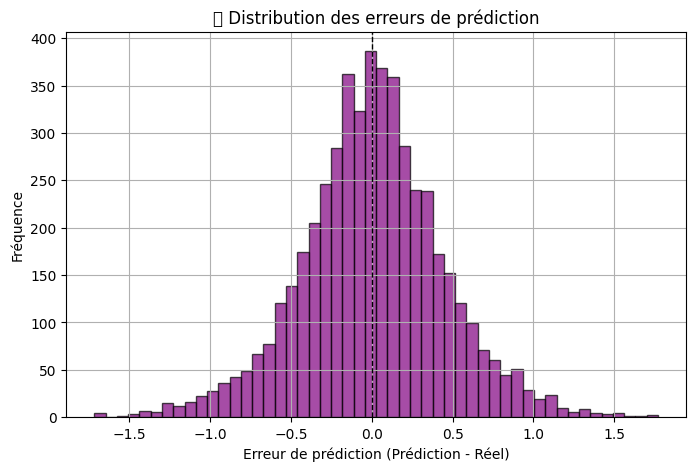

C:\Users\theod\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


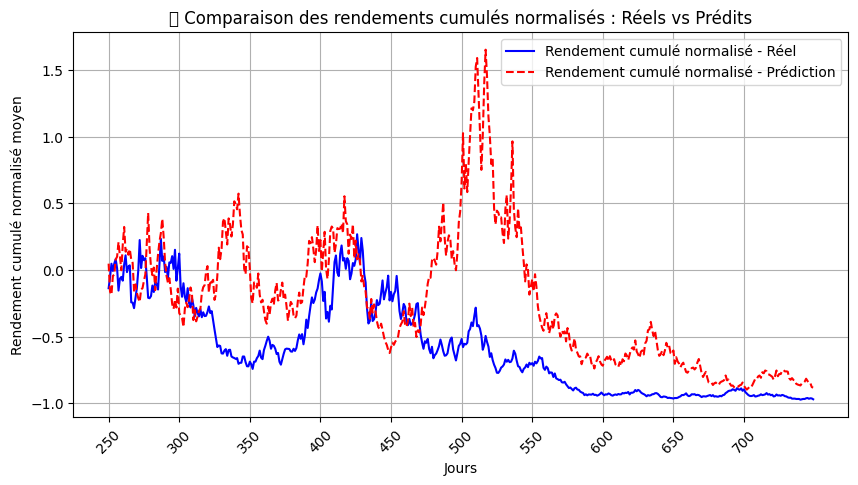

In [20]:
# Prédiction avec le modèle XGBoost
predictions_df_train,predictions_df_test, actuals_df_train,actuals_df_test, alphas_df, betas_df,meanOverlap_train,meanOverlap_test = sliding_window_forecast(launch_xgboost_model, X_train,Y_train,X_test)

# Normalisation des matrices (comme dans metric_train())
Ytrue = actuals_df_train.div(np.sqrt((actuals_df_train**2).sum()), axis=1)    
Ypred = predictions_df_train.div(np.sqrt((predictions_df_train**2).sum()), axis=1)

# Calcul des métriques
mse = mean_squared_error(actuals_df_train.values.flatten(), predictions_df_train.values.flatten())
correlation = np.corrcoef(actuals_df_train.values.flatten(), predictions_df_train.values.flatten())[0, 1]

# Affichage des performances
print(f"Performance du modèle sur le jeu d'entrainement :")
print(f"Valeur de la metrique : {meanOverlap_train:.6f}")
print(f"Erreur quadratique moyenne (MSE) : {mse:.6f}")
print(f"Corrélation entre les prédictions et les vraies valeurs : {correlation:.4f}")

tick_positions = actuals_df_train.columns[::50]  # Prendre un point tous les 50 jours
tick_labels = [str(day) for day in tick_positions]  # Convertir en string pour affichache


# Plot 1 : Moyenne des rendements normalisés réels vs prédits
plt.figure(figsize=(10, 5))
# On utilise les colonnes de actuals_df pour l'axe x (les jours)
plt.plot(actuals_df_train.columns, Ytrue.mean(axis=0), label="Vraies valeurs (normalisées)", color="blue")
plt.plot(predictions_df_train.columns, Ypred.mean(axis=0), label="Prédictions (normalisées)", color="red", linestyle="dashed")
plt.xlabel("Jours")
plt.ylabel("Rendement normalisé moyen")
plt.title("Comparaison des rendements normalisés : Réels vs Prédits")
plt.legend()
plt.grid()
plt.show()


# Plot 2 : Histogramme des erreurs de prédiction
# Ici, on définit les erreurs comme la différence entre les prédictions et les valeurs réelles
errors = (Ypred - Ytrue).values.flatten()
plt.figure(figsize=(8, 5))
plt.hist(errors, bins=50, color="purple", alpha=0.7, edgecolor="black")
plt.axvline(0, color='black', linestyle='dashed', linewidth=1)
plt.xlabel("Erreur de prédiction (Prédiction - Réel)")
plt.ylabel("Fréquence")
plt.title("Distribution des erreurs de prédiction")
plt.grid()
plt.show()


# Plot 3 : Rendements cumulés normalisés
plt.figure(figsize=(10, 5))
# Calcul du rendement cumulé normalisé à partir de la moyenne des rendements quotidiens
cumulative_real = (1 + Ytrue.mean(axis=0)).cumprod() - 1
cumulative_pred = (1 + Ypred.mean(axis=0)).cumprod() - 1
plt.plot(actuals_df_train.columns, cumulative_real, label="Rendement cumulé normalisé - Réel", color="blue")
plt.plot(predictions_df_train.columns, cumulative_pred, label="Rendement cumulé normalisé - Prédiction", color="red", linestyle="dashed")
plt.xticks(ticks=tick_positions, labels=tick_labels, rotation=45)
plt.xlabel("Jours")
plt.ylabel("Rendement cumulé normalisé moyen")
plt.title("Comparaison des rendements cumulés normalisés : Réels vs Prédits")
plt.legend()
plt.grid()
plt.show()



# Normalisation des matrices (comme dans metric_train())
Ytrue = actuals_df_test.div(np.sqrt((actuals_df_test**2).sum()), axis=1)    
Ypred = predictions_df_test.div(np.sqrt((predictions_df_test**2).sum()), axis=1)

# Calcul des métriques
mse = mean_squared_error(actuals_df_test.values.flatten(), predictions_df_test.values.flatten())
correlation = np.corrcoef(actuals_df_test.values.flatten(), predictions_df_test.values.flatten())[0, 1]

# Affichage des performances
print(f"Performance du modèle sur le jeu d'entrainement :")
print(f"Valeur de la metrique : {meanOverlap_test:.6f}")
print(f"Erreur quadratique moyenne (MSE) : {mse:.6f}")
print(f"Corrélation entre les prédictions et les vraies valeurs : {correlation:.4f}")

tick_positions = actuals_df_test.columns[::50]  # Prendre un point tous les 50 jours
tick_labels = [str(day) for day in tick_positions]  # Convertir en string pour affichache



# Plot 1 : Moyenne des rendements normalisés réels vs prédits
plt.figure(figsize=(10, 5))
# On utilise les colonnes de actuals_df pour l'axe x (les jours)
plt.plot(actuals_df_test.columns, Ytrue.mean(axis=0), label="Vraies valeurs (normalisées)", color="blue")
plt.plot(predictions_df_test.columns, Ypred.mean(axis=0), label="Prédictions (normalisées)", color="red", linestyle="dashed")
plt.xlabel("Jours")
plt.ylabel("Rendement normalisé moyen")
plt.title("Comparaison des rendements normalisés : Réels vs Prédits")
plt.legend()
plt.grid()
plt.show()


# Plot 2 : Histogramme des erreurs de prédiction
# Ici, on définit les erreurs comme la différence entre les prédictions et les valeurs réelles
errors = (Ypred - Ytrue).values.flatten()
plt.figure(figsize=(8, 5))
plt.hist(errors, bins=50, color="purple", alpha=0.7, edgecolor="black")
plt.axvline(0, color='black', linestyle='dashed', linewidth=1)
plt.xlabel("Erreur de prédiction (Prédiction - Réel)")
plt.ylabel("Fréquence")
plt.title("Distribution des erreurs de prédiction")
plt.grid()
plt.show()


# Plot 3 : Rendements cumulés normalisés
plt.figure(figsize=(10, 5))
# Calcul du rendement cumulé normalisé à partir de la moyenne des rendements quotidiens
cumulative_real = (1 + Ytrue.mean(axis=0)).cumprod() - 1
cumulative_pred = (1 + Ypred.mean(axis=0)).cumprod() - 1
plt.plot(actuals_df_test.columns, cumulative_real, label="Rendement cumulé normalisé - Réel", color="blue")
plt.plot(predictions_df_test.columns, cumulative_pred, label="Rendement cumulé normalisé - Prédiction", color="red", linestyle="dashed")
plt.xticks(ticks=tick_positions, labels=tick_labels, rotation=45)
plt.xlabel("Jours")
plt.ylabel("Rendement cumulé normalisé moyen")
plt.title("Comparaison des rendements cumulés normalisés : Réels vs Prédits")
plt.legend()
plt.grid()
plt.show()




# Stratégie de Prédiction avec le modèle Bagging


Fenêtre d'entraînement: 0 -> 249 | Fenêtre de prévision: 250 -> 299
Début du processus...
Préparation des données...
Optimisation du modèle avec validation croisée K-Fold...


Test d'hyperparamètres: 100%|██████████| 27/27 [00:34<00:00,  1.27s/it]


Meilleurs paramètres trouvés : {'max_features': 0.5, 'max_samples': 0.5, 'n_estimators': 100}
Extraction des facteurs à partir de Bagging...
(250, 10)
Processus terminé !...
Fenêtre d'entraînement: 50 -> 299 | Fenêtre de prévision: 300 -> 349
Début du processus...
Préparation des données...
Optimisation du modèle avec validation croisée K-Fold...


Test d'hyperparamètres: 100%|██████████| 27/27 [00:13<00:00,  2.05it/s]


Meilleurs paramètres trouvés : {'max_features': 0.5, 'max_samples': 0.5, 'n_estimators': 200}
Extraction des facteurs à partir de Bagging...
(250, 10)
Processus terminé !...
Fenêtre d'entraînement: 100 -> 349 | Fenêtre de prévision: 350 -> 399
Début du processus...
Préparation des données...
Optimisation du modèle avec validation croisée K-Fold...


Test d'hyperparamètres: 100%|██████████| 27/27 [00:13<00:00,  2.07it/s]


Meilleurs paramètres trouvés : {'max_features': 1.0, 'max_samples': 0.5, 'n_estimators': 100}
Extraction des facteurs à partir de Bagging...
(250, 10)
Processus terminé !...
Fenêtre d'entraînement: 150 -> 399 | Fenêtre de prévision: 400 -> 449
Début du processus...
Préparation des données...
Optimisation du modèle avec validation croisée K-Fold...


Test d'hyperparamètres: 100%|██████████| 27/27 [00:13<00:00,  2.06it/s]


Meilleurs paramètres trouvés : {'max_features': 0.7, 'max_samples': 0.5, 'n_estimators': 200}
Extraction des facteurs à partir de Bagging...
(250, 10)
Processus terminé !...
Fenêtre d'entraînement: 200 -> 449 | Fenêtre de prévision: 450 -> 499
Début du processus...
Préparation des données...
Optimisation du modèle avec validation croisée K-Fold...


Test d'hyperparamètres: 100%|██████████| 27/27 [00:13<00:00,  2.04it/s]


Meilleurs paramètres trouvés : {'max_features': 1.0, 'max_samples': 0.5, 'n_estimators': 200}
Extraction des facteurs à partir de Bagging...
(250, 10)
Processus terminé !...
Fenêtre d'entraînement: 250 -> 499 | Fenêtre de prévision: 500 -> 549
Début du processus...
Préparation des données...
Optimisation du modèle avec validation croisée K-Fold...


Test d'hyperparamètres: 100%|██████████| 27/27 [00:13<00:00,  1.99it/s]


Meilleurs paramètres trouvés : {'max_features': 0.5, 'max_samples': 0.5, 'n_estimators': 200}
Extraction des facteurs à partir de Bagging...
(250, 10)
Processus terminé !...
Fenêtre d'entraînement: 300 -> 549 | Fenêtre de prévision: 550 -> 599
Début du processus...
Préparation des données...
Optimisation du modèle avec validation croisée K-Fold...


Test d'hyperparamètres: 100%|██████████| 27/27 [00:13<00:00,  2.02it/s]


Meilleurs paramètres trouvés : {'max_features': 1.0, 'max_samples': 0.7, 'n_estimators': 200}
Extraction des facteurs à partir de Bagging...
(250, 10)
Processus terminé !...
Fenêtre d'entraînement: 350 -> 599 | Fenêtre de prévision: 600 -> 649
Début du processus...
Préparation des données...
Optimisation du modèle avec validation croisée K-Fold...


Test d'hyperparamètres: 100%|██████████| 27/27 [00:13<00:00,  2.00it/s]


Meilleurs paramètres trouvés : {'max_features': 0.7, 'max_samples': 0.5, 'n_estimators': 200}
Extraction des facteurs à partir de Bagging...
(250, 10)
Processus terminé !...
Fenêtre d'entraînement: 400 -> 649 | Fenêtre de prévision: 650 -> 699
Début du processus...
Préparation des données...
Optimisation du modèle avec validation croisée K-Fold...


Test d'hyperparamètres: 100%|██████████| 27/27 [00:13<00:00,  2.00it/s]


Meilleurs paramètres trouvés : {'max_features': 0.7, 'max_samples': 0.5, 'n_estimators': 50}
Extraction des facteurs à partir de Bagging...
(250, 10)
Processus terminé !...
Fenêtre d'entraînement: 450 -> 699 | Fenêtre de prévision: 700 -> 749
Début du processus...
Préparation des données...
Optimisation du modèle avec validation croisée K-Fold...


Test d'hyperparamètres: 100%|██████████| 27/27 [00:13<00:00,  2.02it/s]


Meilleurs paramètres trouvés : {'max_features': 0.7, 'max_samples': 0.7, 'n_estimators': 200}
Extraction des facteurs à partir de Bagging...
(250, 10)
Processus terminé !...
📊 Performance du modèle sur le jeu d'entrainement :
Valeur de la metrique : 0.094495
✅ Erreur quadratique moyenne (MSE) : 0.000147
✅ Corrélation entre les prédictions et les vraies valeurs : 0.1088


C:\Users\theod\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


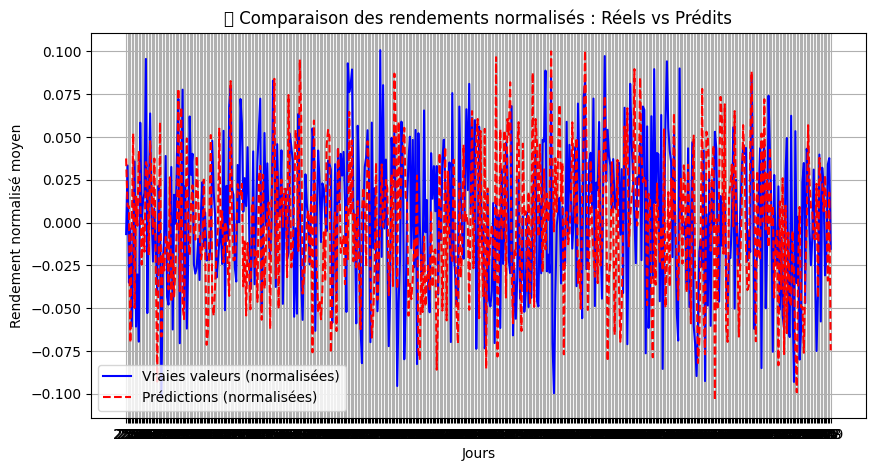

C:\Users\theod\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


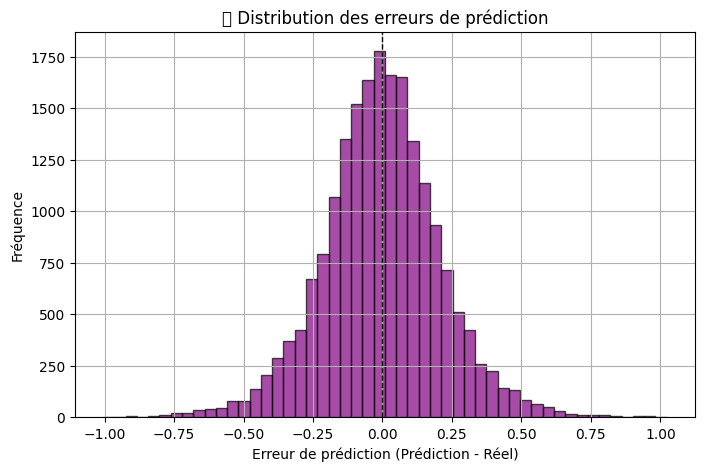

C:\Users\theod\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


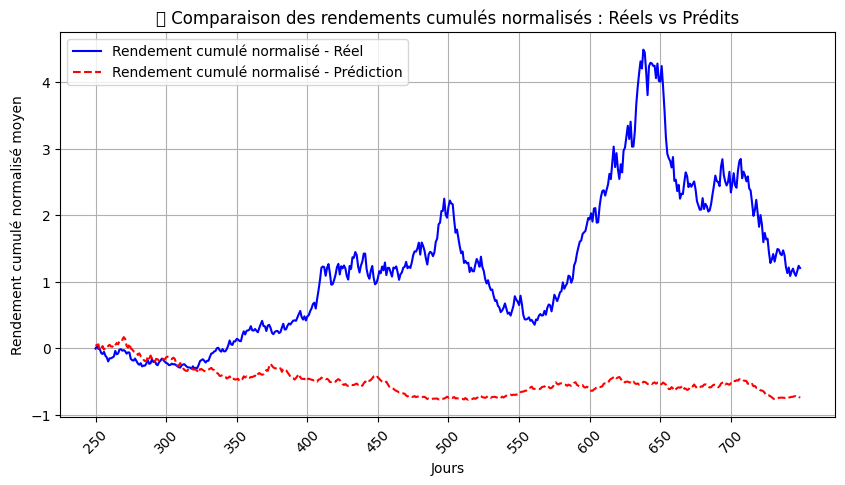

📊 Performance du modèle sur le jeu d'entrainement :
Valeur de la metrique : 0.021691
✅ Erreur quadratique moyenne (MSE) : 0.000225
✅ Corrélation entre les prédictions et les vraies valeurs : 0.0148


C:\Users\theod\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


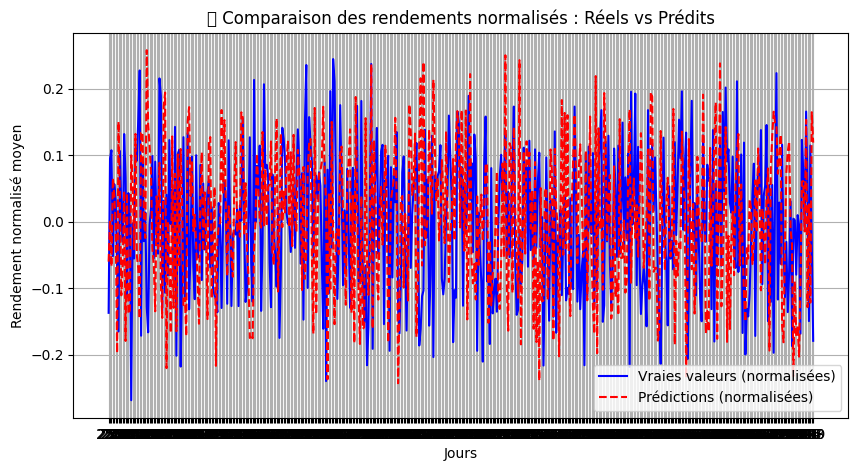

C:\Users\theod\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


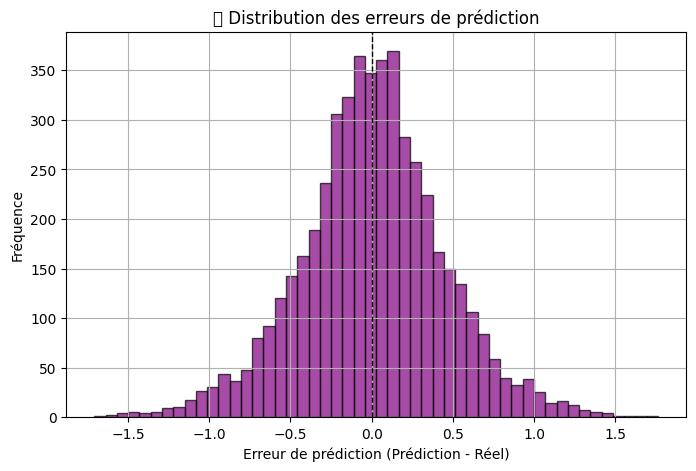

C:\Users\theod\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


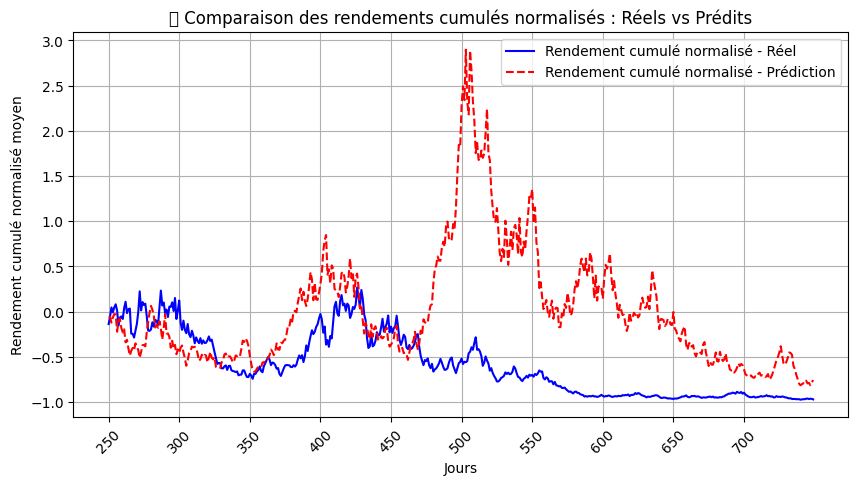

In [22]:
# Prédiction avec le modèle Bagging
predictions_df_train,predictions_df_test, actuals_df_train,actuals_df_test, alphas_df, betas_df,meanOverlap_train,meanOverlap_test = sliding_window_forecast(launch_bagging_model, X_train,Y_train,X_test)


# Normalisation des matrices (comme dans metric_train())
Ytrue = actuals_df_train.div(np.sqrt((actuals_df_train**2).sum()), axis=1)    
Ypred = predictions_df_train.div(np.sqrt((predictions_df_train**2).sum()), axis=1)

# Calcul des métriques
mse = mean_squared_error(actuals_df_train.values.flatten(), predictions_df_train.values.flatten())
correlation = np.corrcoef(actuals_df_train.values.flatten(), predictions_df_train.values.flatten())[0, 1]

# Affichage des performances
print(f"Performance du modèle sur le jeu d'entrainement :")
print(f"Valeur de la metrique : {meanOverlap_train:.6f}")
print(f"Erreur quadratique moyenne (MSE) : {mse:.6f}")
print(f"Corrélation entre les prédictions et les vraies valeurs : {correlation:.4f}")

tick_positions = actuals_df_train.columns[::50]  # Prendre un point tous les 50 jours
tick_labels = [str(day) for day in tick_positions]  # Convertir en string pour affichache


# Plot 1 : Moyenne des rendements normalisés réels vs prédits
plt.figure(figsize=(10, 5))
# On utilise les colonnes de actuals_df pour l'axe x (les jours)
plt.plot(actuals_df_train.columns, Ytrue.mean(axis=0), label="Vraies valeurs (normalisées)", color="blue")
plt.plot(predictions_df_train.columns, Ypred.mean(axis=0), label="Prédictions (normalisées)", color="red", linestyle="dashed")
plt.xlabel("Jours")
plt.ylabel("Rendement normalisé moyen")
plt.title("Comparaison des rendements normalisés : Réels vs Prédits")
plt.legend()
plt.grid()
plt.show()


# Plot 2 : Histogramme des erreurs de prédiction
# Ici, on définit les erreurs comme la différence entre les prédictions et les valeurs réelles
errors = (Ypred - Ytrue).values.flatten()
plt.figure(figsize=(8, 5))
plt.hist(errors, bins=50, color="purple", alpha=0.7, edgecolor="black")
plt.axvline(0, color='black', linestyle='dashed', linewidth=1)
plt.xlabel("Erreur de prédiction (Prédiction - Réel)")
plt.ylabel("Fréquence")
plt.title("Distribution des erreurs de prédiction")
plt.grid()
plt.show()


# Plot 3 : Rendements cumulés normalisés
plt.figure(figsize=(10, 5))
# Calcul du rendement cumulé normalisé à partir de la moyenne des rendements quotidiens
cumulative_real = (1 + Ytrue.mean(axis=0)).cumprod() - 1
cumulative_pred = (1 + Ypred.mean(axis=0)).cumprod() - 1
plt.plot(actuals_df_train.columns, cumulative_real, label="Rendement cumulé normalisé - Réel", color="blue")
plt.plot(predictions_df_train.columns, cumulative_pred, label="Rendement cumulé normalisé - Prédiction", color="red", linestyle="dashed")
plt.xticks(ticks=tick_positions, labels=tick_labels, rotation=45)
plt.xlabel("Jours")
plt.ylabel("Rendement cumulé normalisé moyen")
plt.title("Comparaison des rendements cumulés normalisés : Réels vs Prédits")
plt.legend()
plt.grid()
plt.show()


# Normalisation des matrices (comme dans metric_train())
Ytrue = actuals_df_test.div(np.sqrt((actuals_df_test**2).sum()), axis=1)    
Ypred = predictions_df_test.div(np.sqrt((predictions_df_test**2).sum()), axis=1)

# Calcul des métriques
mse = mean_squared_error(actuals_df_test.values.flatten(), predictions_df_test.values.flatten())
correlation = np.corrcoef(actuals_df_test.values.flatten(), predictions_df_test.values.flatten())[0, 1]

# Affichage des performances
print(f"Performance du modèle sur le jeu d'entrainement :")
print(f"Valeur de la metrique : {meanOverlap_test:.6f}")
print(f"Erreur quadratique moyenne (MSE) : {mse:.6f}")
print(f"Corrélation entre les prédictions et les vraies valeurs : {correlation:.4f}")

tick_positions = actuals_df_test.columns[::50]  # Prendre un point tous les 50 jours
tick_labels = [str(day) for day in tick_positions]  # Convertir en string pour affichache



# Plot 1 : Moyenne des rendements normalisés réels vs prédits
plt.figure(figsize=(10, 5))
# On utilise les colonnes de actuals_df pour l'axe x (les jours)
plt.plot(actuals_df_test.columns, Ytrue.mean(axis=0), label="Vraies valeurs (normalisées)", color="blue")
plt.plot(predictions_df_test.columns, Ypred.mean(axis=0), label="Prédictions (normalisées)", color="red", linestyle="dashed")
plt.xlabel("Jours")
plt.ylabel("Rendement normalisé moyen")
plt.title("Comparaison des rendements normalisés : Réels vs Prédits")
plt.legend()
plt.grid()
plt.show()


# Plot 2 : Histogramme des erreurs de prédiction
# Ici, on définit les erreurs comme la différence entre les prédictions et les valeurs réelles
errors = (Ypred - Ytrue).values.flatten()
plt.figure(figsize=(8, 5))
plt.hist(errors, bins=50, color="purple", alpha=0.7, edgecolor="black")
plt.axvline(0, color='black', linestyle='dashed', linewidth=1)
plt.xlabel("Erreur de prédiction (Prédiction - Réel)")
plt.ylabel("Fréquence")
plt.title("Distribution des erreurs de prédiction")
plt.grid()
plt.show()


# Plot 3 : Rendements cumulés normalisés
plt.figure(figsize=(10, 5))
# Calcul du rendement cumulé normalisé à partir de la moyenne des rendements quotidiens
cumulative_real = (1 + Ytrue.mean(axis=0)).cumprod() - 1
cumulative_pred = (1 + Ypred.mean(axis=0)).cumprod() - 1
plt.plot(actuals_df_test.columns, cumulative_real, label="Rendement cumulé normalisé - Réel", color="blue")
plt.plot(predictions_df_test.columns, cumulative_pred, label="Rendement cumulé normalisé - Prédiction", color="red", linestyle="dashed")
plt.xticks(ticks=tick_positions, labels=tick_labels, rotation=45)
plt.xlabel("Jours")
plt.ylabel("Rendement cumulé normalisé moyen")
plt.title("Comparaison des rendements cumulés normalisés : Réels vs Prédits")
plt.legend()
plt.grid()
plt.show()


# Stratégie de Prédiction avec le modèle Random Forest


In [23]:
# Prédiction avec le modèle Random Forest
predictions_df_train,predictions_df_test, actuals_df_train,actuals_df_test, alphas_df, betas_df,meanOverlap_train,meanOverlap_test = sliding_window_forecast(launch_random_forest_model, X_train,Y_train,X_test)

# Normalisation des matrices (comme dans metric_train())
Ytrue = actuals_df_train.div(np.sqrt((actuals_df_train**2).sum()), axis=1)    
Ypred = predictions_df_train.div(np.sqrt((predictions_df_train**2).sum()), axis=1)

# Calcul des métriques
mse = mean_squared_error(actuals_df_train.values.flatten(), predictions_df_train.values.flatten())
correlation = np.corrcoef(actuals_df_train.values.flatten(), predictions_df_train.values.flatten())[0, 1]

# Affichage des performances
print(f"Performance du modèle sur le jeu d'entrainement :")
print(f"Erreur quadratique moyenne (MSE) : {mse:.6f}")
print(f"Corrélation entre les prédictions et les vraies valeurs : {correlation:.4f}")

tick_positions = actuals_df_train.columns[::50]  # Prendre un point tous les 50 jours
tick_labels = [str(day) for day in tick_positions]  # Convertir en string pour affichage


# Plot 1 : Moyenne des rendements normalisés réels vs prédits
plt.figure(figsize=(10, 5))
# On utilise les colonnes de actuals_df pour l'axe x (les jours)
plt.plot(actuals_df_train.columns, Ytrue.mean(axis=0), label="Vraies valeurs (normalisées)", color="blue")
plt.plot(predictions_df_train.columns, Ypred.mean(axis=0), label="Prédictions (normalisées)", color="red", linestyle="dashed")
plt.xlabel("Jours")
plt.ylabel("Rendement normalisé moyen")
plt.title("Comparaison des rendements normalisés : Réels vs Prédits")
plt.legend()
plt.grid()
plt.show()


# Plot 2 : Histogramme des erreurs de prédiction
# Ici, on définit les erreurs comme la différence entre les prédictions et les valeurs réelles
errors = (Ypred - Ytrue).values.flatten()
plt.figure(figsize=(8, 5))
plt.hist(errors, bins=50, color="purple", alpha=0.7, edgecolor="black")
plt.axvline(0, color='black', linestyle='dashed', linewidth=1)
plt.xlabel("Erreur de prédiction (Prédiction - Réel)")
plt.ylabel("Fréquence")
plt.title("Distribution des erreurs de prédiction")
plt.grid()
plt.show()


# Plot 3 : Rendements cumulés normalisés
plt.figure(figsize=(10, 5))
# Calcul du rendement cumulé normalisé à partir de la moyenne des rendements quotidiens
cumulative_real = (1 + Ytrue.mean(axis=0)).cumprod() - 1
cumulative_pred = (1 + Ypred.mean(axis=0)).cumprod() - 1
plt.plot(actuals_df_train.columns, cumulative_real, label="Rendement cumulé normalisé - Réel", color="blue")
plt.plot(predictions_df_train.columns, cumulative_pred, label="Rendement cumulé normalisé - Prédiction", color="red", linestyle="dashed")
plt.xticks(ticks=tick_positions, labels=tick_labels, rotation=45)
plt.xlabel("Jours")
plt.ylabel("Rendement cumulé normalisé moyen")
plt.title("Comparaison des rendements cumulés normalisés : Réels vs Prédits")
plt.legend()
plt.grid()
plt.show()



# Normalisation des matrices (comme dans metric_train())
Ytrue = actuals_df_test.div(np.sqrt((actuals_df_test**2).sum()), axis=1)    
Ypred = predictions_df_test.div(np.sqrt((predictions_df_test**2).sum()), axis=1)

# Calcul des métriques
mse = mean_squared_error(actuals_df_test.values.flatten(), predictions_df_test.values.flatten())
correlation = np.corrcoef(actuals_df_test.values.flatten(), predictions_df_test.values.flatten())[0, 1]

# Affichage des performances
print(f"Performance du modèle sur le jeu d'entrainement :")
print(f"Erreur quadratique moyenne (MSE) : {mse:.6f}")
print(f"Corrélation entre les prédictions et les vraies valeurs : {correlation:.4f}")

tick_positions = actuals_df_test.columns[::50]  # Prendre un point tous les 50 jours
tick_labels = [str(day) for day in tick_positions]  # Convertir en string pour affichache



# Plot 1 : Moyenne des rendements normalisés réels vs prédits
plt.figure(figsize=(10, 5))
# On utilise les colonnes de actuals_df pour l'axe x (les jours)
plt.plot(actuals_df_test.columns, Ytrue.mean(axis=0), label="Vraies valeurs (normalisées)", color="blue")
plt.plot(predictions_df_test.columns, Ypred.mean(axis=0), label="Prédictions (normalisées)", color="red", linestyle="dashed")
plt.xlabel("Jours")
plt.ylabel("Rendement normalisé moyen")
plt.title("Comparaison des rendements normalisés : Réels vs Prédits")
plt.legend()
plt.grid()
plt.show()


# Plot 2 : Histogramme des erreurs de prédiction
# Ici, on définit les erreurs comme la différence entre les prédictions et les valeurs réelles
errors = (Ypred - Ytrue).values.flatten()
plt.figure(figsize=(8, 5))
plt.hist(errors, bins=50, color="purple", alpha=0.7, edgecolor="black")
plt.axvline(0, color='black', linestyle='dashed', linewidth=1)
plt.xlabel("Erreur de prédiction (Prédiction - Réel)")
plt.ylabel("Fréquence")
plt.title("Distribution des erreurs de prédiction")
plt.grid()
plt.show()


# Plot 3 : Rendements cumulés normalisés
plt.figure(figsize=(10, 5))
# Calcul du rendement cumulé normalisé à partir de la moyenne des rendements quotidiens
cumulative_real = (1 + Ytrue.mean(axis=0)).cumprod() - 1
cumulative_pred = (1 + Ypred.mean(axis=0)).cumprod() - 1
plt.plot(actuals_df_test.columns, cumulative_real, label="Rendement cumulé normalisé - Réel", color="blue")
plt.plot(predictions_df_test.columns, cumulative_pred, label="Rendement cumulé normalisé - Prédiction", color="red", linestyle="dashed")
plt.xticks(ticks=tick_positions, labels=tick_labels, rotation=45)
plt.xlabel("Jours")
plt.ylabel("Rendement cumulé normalisé moyen")
plt.title("Comparaison des rendements cumulés normalisés : Réels vs Prédits")
plt.legend()
plt.grid()
plt.show()

Fenêtre d'entraînement: 0 -> 249 | Fenêtre de prévision: 250 -> 299
Début du processus...
Préparation des données...
Optimisation du modèle Random Forest avec OOB Score...


Test d'hyperparamètres:   0%|          | 0/9 [00:00<?, ?it/s]


ValueError: Found input variables with inconsistent numbers of samples: [250, 50]